In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Expected Value of Cost function in population setting
## Projecting $p$ entries as sigmoids 
We have 

$$C(A, P) = \text{Tr}\left((B^* - B)\Sigma_X(B^* - B)\right),$$

where $$B = P^{-1}AP.$$

Here, $A$ is lower triangular and $P$ is a doubly stochastic matrix, namely

\begin{align*}
0 \leq &p_{ij} &\forall\ i,j = 1, \cdots, n\\
\sum_{j = 1}^n &p_{ij} = 1&\forall\ i = 1, \cdots, n\\
\sum_{i=1}^n &p_{ij} = 1 &\forall\ j = 1, \cdots, n\\
\end{align*}

In [75]:
# actual solution
n = 3
# As = np.tril(np.random.rand(n, n) / 2)
# As[np.abs(As) < 0.1] = 0
# As = np.zeros((n, n))
# As[0][2] = 0.5
# As[2][0] = 0.5
Ws = np.array([[0.8, 0.7, 0.6], [0.0, 0.7, 0.6], [0.0, 0.0, 0.6]])
As = Ws.copy()
Ps = np.identity(n)

# Ps = np.random.permutation(np.identity(n))
Bs = np.linalg.inv(Ps) @ As @ Ps
Sigma = np.identity(n)
cov_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

rho = 0.0

print(f"A*:\n{np.round(As, 2)}\n\nP*:\n{Ps}")

A*:
[[0.8 0.7 0.6]
 [0.  0.7 0.6]
 [0.  0.  0.6]]

P*:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [76]:
def expected_cost(A, P, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)    
    B = np.matmul(P_inv, np.matmul(A, P))
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(cov_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix) # - 0.5 * rho * np.linalg.norm(P, 'f') ** 2

A = np.random.rand(n, n)
P = np.identity(n)
print(f"Expected cost: {expected_cost(As, Ps)}.")

Expected cost: 3.0.


In [77]:
print(np.linalg.norm(Ps, 'f'))

1.7320508075688772


## Dealing with the constraints
### Non-negativity constraints
To deal with the $n^2$ equality constraints, we use non-negative $\textit{lagrange multipliers}$ $\lambda_{ineq, i, j} \geq 0$, $i, j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P_\sigma, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n\sum_{j=1}^n \lambda_{ineq,i,j} \left(-p_{ij}\right).$$


## Dealing with equality constraints
To deal with the $n^2$ equality constraints, we use non-negative $\textit{lagrange multipliers}$ $\lambda_{ineq, i, j} \geq 0$, $i, j = 1, \cdots, n$. 

To deal with the $2n$ equality constraints, we use $\textit{lagrange multipliers}$ $\lambda_{row, i}$, $i = 1, \cdots, n$ and $\lambda_{col, j}$, $j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n\sum_{j=1}^n \lambda_{ineq,i,j} \left(-p_{ij}\right) - \sum_{i=1}^n \lambda_{row, i} \left(\sum_{j = 1}^n p_{ij} - 1\right) - \sum_{j = 1}^n \lambda_{col, j} \left(\sum_{i = 1}^n p_{ij} - 1\right).$$

In [78]:
def expected_cost_lagrange(A, P, As = As, Ps = Ps):
    exp_cost = expected_cost(A, P)
    lambda_cost = 0
    
    for i in range(n):
        lambda_cost += lambdas[0][i] * (sum(P[:, i]) - 1)
        lambda_cost += lambdas[1][i] * (sum(P[i]) - 1)
        
    return exp_cost - lambda_cost - np.sum(lambdasineq * P)

lambdas = np.zeros((2, n))
lambdasineq = np.zeros((n, n))
P = np.ones((n, n)) / n + np.random.rand(n, n) / n
print(f"Expected lagrange cost: {expected_cost(np.random.rand(n,n), Ps)}.")

Expected lagrange cost: 51.42354846525585.


## Optimizing $\mathcal{L}(A, P_\sigma, \mathbf{\lambda})$
let $$q(\mathbf{\lambda}) = \inf_{A, P} \mathcal{L}(A, P, \mathbf{\lambda}).$$
Then the $\textit{dual problem}$ is $$\max_{\mathbf{\lambda}} q(\mathbf{\lambda}).$$

## Deriving $q(\mathbf{\lambda})$
To minimize $\mathcal{L}(A, P_\sigma, \mathbf{\lambda})$, we will use gradient descent.

The partial derivative with respect to entries in $A$ is simple, 

$$\frac{\partial\mathcal{L}(A, P, \mathbf{\lambda})}{\partial a_{ij}} = \frac{\partial C(A, P)}{\partial a_{ij}}$$

Now, the partial derivative with respect to the entries in $p$ is more involved as it occurs also in exactly two equality constraints, namely in $\lambda_{row, i}$ and in $\lambda{col, j}$.

$$\frac{\partial\mathcal{L}(A, P_\sigma, \mathbf{\lambda})}{\partial p_{ij}} = \frac{\partial C(A, P)}{\partial p_{ij}} - \lambda_{ineq, i, j} - \lambda_{row, i} - \lambda_{col, j}.$$

Now, as $C(A, P)$ is unfortunately yet inevitably non-convex, we cannot expect to find the infimum $q(\mathbf{\lambda})$. However, let us consider a local minimum $\tilde{q}(\mathbf{\lambda})$, which we will find by gradient descent. 

For a sufficiently small step size, we will do this gradient descent until we have found a stationary point:
$$(A_{t + 1}, P_{t + 1}) = (A_t, P_t) - \eta\ \nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda})$$
Note that this is an $\textit{unconstrained}$ optimization problem now, which should make things more easy. 

Suppose that after a number of iterations, we have found this local minimum with parameters $\tilde{A}$, $\tilde{P}$. Then, we have that $$\tilde{q}(\mathbf{\lambda}) = \mathcal{L}(\tilde{A}, \tilde{P}, \mathbf{\lambda}).$$

In [79]:
# get gradient of our outcome
def grad_a(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
#     Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
#     Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    J = np.zeros((n, n))
    J[i][j] = 1
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    return -2 * np.trace(np.matmul(cov_X, np.matmul((Bs - B).transpose(), np.matmul(P_inv, np.matmul(J, P)))))

def grad_p(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
#     Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
#     Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    B_grad = np.matmul(P_inv, np.matmul(A, J))
    B_grad -= np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
    return -2 * np.trace(np.matmul(cov_X, np.matmul((Bs - B).transpose(), B_grad))) - lambdasineq[i][j] - lambdas[0][j] - lambdas[1][i] #- rho * np.trace(np.matmul(P.transpose(), J))

def get_gradient(A, P):
    gradient = np.zeros(int(n * (n + 1) / 2 + n ** 2))
    index = 0
    
    for i in range(n):
        for j in range(i + 1):
            gradient[index] = grad_a(A, P, i, j, As = As, Ps = Ps)
            index += 1
            
    for i in range(n):
        for j in range(n):
            gradient[index] = grad_p(A, P, i, j, As = As, Ps = Ps)
            index += 1
            
    return gradient

## Deriving the dual problem
Now that we have $\tilde{q}(\mathbf{\lambda})$, the solution to the dual problem is
$$\max_{\lambda} \tilde{q}(\mathbf{\lambda}),$$
which is again an unconstrained optimization problem, which we can also optimize by maximizing $\lambda$'s.

## Final Algorithm
To solve this problem, we simply iterate the following:
- While $\nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda}) \geq 0$:
    - $(A_{t + 1}, P_{t + 1}) = (A_t, P_t) - \eta\ \nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda})$
    - $\lambda_{ineq, i, j} = max(0, p_{ij})\ \forall i, j = 1, \cdots, n$
    - $\lambda_{row, i} = 1 - \sum_{j=1}^n p_{ij} \ \forall i = 1, \cdots, n$
    - $\lambda_{col, j} = 1 - \sum_{i=1}^n p_{ij} \ \forall j = 1, \cdots, n$
    
We will end up in a local optimum of $C(A, P)$ while also fullfilling the constraints.

In [98]:
# Initial values
A = np.triu(np.random.rand(n, n)) / n
P = np.random.rand(n, n) / n
lambdas = np.zeros((2, n))
lambdasineq = np.zeros((n, n))

print(A)
print(P)

[[0.07597337 0.21021317 0.28720682]
 [0.         0.10959079 0.17491422]
 [0.         0.         0.03827415]]
[[0.22290966 0.20515051 0.15495063]
 [0.10306523 0.19737712 0.26334651]
 [0.01239016 0.12898656 0.21263938]]


In [94]:
# rho = 0.05

In [111]:
# optimize dual
def grad_lambda(A, P, i, row_or_col):
    if row_or_col:
        return - np.sum(P[i]) + 1
    else:
        return - np.sum(P[:, i]) + 1

A = np.triu(np.random.rand(n, n)) / n
P = np.random.rand(n, n) / n
lambdas = np.zeros((2, n))
lambdasineq = np.zeros((n, n))

lagrange = np.zeros((2, n))

for row_or_col in range(2):
    for i in range(n):
        lagrange[row_or_col][i] = grad_lambda(A, P, i, row_or_col)

print(np.sum(np.abs(lagrange)))

# step size
eta = 1e-6

3.0913530918864973


In [ ]:
# the algorithm
grad = get_gradient(A, P)
previous_cost = 1e12

# while gradient is larger than zero (or a value close)
while np.linalg.norm(grad, 2) > 0.01:
    # get gradient
    A_grad = np.zeros((n , n))
    A_grad[np.triu_indices(n)] = grad[:int(n * (n + 1) / 2)]
    P_grad = grad[int(n * (n + 1) / 2):].reshape((n , n))

    # update A and B according to gradient
    A -= eta * A_grad 
    P -= eta * P_grad 

    new_cost = expected_cost_lagrange(A, P)
    
    if new_cost > previous_cost:
        print("Revert gradient", eta, "\t", round(new_cost, 5), "\t", np.linalg.norm(grad, 2))
        
        A += 9 * eta * A_grad / 10
        P += 9 * eta * P_grad / 10
        
        # do not use the new_cost, revert to old A and P        
        eta /= 10
        
    else: # recompute gradient
        eta *= 1.1
        eta = min(eta, 0.1)

    previous_cost = new_cost

    grad = get_gradient(A, P)

    # print("Gradient:", np.linalg.norm(grad, 2), new_cost)    

    # update equality constraints
    for row_or_col in range(2):
        for i in range(n):
            lagrange[row_or_col][i] = grad_lambda(A, P, i, row_or_col)

    # update equality constraints
    lambdas = lagrange 

    # lambdasineq = np.maximum(np.zeros((n, n)), -P) 

Revert gradient 1.1e-06 	 28.61698 	 545.7797764871539
Revert gradient 1.1e-07 	 28.77403 	 545.2203724728919
Revert gradient 1.1000000000000001e-08 	 28.78978 	 545.1591733295384
Revert gradient 1.1000000000000001e-09 	 28.79135 	 545.1530552758569
Revert gradient 1.1000000000000001e-10 	 28.79151 	 545.152443489128
Revert gradient 1.1e-11 	 28.79153 	 545.1523823106414
Revert gradient 1.1000000000000002e-12 	 28.79153 	 545.1523761927948
Revert gradient 1.1000000000000001e-13 	 28.79153 	 545.1523755810102
Revert gradient 1.1e-14 	 28.79153 	 545.1523755198313
Revert gradient 1.1000000000000001e-15 	 28.79153 	 545.1523755137133
Revert gradient 1.1000000000000001e-16 	 28.79153 	 545.1523755131021
Revert gradient 1.1000000000000002e-17 	 28.79153 	 545.1523755130403
Revert gradient 1.1000000000000001e-18 	 28.79153 	 545.1523755130348
Revert gradient 1.1000000000000002e-19 	 28.79153 	 545.152375513034
Revert gradient 1.1000000000000001e-20 	 28.79153 	 545.152375513034
Revert gradie

Revert gradient 1.9284293020111338e-20 	 28.79153 	 545.1523755130336
Revert gradient 3.364993863790019e-20 	 28.79153 	 545.1523755130335
Revert gradient 2.490179565294118e-20 	 28.79153 	 545.1523755130335
Revert gradient 1.842795118926063e-20 	 28.79153 	 545.1523755130335
Revert gradient 2.6574936635769678e-20 	 28.79153 	 545.1523755130338
Revert gradient 1.787828848704718e-20 	 28.79153 	 545.1523755130338
Revert gradient 2.578226840410641e-20 	 28.79153 	 545.1523755130339
Revert gradient 1.9079523032033766e-20 	 28.79153 	 545.1523755130339
Revert gradient 2.7514567973920756e-20 	 28.79153 	 545.1523755130344
Revert gradient 2.9811225315680325e-20 	 28.79153 	 545.1523755130344
Revert gradient 1.823227425459761e-20 	 28.79153 	 545.1523755130343
Revert gradient 4.234473849887757e-20 	 28.79153 	 545.1523755130333
Revert gradient 1.7688448137882095e-20 	 28.79153 	 545.1523755130333
Revert gradient 2.1081404758571142e-20 	 28.79153 	 545.1523755130337
Revert gradient 1.887692739

Revert gradient 1.916893547745587e-20 	 28.79153 	 545.1523755130336
Revert gradient 2.764350960433524e-20 	 28.79153 	 545.1523755130337
Revert gradient 1.8597170946234735e-20 	 28.79153 	 545.1523755130335
Revert gradient 3.5696046859450743e-20 	 28.79153 	 545.1523755130331
Revert gradient 1.8042460814280953e-20 	 28.79153 	 545.1523755130331
Revert gradient 1.954847574178421e-20 	 28.79153 	 545.1523755130333
Revert gradient 1.9254726027608472e-20 	 28.79153 	 545.1523755130333
Revert gradient 3.359834600329383e-20 	 28.79153 	 545.1523755130336
Revert gradient 2.4863615813804196e-20 	 28.79153 	 545.1523755130336
Revert gradient 1.8399697154016105e-20 	 28.79153 	 545.1523755130336
Revert gradient 2.918761066055564e-20 	 28.79153 	 545.152375513034
Revert gradient 2.9187610660555638e-21 	 28.79153 	 545.1523755130341
Revert gradient 3.76899435985944e-20 	 28.79153 	 545.152375513033
Revert gradient 3.0680650331605114e-20 	 28.79153 	 545.1523755130335
Revert gradient 3.06806503316

Revert gradient 1.848592372869529e-20 	 28.79153 	 545.1523755130346
Revert gradient 2.6658538797847722e-20 	 28.79153 	 545.152375513035
Revert gradient 3.177211716305999e-20 	 28.79153 	 545.152375513035
Revert gradient 2.351216082648988e-20 	 28.79153 	 545.152375513035
Revert gradient 1.9139545353018298e-20 	 28.79153 	 545.152375513035
Revert gradient 2.760112612466218e-20 	 28.79153 	 545.1523755130352
Revert gradient 2.9905008526709006e-20 	 28.79153 	 545.152375513035
Revert gradient 2.4343499145110037e-20 	 28.79153 	 545.1523755130353
Revert gradient 1.8014797819164944e-20 	 28.79153 	 545.1523755130353
Revert gradient 3.457821993331941e-20 	 28.79153 	 545.1523755130349
Revert gradient 3.096238388622535e-20 	 28.79153 	 545.1523755130349
Revert gradient 2.772465493500486e-20 	 28.79153 	 545.1523755130354
Revert gradient 3.3042733196295844e-20 	 28.79153 	 545.1523755130352
Revert gradient 2.4452448449402603e-20 	 28.79153 	 545.1523755130353
Revert gradient 1.80954230274667

Revert gradient 1.894028645098428e-20 	 28.79153 	 545.1523755130347
Revert gradient 2.7313774989352415e-20 	 28.79153 	 545.1523755130348
Revert gradient 1.8375341985675947e-20 	 28.79153 	 545.1523755130348
Revert gradient 2.914897583058349e-20 	 28.79153 	 545.1523755130352
Revert gradient 2.6100874518620455e-20 	 28.79153 	 545.1523755130354
Revert gradient 1.9315299520151056e-20 	 28.79153 	 545.152375513035
Revert gradient 4.4860081402189434e-20 	 28.79153 	 545.152375513034
Revert gradient 1.8739169291713316e-20 	 28.79153 	 545.152375513034
Revert gradient 2.972611846871542e-20 	 28.79153 	 545.1523755130345
Revert gradient 2.661766549147591e-20 	 28.79153 	 545.1523755130346
Revert gradient 1.7907034324507025e-20 	 28.79153 	 545.1523755130346
Revert gradient 3.124670453710805e-20 	 28.79153 	 545.152375513035
Revert gradient 2.7979244244587243e-20 	 28.79153 	 545.1523755130345
Revert gradient 5.370431968035517e-20 	 28.79153 	 545.1523755130335
Revert gradient 2.714468880001

Revert gradient 1.8826986736035104e-20 	 28.79153 	 545.1523755130339
Revert gradient 2.9865424097096904e-20 	 28.79153 	 545.1523755130344
Revert gradient 2.674240396418436e-20 	 28.79153 	 545.1523755130347
Revert gradient 1.7990952131389538e-20 	 28.79153 	 545.1523755130347
Revert gradient 4.178426414123327e-20 	 28.79153 	 545.1523755130339
Revert gradient 1.9199756498378166e-20 	 28.79153 	 545.1523755130339
Revert gradient 6.52867532837601e-20 	 28.79153 	 545.1523755130327
Revert gradient 1.8627072648157802e-20 	 28.79153 	 545.1523755130327
Revert gradient 2.686208956441963e-20 	 28.79153 	 545.1523755130328
Revert gradient 2.1866479448192983e-20 	 28.79153 	 545.1523755130328
Revert gradient 1.779991546493738e-20 	 28.79153 	 545.1523755130328
Revert gradient 3.4165767382985203e-20 	 28.79153 	 545.1523755130323
Revert gradient 2.7811873998862134e-20 	 28.79153 	 545.1523755130323
Revert gradient 1.8710438091799534e-20 	 28.79153 	 545.1523755130326
Revert gradient 3.26485960

Revert gradient 2.698797348264279e-20 	 28.79153 	 545.1523755130341
Revert gradient 1.8156159023688028e-20 	 28.79153 	 545.1523755130343
Revert gradient 2.6182985327454957e-20 	 28.79153 	 545.1523755130343
Revert gradient 1.7614603246364647e-20 	 28.79153 	 545.1523755130343
Revert gradient 4.091018804418768e-20 	 28.79153 	 545.1523755130337
Revert gradient 2.7522328799417385e-20 	 28.79153 	 545.1523755130337
Revert gradient 2.710875812899428e-20 	 28.79153 	 545.1523755130339
Revert gradient 2.6701402074372066e-20 	 28.79153 	 545.1523755130343
Revert gradient 1.7963368110226083e-20 	 28.79153 	 545.1523755130343
Revert gradient 3.4479503988536355e-20 	 28.79153 	 545.1523755130339
Revert gradient 2.3196086133565055e-20 	 28.79153 	 545.1523755130339
Revert gradient 1.8882251862861484e-20 	 28.79153 	 545.1523755130339
Revert gradient 2.723008334690088e-20 	 28.79153 	 545.1523755130344
Revert gradient 2.6820904170693476e-20 	 28.79153 	 545.1523755130346
Revert gradient 1.984813

Revert gradient 2.6423417829607036e-20 	 28.79153 	 545.1523755130356
Revert gradient 2.8628996220307814e-20 	 28.79153 	 545.152375513036
Revert gradient 1.9260157062136397e-20 	 28.79153 	 545.1523755130353
Revert gradient 3.696860511730674e-20 	 28.79153 	 545.1523755130352
Revert gradient 2.2609662641210876e-20 	 28.79153 	 545.1523755130352
Revert gradient 1.8404887017034853e-20 	 28.79153 	 545.1523755130352
Revert gradient 2.9195843388513345e-20 	 28.79153 	 545.1523755130355
Revert gradient 2.6142841147418353e-20 	 28.79153 	 545.1523755130356
Revert gradient 3.1157499599269153e-20 	 28.79153 	 545.1523755130355
Revert gradient 2.7899367445398596e-20 	 28.79153 	 545.1523755130355
Revert gradient 1.876929930751357e-20 	 28.79153 	 545.1523755130355
Revert gradient 2.9773913992903273e-20 	 28.79153 	 545.152375513036
Revert gradient 2.003040048784819e-20 	 28.79153 	 545.152375513036
Revert gradient 1.793582638133376e-20 	 28.79153 	 545.152375513036
Revert gradient 2.1376234516

Revert gradient 2.946394229284163e-20 	 28.79153 	 545.1523755130319
Revert gradient 2.638290501453751e-20 	 28.79153 	 545.1523755130319
Revert gradient 1.774909921483635e-20 	 28.79153 	 545.1523755130319
Revert gradient 3.09711172110056e-20 	 28.79153 	 545.1523755130322
Revert gradient 3.0971117211005602e-21 	 28.79153 	 545.1523755130322
Revert gradient 2.731574653671655e-20 	 28.79153 	 545.1523755130322
Revert gradient 1.8376668344155187e-20 	 28.79153 	 545.1523755130322
Revert gradient 4.694810560176764e-20 	 28.79153 	 545.1523755130314
Revert gradient 2.6102758517092992e-20 	 28.79153 	 545.1523755130314
Revert gradient 3.1109728412837745e-20 	 28.79153 	 545.1523755130314
Revert gradient 1.902642693826359e-20 	 28.79153 	 545.152375513031
Revert gradient 4.860808740698748e-20 	 28.79153 	 545.1523755130306
Revert gradient 1.845891310360315e-20 	 28.79153 	 545.1523755130303
Revert gradient 2.6619586792660373e-20 	 28.79153 	 545.1523755130307
Revert gradient 3.1725693475627

Revert gradient 2.897669974581445e-20 	 28.79153 	 545.1523755130297
Revert gradient 2.897669974581445e-21 	 28.79153 	 545.1523755130302
Revert gradient 4.115935391128026e-20 	 28.79153 	 545.1523755130293
Revert gradient 2.2884260442348168e-20 	 28.79153 	 545.1523755130294
Revert gradient 1.862841717691642e-20 	 28.79153 	 545.1523755130294
Revert gradient 2.6864028508483363e-20 	 28.79153 	 545.1523755130298
Revert gradient 2.6460349940383622e-20 	 28.79153 	 545.1523755130298
Revert gradient 1.958132031713756e-20 	 28.79153 	 545.1523755130298
Revert gradient 1.9287077056316563e-20 	 28.79153 	 545.1523755130298
Revert gradient 3.7020276276134595e-20 	 28.79153 	 545.1523755130295
Revert gradient 2.2641264251974143e-20 	 28.79153 	 545.1523755130295
Revert gradient 1.8430611597046682e-20 	 28.79153 	 545.1523755130295
Revert gradient 2.6578773208138105e-20 	 28.79153 	 545.1523755130299
Revert gradient 2.617938109510783e-20 	 28.79153 	 545.1523755130299
Revert gradient 3.12010485

Revert gradient 1.8434479552754482e-20 	 28.79153 	 545.1523755130297
Revert gradient 2.6584351184592967e-20 	 28.79153 	 545.1523755130302
Revert gradient 2.880336277808338e-20 	 28.79153 	 545.1523755130297
Revert gradient 1.761587469363301e-20 	 28.79153 	 545.1523755130297
Revert gradient 2.7944225804318114e-20 	 28.79153 	 545.1523755130302
Revert gradient 3.33044216345976e-20 	 28.79153 	 545.15237551303
Revert gradient 2.9821786365742776e-20 	 28.79153 	 545.1523755130302
Revert gradient 2.9821786365742776e-21 	 28.79153 	 545.1523755130304
Revert gradient 2.6302065633889018e-20 	 28.79153 	 545.1523755130304
Revert gradient 1.7694714521914725e-20 	 28.79153 	 545.1523755130307
Revert gradient 3.087621917259967e-20 	 28.79153 	 545.1523755130302
Revert gradient 2.7647500444522996e-20 	 28.79153 	 545.1523755130302
Revert gradient 1.859985578395082e-20 	 28.79153 	 545.1523755130303
Revert gradient 3.245563657174322e-20 	 28.79153 	 545.1523755130299
Revert gradient 2.40179822730

Revert gradient 2.951131627367271e-20 	 28.79153 	 545.1523755130282
Revert gradient 2.642532510971705e-20 	 28.79153 	 545.1523755130282
Revert gradient 1.7777637333653427e-20 	 28.79153 	 545.1523755130283
Revert gradient 4.541772095243509e-20 	 28.79153 	 545.1523755130276
Revert gradient 1.897210917075906e-20 	 28.79153 	 545.1523755130276
Revert gradient 2.7359666513206986e-20 	 28.79153 	 545.1523755130279
Revert gradient 2.694854012543347e-20 	 28.79153 	 545.1523755130281
Revert gradient 1.994259325610782e-20 	 28.79153 	 545.1523755130281
Revert gradient 1.7857201130456913e-20 	 28.79153 	 545.1523755130281
Revert gradient 3.1159748592175664e-20 	 28.79153 	 545.1523755130286
Revert gradient 2.536489205605813e-20 	 28.79153 	 545.1523755130286
Revert gradient 1.877065410239587e-20 	 28.79153 	 545.1523755130286
Revert gradient 1.8488592505865116e-20 	 28.79153 	 545.1523755130286
Revert gradient 2.666238743969915e-20 	 28.79153 	 545.152375513029
Revert gradient 2.626173887798

Revert gradient 2.803213561674245e-20 	 28.79153 	 545.1523755130223
Revert gradient 2.761090421568991e-20 	 28.79153 	 545.1523755130223
Revert gradient 1.8575235671188814e-20 	 28.79153 	 545.1523755130225
Revert gradient 2.9466069042358415e-20 	 28.79153 	 545.1523755130223
Revert gradient 2.1805627578822028e-20 	 28.79153 	 545.1523755130223
Revert gradient 1.775038037021614e-20 	 28.79153 	 545.1523755130223
Revert gradient 2.815759340960427e-20 	 28.79153 	 545.1523755130224
Revert gradient 3.6914588604652945e-20 	 28.79153 	 545.1523755130219
Revert gradient 1.865836911849575e-20 	 28.79153 	 545.1523755130219
Revert gradient 2.6907222184297557e-20 	 28.79153 	 545.1523755130224
Revert gradient 2.915318401202808e-20 	 28.79153 	 545.1523755130224
Revert gradient 1.782982217850901e-20 	 28.79153 	 545.1523755130224
Revert gradient 4.555104107125148e-20 	 28.79153 	 545.1523755130218
Revert gradient 1.9027800292986253e-20 	 28.79153 	 545.1523755130218
Revert gradient 3.3202374160

Revert gradient 4.1418727889599375e-20 	 28.79153 	 545.152375513018
Revert gradient 2.0934972936018865e-20 	 28.79153 	 545.152375513018
Revert gradient 1.8745807908641215e-20 	 28.79153 	 545.152375513018
Revert gradient 3.598134573584691e-20 	 28.79153 	 545.152375513018
Revert gradient 2.2005863783143397e-20 	 28.79153 	 545.152375513018
Revert gradient 1.7913378145801587e-20 	 28.79153 	 545.152375513018
Revert gradient 2.348442834416011e-20 	 28.79153 	 545.1523755130183
Revert gradient 1.9116970349928652e-20 	 28.79153 	 545.1523755130183
Revert gradient 2.756857072713058e-20 	 28.79153 	 545.1523755130185
Revert gradient 2.0401431398672554e-20 	 28.79153 	 545.1523755130185
Revert gradient 1.8268058680068437e-20 	 28.79153 	 545.1523755130185
Revert gradient 4.2427848379616245e-20 	 28.79153 	 545.152375513018
Revert gradient 1.7723165197599693e-20 	 28.79153 	 545.152375513018
Revert gradient 3.092586390108454e-20 	 28.79153 	 545.1523755130183
Revert gradient 2.76919538358265

Revert gradient 0.0019465590926902587 	 4.62714 	 8.19056968837185
Revert gradient 0.0023199434907800664 	 4.73435 	 11.365296763306123
Revert gradient 0.0015607419716661178 	 4.08633 	 6.280717021419717
Revert gradient 0.0012704868757705933 	 4.09314 	 7.988523041676129
Revert gradient 0.0004386065269487047 	 3.89097 	 9.631731867960777
Revert gradient 0.0006325141922716639 	 6.20591 	 27.365322631273767
Revert gradient 0.00011205374749749815 	 3.74216 	 14.431596231357235
Revert gradient 0.0003148983362637388 	 3.73017 	 6.14857845185792
Revert gradient 8.167651853821074e-05 	 3.68269 	 9.645823804993103
Revert gradient 0.00020866447310816563 	 3.66953 	 3.796313555148375
Revert gradient 0.00010546883788589328 	 3.66484 	 4.155347750389095
Revert gradient 0.0001840368179102923 	 3.65854 	 4.133986474552975
Revert gradient 0.00013619184514820917 	 3.65299 	 4.53618937004164
Revert gradient 0.00016231584534751674 	 3.64632 	 2.734215488415169
Revert gradient 0.00015987676857207739 	 3.

Revert gradient 6.2982814022580966e-18 	 3.49738 	 2.2193627614990956
Revert gradient 1.462785581473522e-17 	 3.49738 	 2.2193627614992053
Revert gradient 6.721460231703678e-18 	 3.49738 	 2.2193627614992053
Revert gradient 1.419154107349575e-17 	 3.49738 	 2.2193627614997338
Revert gradient 6.5209747867491945e-18 	 3.49738 	 2.2193627614997338
Revert gradient 1.3768240580949586e-17 	 3.49738 	 2.2193627615001166
Revert gradient 6.326469353913061e-18 	 3.49738 	 2.2193627615001166
Revert gradient 1.2143241956803234e-17 	 3.49738 	 2.2193627615002205
Revert gradient 6.751542119755567e-18 	 3.49738 	 2.2193627615002205
Revert gradient 7.315097353195271e-18 	 3.49738 	 2.219362761500502
Revert gradient 6.550159402407397e-18 	 3.49738 	 2.219362761500502
Revert gradient 1.3829860326890199e-17 	 3.49738 	 2.219362761500874
Revert gradient 6.3547834607153916e-18 	 3.49738 	 2.219362761500874
Revert gradient 1.4759082718006448e-17 	 3.49738 	 2.219362761501206
Revert gradient 6.78175863926513

Revert gradient 9.825801712341075e-18 	 3.49738 	 2.219362761527066
Revert gradient 6.6103080521858045e-18 	 3.49738 	 2.219362761527066
Revert gradient 1.3956856843185774e-17 	 3.49738 	 2.2193627615273632
Revert gradient 6.413138016889359e-18 	 3.49738 	 2.2193627615273632
Revert gradient 1.3540556432573521e-17 	 3.49738 	 2.2193627615277696
Revert gradient 6.844034013071293e-18 	 3.49738 	 2.2193627615277696
Revert gradient 1.445034061895869e-17 	 3.49738 	 2.2193627615282088
Revert gradient 6.63989247877757e-18 	 3.49738 	 2.2193627615282088
Revert gradient 1.5421252815106118e-17 	 3.49738 	 2.219362761528539
Revert gradient 6.441840009199807e-18 	 3.49738 	 2.219362761528539
Revert gradient 2.650480757324326e-17 	 3.49738 	 2.2193627615294313
Revert gradient 6.249694981772829e-18 	 3.49738 	 2.2193627615294313
Revert gradient 2.337657375233091e-17 	 3.49738 	 2.2193627615299722
Revert gradient 7.33657024148267e-18 	 3.49738 	 2.2193627615299727
Revert gradient 6.5693868759899765e-

Revert gradient 2.4687513843853556e-17 	 3.49738 	 2.219362761555887
Revert gradient 7.043635818022054e-18 	 3.49738 	 2.219362761555886
Revert gradient 6.3070845339328025e-18 	 3.49738 	 2.219362761555886
Revert gradient 1.464830122398759e-17 	 3.49738 	 2.2193627615563085
Revert gradient 6.7308548420246385e-18 	 3.49738 	 2.2193627615563085
Revert gradient 2.5176320618800718e-17 	 3.49738 	 2.2193627615570324
Revert gradient 7.183098095588206e-18 	 3.49738 	 2.2193627615570315
Revert gradient 6.431963275058793e-18 	 3.49738 	 2.2193627615570315
Revert gradient 3.5223810230192065e-17 	 3.49738 	 2.219362761558426
Revert gradient 6.864124132273024e-18 	 3.49738 	 2.219362761557498
Revert gradient 1.449275844811998e-17 	 3.49738 	 2.2193627615577896
Revert gradient 6.6593833566911705e-18 	 3.49738 	 2.2193627615577896
Revert gradient 1.406047334548942e-17 	 3.49738 	 2.2193627615580858
Revert gradient 6.4607495197919635e-18 	 3.49738 	 2.2193627615580858
Revert gradient 1.50051905265384

Revert gradient 6.462105410390072e-18 	 3.49738 	 2.2193627615837546
Revert gradient 1.3643945093991119e-17 	 3.49738 	 2.2193627615841938
Revert gradient 6.2693559134230355e-18 	 3.49738 	 2.2193627615841938
Revert gradient 1.2033616463015464e-17 	 3.49738 	 2.2193627615844744
Revert gradient 6.690591251664493e-18 	 3.49738 	 2.2193627615844744
Revert gradient 6.590053527199247e-18 	 3.49738 	 2.2193627615845792
Revert gradient 2.4649662545080245e-17 	 3.49738 	 2.2193627615853107
Revert gradient 6.39348763703113e-18 	 3.49738 	 2.2193627615853107
Revert gradient 1.3499067059244727e-17 	 3.49738 	 2.2193627615856024
Revert gradient 6.823063332607957e-18 	 3.49738 	 2.2193627615856024
Revert gradient 1.44060635924086e-17 	 3.49738 	 2.2193627615860425
Revert gradient 6.619547304686179e-18 	 3.49738 	 2.2193627615860425
Revert gradient 1.3976364394644457e-17 	 3.49738 	 2.2193627615861913
Revert gradient 6.422101684087621e-18 	 3.49738 	 2.2193627615861913
Revert gradient 1.491543033131

Revert gradient 8.680043933934061e-18 	 3.49738 	 2.2193627616094034
Revert gradient 6.4234494638254024e-18 	 3.49738 	 2.2193627616094034
Revert gradient 1.9856604119427465e-17 	 3.49738 	 2.2193627616097307
Revert gradient 6.855038281709896e-18 	 3.49738 	 2.2193627616097307
Revert gradient 9.885646326129928e-18 	 3.49738 	 2.219362761610219
Revert gradient 6.6505685158090004e-18 	 3.49738 	 2.219362761610219
Revert gradient 7.926264964766225e-18 	 3.49738 	 2.2193627616102902
Revert gradient 6.452197605005546e-18 	 3.49738 	 2.2193627616102902
Revert gradient 2.1940019562833928e-17 	 3.49738 	 2.219362761611045
Revert gradient 6.2597436347101755e-18 	 3.49738 	 2.219362761611045
Revert gradient 1.4538351254505396e-17 	 3.49738 	 2.2193627616113636
Revert gradient 6.680333128062492e-18 	 3.49738 	 2.2193627616113636
Revert gradient 7.237944504643307e-18 	 3.49738 	 2.219362761611435
Revert gradient 6.481074408460679e-18 	 3.49738 	 2.219362761611435
Revert gradient 1.130908744878157e

Revert gradient 1.4107666321010637e-17 	 3.49738 	 2.219362761633015
Revert gradient 6.482434564558546e-18 	 3.49738 	 2.219362761633015
Revert gradient 1.368686761624461e-17 	 3.49738 	 2.2193627616335676
Revert gradient 6.289078696449143e-18 	 3.49738 	 2.2193627616335676
Revert gradient 1.460648238838585e-17 	 3.49738 	 2.2193627616338976
Revert gradient 6.7116392000335505e-18 	 3.49738 	 2.2193627616338976
Revert gradient 2.0747475844252943e-17 	 3.49738 	 2.2193627616345237
Revert gradient 6.5114466934936975e-18 	 3.49738 	 2.2193627616345237
Revert gradient 8.536502832996402e-18 	 3.49738 	 2.219362761634806
Revert gradient 6.317225461404134e-18 	 3.49738 	 2.219362761634806
Revert gradient 1.9528237254250304e-17 	 3.49738 	 2.219362761635145
Revert gradient 6.741677134068735e-18 	 3.49738 	 2.219362761635145
Revert gradient 2.084033115012265e-17 	 3.49738 	 2.2193627616357863
Revert gradient 6.540588666180757e-18 	 3.49738 	 2.2193627616357863
Revert gradient 2.4464642480081885e

Revert gradient 6.443657010151314e-18 	 3.49738 	 2.2193627616592453
Revert gradient 6.3468299004584295e-18 	 3.49738 	 2.219362761659525
Revert gradient 1.2182322687182527e-17 	 3.49738 	 2.2193627616597253
Revert gradient 6.773270682701541e-18 	 3.49738 	 2.2193627616597253
Revert gradient 1.430093250304023e-17 	 3.49738 	 2.219362761660177
Revert gradient 6.571239853118785e-18 	 3.49738 	 2.219362761660177
Revert gradient 6.472495590183344e-18 	 3.49738 	 2.219362761660365
Revert gradient 2.6630939280000074e-17 	 3.49738 	 2.219362761661067
Revert gradient 6.279436178443742e-18 	 3.49738 	 2.219362761661067
Revert gradient 2.5836600620385127e-17 	 3.49738 	 2.2193627616616447
Revert gradient 6.701348805373895e-18 	 3.49738 	 2.2193627616616447
Revert gradient 2.0715665475985847e-17 	 3.49738 	 2.219362761662277
Revert gradient 2.040437671399178e-17 	 3.49738 	 2.2193627616627776
Revert gradient 2.6750126020160925e-17 	 3.49738 	 2.2193627616636036
Revert gradient 6.3075397883197505e

Revert gradient 1.4875970182620602e-17 	 3.49738 	 2.219362761685376
Revert gradient 6.8354681134997175e-18 	 3.49738 	 2.219362761685376
Revert gradient 1.4432254769840964e-17 	 3.49738 	 2.2193627616858036
Revert gradient 6.631582079964441e-18 	 3.49738 	 2.2193627616858036
Revert gradient 1.2728885773168209e-17 	 3.49738 	 2.219362761686084
Revert gradient 6.433777490154815e-18 	 3.49738 	 2.219362761686084
Revert gradient 6.337098837365347e-18 	 3.49738 	 2.2193627616862717
Revert gradient 2.3703502135628904e-17 	 3.49738 	 2.2193627616869485
Revert gradient 7.439174373012465e-18 	 3.49738 	 2.219362761686948
Revert gradient 6.661261718444691e-18 	 3.49738 	 2.219362761686948
Revert gradient 1.1623503534347528e-17 	 3.49738 	 2.219362761687092
Revert gradient 6.4625718544057055e-18 	 3.49738 	 2.219362761687092
Revert gradient 7.002006568050403e-18 	 3.49738 	 2.21936276168728
Revert gradient 6.269808444504154e-18 	 3.49738 	 2.21936276168728
Revert gradient 2.5796987523029286e-17 

Revert gradient 6.5919123336136016e-18 	 3.49738 	 2.219362761710481
Revert gradient 1.530981818705393e-17 	 3.49738 	 2.219362761710668
Revert gradient 6.3952909995957534e-18 	 3.49738 	 2.219362761710668
Revert gradient 1.3502874638702765e-17 	 3.49738 	 2.2193627617113143
Revert gradient 6.824987862330795e-18 	 3.49738 	 2.2193627617113143
Revert gradient 1.4410127001499373e-17 	 3.49738 	 2.219362761711574
Revert gradient 6.6214144301866426e-18 	 3.49738 	 2.219362761711574
Revert gradient 1.398030660174169e-17 	 3.49738 	 2.219362761711821
Revert gradient 6.42391311759946e-18 	 3.49738 	 2.219362761711821
Revert gradient 1.233027885423064e-17 	 3.49738 	 2.219362761712171
Revert gradient 6.8555330881824214e-18 	 3.49738 	 2.219362761712171
Revert gradient 1.5922081460368742e-17 	 3.49738 	 2.219362761712765
Revert gradient 6.6510485633612275e-18 	 3.49738 	 2.219362761712765
Revert gradient 2.7365591520501474e-17 	 3.49738 	 2.2193627617135796
Revert gradient 6.452663333861568e-18

Revert gradient 1.3422101211568045e-17 	 3.49738 	 2.2193627617391543
Revert gradient 6.78416117360385e-18 	 3.49738 	 2.2193627617391543
Revert gradient 8.085483052740543e-18 	 3.49738 	 2.2193627617394402
Revert gradient 6.581805506137798e-18 	 3.49738 	 2.2193627617394402
Revert gradient 2.0346125094072752e-17 	 3.49738 	 2.2193627617397977
Revert gradient 6.385485635155322e-18 	 3.49738 	 2.2193627617397977
Revert gradient 8.371367958679269e-18 	 3.49738 	 2.2193627617402587
Revert gradient 6.8145236796538994e-18 	 3.49738 	 2.2193627617402587
Revert gradient 1.4388033159813117e-17 	 3.49738 	 2.2193627617405505
Revert gradient 6.611262369615322e-18 	 3.49738 	 2.2193627617405505
Revert gradient 1.395887176770088e-17 	 3.49738 	 2.2193627617410163
Revert gradient 6.4140638692610016e-18 	 3.49738 	 2.2193627617410163
Revert gradient 6.845022073067186e-17 	 3.49738 	 2.2193627617415146
Revert gradient 1.4672912720029835e-17 	 3.49738 	 2.2193627617416194
Revert gradient 6.74216375797

Revert gradient 2.5723340759233935e-17 	 3.49738 	 2.2193627617666185
Revert gradient 7.339169325713069e-18 	 3.49738 	 2.2193627617666185
Revert gradient 6.571714174614644e-18 	 3.49738 	 2.2193627617666185
Revert gradient 1.14672484228994e-17 	 3.49738 	 2.219362761766873
Revert gradient 6.3756953044594936e-18 	 3.49738 	 2.219362761766873
Revert gradient 6.907878380846076e-18 	 3.49738 	 2.2193627617671132
Revert gradient 2.5838465543189337e-17 	 3.49738 	 2.219362761767803
Revert gradient 6.701832518320105e-18 	 3.49738 	 2.219362761767803
Revert gradient 1.0631179231897436e-17 	 3.49738 	 2.219362761767872
Revert gradient 6.5019325221692274e-18 	 3.49738 	 2.219362761767872
Revert gradient 7.749117963560296e-18 	 3.49738 	 2.2193627617682177
Revert gradient 6.307995075567582e-18 	 3.49738 	 2.2193627617682177
Revert gradient 1.4650415970994936e-17 	 3.49738 	 2.2193627617686045
Revert gradient 6.731826562561812e-18 	 3.49738 	 2.2193627617686045
Revert gradient 1.5634771144340104e

Revert gradient 6.434241889420619e-18 	 3.49738 	 2.2193627617922904
Revert gradient 1.3585114677882264e-17 	 3.49738 	 2.2193627617925307
Revert gradient 6.2423234961433996e-18 	 3.49738 	 2.2193627617925307
Revert gradient 1.4497892713682475e-17 	 3.49738 	 2.219362761792919
Revert gradient 6.6617425378476155e-18 	 3.49738 	 2.219362761792919
Revert gradient 1.1624342535465555e-17 	 3.49738 	 2.2193627617932496
Revert gradient 6.463038332089922e-18 	 3.49738 	 2.2193627617932496
Revert gradient 1.6511556961288727e-17 	 3.49738 	 2.2193627617937106
Revert gradient 6.270261008249605e-18 	 3.49738 	 2.2193627617937106
Revert gradient 1.6019055818655877e-17 	 3.49738 	 2.2193627617940077
Revert gradient 6.691557159424745e-18 	 3.49738 	 2.2193627617940077
Revert gradient 1.412840439428599e-17 	 3.49738 	 2.219362761794459
Revert gradient 6.49196365320748e-18 	 3.49738 	 2.219362761794459
Revert gradient 9.362056636347677e-18 	 3.49738 	 2.2193627617945286
Revert gradient 6.29832355466124

Revert gradient 6.2996453575984495e-18 	 3.49738 	 2.219362761817984
Revert gradient 1.4631023622075383e-17 	 3.49738 	 2.2193627618184046
Revert gradient 6.722915830619078e-18 	 3.49738 	 2.2193627618184046
Revert gradient 2.514662526787817e-17 	 3.49738 	 2.2193627618191423
Revert gradient 6.522386968551921e-18 	 3.49738 	 2.2193627618191423
Revert gradient 2.6836216247657514e-17 	 3.49738 	 2.2193627618199536
Revert gradient 6.327839413634076e-18 	 3.49738 	 2.2193627618199536
Revert gradient 2.151715260826763e-17 	 3.49738 	 2.219362761820431
Revert gradient 7.428304656522583e-18 	 3.49738 	 2.219362761820431
Revert gradient 6.651528645564043e-18 	 3.49738 	 2.219362761820431
Revert gradient 7.927409264358196e-18 	 3.49738 	 2.2193627618207117
Revert gradient 6.453129096334633e-18 	 3.49738 	 2.2193627618207117
Revert gradient 1.3624992704894845e-17 	 3.49738 	 2.219362761821077
Revert gradient 6.260647341830605e-18 	 3.49738 	 2.219362761821077
Revert gradient 1.4540450128247632e-

Revert gradient 2.4996199587561208e-17 	 3.49738 	 2.2193627618466145
Revert gradient 7.131707463253083e-18 	 3.49738 	 2.2193627618466145
Revert gradient 6.3859465486459124e-18 	 3.49738 	 2.2193627618466145
Revert gradient 1.3483144973586481e-17 	 3.49738 	 2.2193627618468867
Revert gradient 6.815015561724485e-18 	 3.49738 	 2.2193627618468867
Revert gradient 1.4389071708635455e-17 	 3.49738 	 2.2193627618474996
Revert gradient 6.6117395799936874e-18 	 3.49738 	 2.2193627618474996
Revert gradient 7.16362541234939e-18 	 3.49738 	 2.2193627618475165
Revert gradient 6.414526845569429e-18 	 3.49738 	 2.2193627618475165
Revert gradient 1.1192965929291226e-17 	 3.49738 	 2.219362761847703
Revert gradient 6.845516156555457e-18 	 3.49738 	 2.219362761847703
Revert gradient 1.748869868018216e-17 	 3.49738 	 2.219362761848102
Revert gradient 6.641330413386631e-18 	 3.49738 	 2.219362761848102
Revert gradient 1.158872459837733e-17 	 3.49738 	 2.219362761848381
Revert gradient 6.443235053581155e

Revert gradient 1.4239269266776558e-17 	 3.49738 	 2.2193627618734255
Revert gradient 6.542905762630492e-18 	 3.49738 	 2.2193627618734255
Revert gradient 1.3814545153806124e-17 	 3.49738 	 2.2193627618737537
Revert gradient 6.3477461800551216e-18 	 3.49738 	 2.2193627618737537
Revert gradient 1.4742738525003358e-17 	 3.49738 	 2.2193627618740472
Revert gradient 6.774248526731836e-18 	 3.49738 	 2.2193627618740472
Revert gradient 1.4302997101094982e-17 	 3.49738 	 2.2193627618745912
Revert gradient 6.572188530347711e-18 	 3.49738 	 2.2193627618745912
Revert gradient 2.4582839697292796e-17 	 3.49738 	 2.219362761875348
Revert gradient 7.013771062397022e-18 	 3.49738 	 2.21936276187544
Revert gradient 6.280342728538722e-18 	 3.49738 	 2.21936276187544
Revert gradient 2.34912096369149e-17 	 3.49738 	 2.2193627618758995
Revert gradient 7.37254789279956e-18 	 3.49738 	 2.2193627618758995
Revert gradient 6.601602353060413e-18 	 3.49738 	 2.2193627618758995
Revert gradient 6.502401840962768e-

Revert gradient 2.3601296586994025e-17 	 3.49738 	 2.219362761899298
Revert gradient 6.733725357820965e-18 	 3.49738 	 2.219362761899298
Revert gradient 2.518705759467166e-17 	 3.49738 	 2.219362761899945
Revert gradient 6.5328740728284135e-18 	 3.49738 	 2.219362761899945
Revert gradient 1.3793364467920155e-17 	 3.49738 	 2.2193627619004217
Revert gradient 6.338013712107266e-18 	 3.49738 	 2.2193627619004217
Revert gradient 2.370692416453449e-17 	 3.49738 	 2.2193627619011234
Revert gradient 7.440248352274792e-18 	 3.49738 	 2.2193627619013094
Revert gradient 6.662223391956809e-18 	 3.49738 	 2.2193627619013094
Revert gradient 1.5473116705798597e-17 	 3.49738 	 2.219362761901849
Revert gradient 6.463504843445199e-18 	 3.49738 	 2.219362761901849
Revert gradient 1.3646899825700719e-17 	 3.49738 	 2.219362761901903
Revert gradient 6.270713604661789e-18 	 3.49738 	 2.219362761901903
Revert gradient 2.580071178438423e-17 	 3.49738 	 2.219362761902939
Revert gradient 6.6920401655959864e-18

Revert gradient 8.643240868358458e-18 	 3.49738 	 2.2193627619276155
Revert gradient 6.39621427542796e-18 	 3.49738 	 2.2193627619276155
Revert gradient 2.392461955044713e-17 	 3.49738 	 2.219362761928322
Revert gradient 7.508570489937736e-18 	 3.49738 	 2.219362761928322
Revert gradient 6.723401100304055e-18 	 3.49738 	 2.219362761928322
Revert gradient 1.8894395482550075e-17 	 3.49738 	 2.2193627619288696
Revert gradient 6.522857763776672e-18 	 3.49738 	 2.2193627619288696
Revert gradient 9.406609013460183e-18 	 3.49738 	 2.2193627619290566
Revert gradient 6.328296166137919e-18 	 3.49738 	 2.2193627619290566
Revert gradient 1.4697565567333754e-17 	 3.49738 	 2.219362761929479
Revert gradient 6.753491674711268e-18 	 3.49738 	 2.219362761929479
Revert gradient 1.568508870185964e-17 	 3.49738 	 2.2193627619299434
Revert gradient 6.5520508066965354e-18 	 3.49738 	 2.2193627619299434
Revert gradient 7.098954381669769e-18 	 3.49738 	 2.2193627619300482
Revert gradient 6.356618448836403e-18

Revert gradient 1.3628835803244649e-17 	 3.49738 	 2.2193627619537812
Revert gradient 6.2624132351407294e-18 	 3.49738 	 2.2193627619537812
Revert gradient 1.9358797970272704e-17 	 3.49738 	 2.2193627619542484
Revert gradient 2.307215717679057e-17 	 3.49738 	 2.219362761954911
Revert gradient 6.582755708709697e-18 	 3.49738 	 2.219362761954911
Revert gradient 1.3898683440289192e-17 	 3.49738 	 2.219362761955468
Revert gradient 6.3864074954059294e-18 	 3.49738 	 2.219362761955468
Revert gradient 2.3887937933644004e-17 	 3.49738 	 2.219362761956113
Revert gradient 7.49705822722984e-18 	 3.49738 	 2.219362761956113
Revert gradient 6.713092672107107e-18 	 3.49738 	 2.219362761956113
Revert gradient 2.510988238840875e-17 	 3.49738 	 2.219362761956904
Revert gradient 7.164142493082633e-18 	 3.49738 	 2.219362761956904
Revert gradient 6.414989855296176e-18 	 3.49738 	 2.219362761956904
Revert gradient 1.3544466362842527e-17 	 3.49738 	 2.2193627619575564
Revert gradient 6.846010275707403e-18 

Revert gradient 1.6971837452061706e-17 	 3.49738 	 2.2193627619816816
Revert gradient 6.4450524480222575e-18 	 3.49738 	 2.2193627619816816
Revert gradient 1.1246231280961177e-17 	 3.49738 	 2.2193627619818685
Revert gradient 6.252811601055406e-18 	 3.49738 	 2.2193627619818685
Revert gradient 7.452211251852722e-18 	 3.49738 	 2.219362761981974
Revert gradient 6.672935334035912e-18 	 3.49738 	 2.219362761981974
Revert gradient 1.280826062536447e-17 	 3.49738 	 2.2193627619825174
Revert gradient 6.473897273334987e-18 	 3.49738 	 2.2193627619825174
Revert gradient 1.3668842170154191e-17 	 3.49738 	 2.2193627619825733
Revert gradient 6.2807960526638935e-18 	 3.49738 	 2.2193627619825733
Revert gradient 1.458724582029411e-17 	 3.49738 	 2.2193627619831027
Revert gradient 6.7028000489603735e-18 	 3.49738 	 2.2193627619831027
Revert gradient 1.4152142380248778e-17 	 3.49738 	 2.2193627619836613
Revert gradient 6.5028711936324325e-18 	 3.49738 	 2.2193627619836613
Revert gradient 1.3730017058

Revert gradient 2.596330017859002e-17 	 3.49738 	 2.2193627620062117
Revert gradient 6.734211407753092e-18 	 3.49738 	 2.2193627620062117
Revert gradient 1.4218463621930545e-17 	 3.49738 	 2.21936276200668
Revert gradient 6.533345625027375e-18 	 3.49738 	 2.21936276200668
Revert gradient 9.421733551468762e-18 	 3.49738 	 2.2193627620067837
Revert gradient 6.3384711990065516e-18 	 3.49738 	 2.2193627620067837
Revert gradient 8.309732060196564e-18 	 3.49738 	 2.2193627620069734
Revert gradient 6.7643503636796975e-18 	 3.49738 	 2.2193627620069734
Revert gradient 3.7044084885358165e-17 	 3.49738 	 2.219362762008001
Revert gradient 7.940728583694394e-18 	 3.49738 	 2.2193627620076897
Revert gradient 6.463971388473909e-18 	 3.49738 	 2.2193627620076897
Revert gradient 1.240716807132591e-17 	 3.49738 	 2.2193627620082346
Revert gradient 6.271166233743005e-18 	 3.49738 	 2.2193627620082346
Revert gradient 3.122111468118399e-17 	 3.49738 	 2.21936276200906
Revert gradient 2.1004004743555448e-1

Revert gradient 1.344562294912962e-17 	 3.49738 	 2.2193627620321217
Revert gradient 6.7960501659594866e-18 	 3.49738 	 2.2193627620321217
Revert gradient 1.434902859542851e-17 	 3.49738 	 2.2193627620324925
Revert gradient 6.593339877646133e-18 	 3.49738 	 2.2193627620324925
Revert gradient 1.392103061828509e-17 	 3.49738 	 2.219362762033014
Revert gradient 6.396675963327177e-18 	 3.49738 	 2.219362762033014
Revert gradient 2.631898111009398e-17 	 3.49738 	 2.2193627620336107
Revert gradient 6.826465881182065e-18 	 3.49738 	 2.2193627620336107
Revert gradient 2.5533947433376312e-17 	 3.49738 	 2.2193627620341934
Revert gradient 6.6228483631909595e-18 	 3.49738 	 2.2193627620341934
Revert gradient 1.3983334175873788e-17 	 3.49738 	 2.2193627620347147
Revert gradient 6.4253042797345794e-18 	 3.49738 	 2.2193627620347147
Revert gradient 1.3566244008327451e-17 	 3.49738 	 2.2193627620352836
Revert gradient 6.8570177219054684e-18 	 3.49738 	 2.2193627620352836
Revert gradient 2.56482245877

Revert gradient 2.2625836493701627e-17 	 3.49738 	 2.2193627620593412
Revert gradient 6.455415208989349e-18 	 3.49738 	 2.2193627620593412
Revert gradient 8.463045589357087e-18 	 3.49738 	 2.2193627620595286
Revert gradient 6.262865265089418e-18 	 3.49738 	 2.2193627620595286
Revert gradient 9.031673997221606e-18 	 3.49738 	 2.2193627620598146
Revert gradient 6.683664499449719e-18 	 3.49738 	 2.2193627620598146
Revert gradient 2.066099854603787e-17 	 3.49738 	 2.2193627620603156
Revert gradient 1.389968666714863e-17 	 3.49738 	 2.21936276206061
Revert gradient 6.386868475437762e-18 	 3.49738 	 2.21936276206061
Revert gradient 2.3889662199187185e-17 	 3.49738 	 2.219362762061272
Revert gradient 7.497599375620816e-18 	 3.49738 	 2.2193627620614316
Revert gradient 6.713577232742476e-18 	 3.49738 	 2.2193627620614316
Revert gradient 1.559238679402875e-17 	 3.49738 	 2.2193627620617837
Revert gradient 6.513326919217746e-18 	 3.49738 	 2.2193627620617837
Revert gradient 1.375209304418588e-17

Revert gradient 1.3964824824608096e-17 	 3.49738 	 2.2193627620849194
Revert gradient 6.416799282828493e-18 	 3.49738 	 2.2193627620849194
Revert gradient 1.4903115422511746e-17 	 3.49738 	 2.2193627620852476
Revert gradient 6.847941277900516e-18 	 3.49738 	 2.2193627620852476
Revert gradient 6.745039096694855e-18 	 3.49738 	 2.2193627620852636
Revert gradient 1.2946659056935452e-17 	 3.49738 	 2.2193627620854506
Revert gradient 6.5438503493215025e-18 	 3.49738 	 2.2193627620854506
Revert gradient 1.5198193486362905e-17 	 3.49738 	 2.219362762086166
Revert gradient 6.348662591933438e-18 	 3.49738 	 2.219362762086166
Revert gradient 2.3746755600366505e-17 	 3.49738 	 2.2193627620866807
Revert gradient 6.775226511931693e-18 	 3.49738 	 2.2193627620866807
Revert gradient 1.4305061997211986e-17 	 3.49738 	 2.219362762087119
Revert gradient 6.573137344535438e-18 	 3.49738 	 2.219362762087119
Revert gradient 1.5266212984996726e-17 	 3.49738 	 2.2193627620874694
Revert gradient 6.377076024548

Revert gradient 7.375159722624155e-18 	 3.49738 	 2.219362762111235
Revert gradient 6.603941064475588e-18 	 3.49738 	 2.219362762111235
Revert gradient 1.3943413727480372e-17 	 3.49738 	 2.219362762111621
Revert gradient 6.406960941537477e-18 	 3.49738 	 2.219362762111621
Revert gradient 1.3527514293581645e-17 	 3.49738 	 2.219362762112089
Revert gradient 6.837441902672575e-18 	 3.49738 	 2.219362762112089
Revert gradient 2.5575002521125144e-17 	 3.49738 	 2.219362762112752
Revert gradient 7.296846695182758e-18 	 3.49738 	 2.2193627621130316
Revert gradient 6.533817211263683e-18 	 3.49738 	 2.2193627621130316
Revert gradient 1.3795355789356378e-17 	 3.49738 	 2.219362762113498
Revert gradient 6.338928718927926e-18 	 3.49738 	 2.219362762113498
Revert gradient 1.3383872577614822e-17 	 3.49738 	 2.219362762113877
Revert gradient 6.7648386241686055e-18 	 3.49738 	 2.219362762113877
Revert gradient 1.1804239043721833e-17 	 3.49738 	 2.2193627621139482
Revert gradient 6.563059303179008e-18 

Revert gradient 1.4568988622494827e-17 	 3.49738 	 2.2193627621371053
Revert gradient 6.694410915890945e-18 	 3.49738 	 2.2193627621371053
Revert gradient 7.978517111167655e-18 	 3.49738 	 2.219362762137393
Revert gradient 6.494732288789945e-18 	 3.49738 	 2.219362762137393
Revert gradient 1.03026542123474e-17 	 3.49738 	 2.2193627621376746
Revert gradient 6.301009608316948e-18 	 3.49738 	 2.2193627621376746
Revert gradient 1.4634192115435825e-17 	 3.49738 	 2.219362762138195
Revert gradient 6.724371744758947e-18 	 3.49738 	 2.219362762138195
Revert gradient 1.4197688377159766e-17 	 3.49738 	 2.2193627621383776
Revert gradient 6.523799456176705e-18 	 3.49738 	 2.2193627621383776
Revert gradient 7.068344874131173e-18 	 3.49738 	 2.219362762138448
Revert gradient 6.3292097700552e-18 	 3.49738 	 2.219362762138448
Revert gradient 1.2148502005404543e-17 	 3.49738 	 2.2193627621387786
Revert gradient 6.754466663284391e-18 	 3.49738 	 2.2193627621387786
Revert gradient 6.65296910010056e-18 	 

Revert gradient 1.3838754634909033e-17 	 3.49738 	 2.21936276216237
Revert gradient 6.35887037122328e-18 	 3.49738 	 2.21936276216237
Revert gradient 1.342597693706458e-17 	 3.49738 	 2.2193627621628425
Revert gradient 6.786120147539349e-18 	 3.49738 	 2.2193627621628425
Revert gradient 8.89659957170617e-18 	 3.49738 	 2.219362762162913
Revert gradient 6.583706048460586e-18 	 3.49738 	 2.219362762162913
Revert gradient 9.494358285924758e-18 	 3.49738 	 2.219362762163194
Revert gradient 6.3873294887438e-18 	 3.49738 	 2.219362762163194
Revert gradient 1.4834671370677817e-17 	 3.49738 	 2.219362762163381
Revert gradient 6.816491420975143e-18 	 3.49738 	 2.219362762163381
Revert gradient 1.4392187804908054e-17 	 3.49738 	 2.219362762164026
Revert gradient 6.613171417813235e-18 	 3.49738 	 2.219362762164026
Revert gradient 2.4736133497104684e-17 	 3.49738 	 2.219362762164704
Revert gradient 7.057507572515661e-18 	 3.49738 	 2.219362762164704
Revert gradient 6.319505722433388e-18 	 3.49738 

Revert gradient 6.417262456583032e-18 	 3.49738 	 2.219362762187959
Revert gradient 2.400334889012834e-17 	 3.49738 	 2.219362762188637
Revert gradient 7.533279129311339e-18 	 3.49738 	 2.219362762188637
Revert gradient 6.745525963268868e-18 	 3.49738 	 2.219362762188637
Revert gradient 8.843380619706701e-18 	 3.49738 	 2.2193627621887404
Revert gradient 6.54432269380383e-18 	 3.49738 	 2.2193627621887404
Revert gradient 2.0230255673757408e-17 	 3.49738 	 2.21936276218934
Revert gradient 6.349120847484133e-18 	 3.49738 	 2.21936276218934
Revert gradient 1.3405392010304396e-17 	 3.49738 	 2.2193627621898218
Revert gradient 6.775715557476542e-18 	 3.49738 	 2.2193627621898218
Revert gradient 2.787853109755433e-17 	 3.49738 	 2.219362762190588
Revert gradient 7.230972983294498e-18 	 3.49738 	 2.219362762190588
Revert gradient 6.474831897403452e-18 	 3.49738 	 2.219362762190588
Revert gradient 1.1298194640121012e-17 	 3.49738 	 2.219362762190956
Revert gradient 6.281702799081405e-18 	 3.49

Revert gradient 1.4592413559350694e-17 	 3.49738 	 2.219362762215731
Revert gradient 6.7051746110969265e-18 	 3.49738 	 2.219362762215731
Revert gradient 7.99134547313397e-18 	 3.49738 	 2.2193627622159284
Revert gradient 6.50517492813182e-18 	 3.49738 	 2.2193627622159284
Revert gradient 1.3734881112204043e-17 	 3.49738 	 2.219362762216188
Revert gradient 6.311140768140561e-18 	 3.49738 	 2.219362762216188
Revert gradient 1.2113819744273901e-17 	 3.49738 	 2.219362762216729
Revert gradient 6.73518361287126e-18 	 3.49738 	 2.219362762216729
Revert gradient 1.4220516314112112e-17 	 3.49738 	 2.219362762217022
Revert gradient 6.5342888315397305e-18 	 3.49738 	 2.219362762217022
Revert gradient 1.3796351557878076e-17 	 3.49738 	 2.2193627622173557
Revert gradient 6.339386271873714e-18 	 3.49738 	 2.2193627622173557
Revert gradient 6.244126010664082e-18 	 3.49738 	 2.2193627622174597
Revert gradient 1.3183708255901067e-17 	 3.49738 	 2.219362762217845
Revert gradient 6.663666162546809e-18 

Revert gradient 8.224407871330173e-18 	 3.49738 	 2.2193627622419085
Revert gradient 6.6948941280504354e-18 	 3.49738 	 2.2193627622419085
Revert gradient 2.5041811929199677e-17 	 3.49738 	 2.2193627622428473
Revert gradient 7.144721196646435e-18 	 3.49738 	 2.219362762242847
Revert gradient 6.397599439103982e-18 	 3.49738 	 2.219362762242847
Revert gradient 1.3507748626343457e-17 	 3.49738 	 2.2193627622430854
Revert gradient 6.827451404900727e-18 	 3.49738 	 2.2193627622430854
Revert gradient 1.4415328470281795e-17 	 3.49738 	 2.2193627622435286
Revert gradient 6.623804491041102e-18 	 3.49738 	 2.2193627622435286
Revert gradient 2.4775905809393546e-17 	 3.49738 	 2.2193627622442293
Revert gradient 7.068855077378859e-18 	 3.49738 	 2.2193627622442293
Revert gradient 6.329666621473382e-18 	 3.49738 	 2.2193627622442293
Revert gradient 1.4700748471012926e-17 	 3.49738 	 2.219362762244709
Revert gradient 6.754954210353665e-18 	 3.49738 	 2.219362762244709
Revert gradient 1.72573340098209

Revert gradient 1.2773538671316571e-17 	 3.49738 	 2.2193627622669583
Revert gradient 6.456347164837788e-18 	 3.49738 	 2.2193627622669583
Revert gradient 6.35932936358607e-18 	 3.49738 	 2.219362762267148
Revert gradient 1.476964064762137e-17 	 3.49738 	 2.2193627622673837
Revert gradient 6.786609979402377e-18 	 3.49738 	 2.2193627622673837
Revert gradient 1.432909679628838e-17 	 3.49738 	 2.2193627622677665
Revert gradient 6.584181269784292e-18 	 3.49738 	 2.2193627622677665
Revert gradient 2.2388816137968842e-17 	 3.49738 	 2.2193627622682843
Revert gradient 6.387790535326414e-18 	 3.49738 	 2.2193627622682843
Revert gradient 7.613081528604336e-18 	 3.49738 	 2.2193627622685677
Revert gradient 6.816983445080147e-18 	 3.49738 	 2.2193627622685677
Revert gradient 9.830767470540729e-18 	 3.49738 	 2.219362762268823
Revert gradient 6.61364876598946e-18 	 3.49738 	 2.219362762268823
Revert gradient 2.4737918986617314e-17 	 3.49738 	 2.219362762269428
Revert gradient 7.05801699351137e-18 

Revert gradient 6.515634357806456e-18 	 3.49738 	 2.2193627622941845
Revert gradient 8.54199285847802e-18 	 3.49738 	 2.2193627622942
Revert gradient 6.321288217480566e-18 	 3.49738 	 2.2193627622942
Revert gradient 1.0027518269490048e-17 	 3.49738 	 2.2193627622943874
Revert gradient 6.7460128649855925e-18 	 3.49738 	 2.2193627622943874
Revert gradient 8.040017225067735e-18 	 3.49738 	 2.219362762294673
Revert gradient 6.544795072380649e-18 	 3.49738 	 2.219362762294673
Revert gradient 1.1420276198539574e-17 	 3.49738 	 2.2193627622948617
Revert gradient 6.349579136112353e-18 	 3.49738 	 2.2193627622948617
Revert gradient 1.3406359630682513e-17 	 3.49738 	 2.2193627622952454
Revert gradient 6.776204638321375e-18 	 3.49738 	 2.2193627622952454
Revert gradient 1.4307127191434032e-17 	 3.49738 	 2.219362762295483
Revert gradient 6.574086295701626e-18 	 3.49738 	 2.219362762295483
Revert gradient 1.388037903521262e-17 	 3.49738 	 2.219362762296021
Revert gradient 6.37799667072011e-18 	 3.

Revert gradient 2.202319525832404e-17 	 3.49738 	 2.219362762318184
Revert gradient 6.28347463134469e-18 	 3.49738 	 2.219362762318184
Revert gradient 1.4593466860642844e-17 	 3.49738 	 2.2193627623186587
Revert gradient 6.705658600195322e-18 	 3.49738 	 2.2193627623186587
Revert gradient 1.8844534733666847e-17 	 3.49738 	 2.219362762319258
Revert gradient 9.524914084583651e-18 	 3.49738 	 2.219362762319328
Revert gradient 6.407885902136729e-18 	 3.49738 	 2.219362762319328
Revert gradient 9.240808165248768e-18 	 3.49738 	 2.2193627623196117
Revert gradient 6.838429010978266e-18 	 3.49738 	 2.2193627623196117
Revert gradient 1.443850634267376e-17 	 3.49738 	 2.2193627623200824
Revert gradient 6.634454660793333e-18 	 3.49738 	 2.2193627623200824
Revert gradient 7.907060187888215e-18 	 3.49738 	 2.2193627623200993
Revert gradient 6.43656438861324e-18 	 3.49738 	 2.2193627623200993
Revert gradient 1.0210381931500142e-17 	 3.49738 	 2.2193627623205607
Revert gradient 6.244576720614759e-18 

Revert gradient 6.2458872439276635e-18 	 3.49738 	 2.2193627623430374
Revert gradient 2.5698564274812098e-17 	 3.49738 	 2.2193627623435
Revert gradient 7.33210030555081e-18 	 3.49738 	 2.2193627623436822
Revert gradient 6.565384360171175e-18 	 3.49738 	 2.2193627623436822
Revert gradient 1.3862005962808382e-17 	 3.49738 	 2.219362762344035
Revert gradient 6.3695542935827246e-18 	 3.49738 	 2.219362762344035
Revert gradient 1.3448534732210778e-17 	 3.49738 	 2.219362762344532
Revert gradient 6.797521918065495e-18 	 3.49738 	 2.219362762344532
Revert gradient 2.5425684439669826e-17 	 3.49738 	 2.219362762345493
Revert gradient 6.594767730827556e-18 	 3.49738 	 2.219362762345493
Revert gradient 1.2658223050558965e-17 	 3.49738 	 2.21936276234569
Revert gradient 6.398061226986305e-18 	 3.49738 	 2.21936276234569
Revert gradient 1.6345555598311963e-17 	 3.49738 	 2.219362762346083
Revert gradient 6.827944220113049e-18 	 3.49738 	 2.219362762346083
Revert gradient 2.1107005837261613e-17 	 3

Revert gradient 1.5622989920953832e-17 	 3.49738 	 2.21936276237144
Revert gradient 6.526110604810363e-18 	 3.49738 	 2.21936276237144
Revert gradient 1.3779084232544409e-17 	 3.49738 	 2.219362762371952
Revert gradient 6.331451982528227e-18 	 3.49738 	 2.219362762371952
Revert gradient 1.1048005258927367e-17 	 3.49738 	 2.219362762372022
Revert gradient 6.756859529052994e-18 	 3.49738 	 2.219362762372022
Revert gradient 8.052944470787811e-18 	 3.49738 	 2.2193627623724477
Revert gradient 6.555318205816783e-18 	 3.49738 	 2.2193627623724477
Revert gradient 2.451973735601483e-17 	 3.49738 	 2.219362762373018
Revert gradient 6.995767227987542e-18 	 3.49738 	 2.219362762373018
Revert gradient 6.264221550713912e-18 	 3.49738 	 2.219362762373018
Revert gradient 1.4548751283572004e-17 	 3.49738 	 2.2193627623733096
Revert gradient 6.685111913324331e-18 	 3.49738 	 2.2193627623733096
Revert gradient 1.4114796045562702e-17 	 3.49738 	 2.2193627623736982
Revert gradient 6.485710653730236e-18 	 

Revert gradient 1.3696658535348688e-17 	 3.49738 	 2.219362762396765
Revert gradient 6.293577597328629e-18 	 3.49738 	 2.219362762396765
Revert gradient 3.4465959066792934e-17 	 3.49738 	 2.2193627623979673
Revert gradient 7.388084418149543e-18 	 3.49738 	 2.2193627623979664
Revert gradient 6.615514227733889e-18 	 3.49738 	 2.2193627623979664
Revert gradient 9.54022884093143e-18 	 3.49738 	 2.219362762398069
Revert gradient 6.418188904392092e-18 	 3.49738 	 2.219362762398069
Revert gradient 8.414241925652983e-18 	 3.49738 	 2.2193627623982577
Revert gradient 6.849424267541709e-18 	 3.49738 	 2.2193627623982577
Revert gradient 1.924855129241902e-17 	 3.49738 	 2.2193627623985566
Revert gradient 6.6451219545587355e-18 	 3.49738 	 2.219362762398556
Revert gradient 1.054121873735494e-17 	 3.49738 	 2.2193627623991
Revert gradient 6.4469135019441395e-18 	 3.49738 	 2.2193627623991
Revert gradient 1.3611869237664794e-17 	 3.49738 	 2.2193627623993595
Revert gradient 6.2546171440896606e-18 	 

Revert gradient 1.0384997662933367e-17 	 3.49738 	 2.2193627624214294
Revert gradient 6.351370113739164e-18 	 3.49738 	 2.2193627624214294
Revert gradient 7.569675027198806e-18 	 3.49738 	 2.2193627624216177
Revert gradient 6.778115950967736e-18 	 3.49738 	 2.2193627624216177
Revert gradient 2.535309769384956e-17 	 3.49738 	 2.2193627624222683
Revert gradient 6.575940598360105e-18 	 3.49738 	 2.2193627624222683
Revert gradient 4.793234908989757e-17 	 3.49738 	 2.2193627624233994
Revert gradient 1.3675658595148335e-17 	 3.49738 	 2.2193627624233043
Revert gradient 6.2839281815350546e-18 	 3.49738 	 2.2193627624233043
Revert gradient 1.7659369487936063e-17 	 3.49738 	 2.2193627624237275
Revert gradient 6.706142624228691e-18 	 3.49738 	 2.2193627624237275
Revert gradient 1.1701818032269222e-17 	 3.49738 	 2.2193627624240095
Revert gradient 6.506114067694934e-18 	 3.49738 	 2.2193627624240095
Revert gradient 1.3736863990510877e-17 	 3.49738 	 2.2193627624244483
Revert gradient 6.3120518953

Revert gradient 6.4096933259107765e-18 	 3.49738 	 2.21936276244931
Revert gradient 7.639185661089665e-18 	 3.49738 	 2.219362762449538
Revert gradient 6.8403578747814545e-18 	 3.49738 	 2.219362762449538
Revert gradient 1.0850923292746072e-17 	 3.49738 	 2.2193627624498173
Revert gradient 6.636325991098664e-18 	 3.49738 	 2.2193627624498173
Revert gradient 2.7305015824078544e-17 	 3.49738 	 2.219362762450512
Revert gradient 7.082217891661496e-18 	 3.49738 	 2.219362762450511
Revert gradient 6.341632089517061e-18 	 3.49738 	 2.219362762450511
Revert gradient 2.1564053152426694e-17 	 3.49738 	 2.219362762451237
Revert gradient 7.444495996376552e-18 	 3.49738 	 2.219362762451237
Revert gradient 6.666026860948108e-18 	 3.49738 	 2.219362762451237
Revert gradient 2.4933835811898927e-17 	 3.49738 	 2.2193627624520422
Revert gradient 7.113914350233269e-18 	 3.49738 	 2.2193627624520422
Revert gradient 6.370014057126312e-18 	 3.49738 	 2.2193627624520422
Revert gradient 1.3449505466692278e-17

Revert gradient 6.497502105115786e-18 	 3.49738 	 2.2193627624753813
Revert gradient 1.371868088498733e-17 	 3.49738 	 2.21936276247582
Revert gradient 6.303696807497196e-18 	 3.49738 	 2.21936276247582
Revert gradient 9.999612852283075e-18 	 3.49738 	 2.2193627624758343
Revert gradient 6.727239495701012e-18 	 3.49738 	 2.2193627624758343
Revert gradient 8.819407071346938e-18 	 3.49738 	 2.2193627624760226
Revert gradient 6.526581668812532e-18 	 3.49738 	 2.2193627624760226
Revert gradient 1.3780078826561865e-17 	 3.49738 	 2.2193627624765235
Revert gradient 6.331908995792489e-18 	 3.49738 	 2.2193627624765235
Revert gradient 1.6176552061995345e-17 	 3.49738 	 2.2193627624769627
Revert gradient 6.7573472488427125e-18 	 3.49738 	 2.2193627624769627
Revert gradient 2.5275413727130896e-17 	 3.49738 	 2.219362762477572
Revert gradient 6.555791378065385e-18 	 3.49738 	 2.219362762477572
Revert gradient 2.4521507225744342e-17 	 3.49738 	 2.2193627624784207
Revert gradient 6.996272192476833e-

Revert gradient 1.5767590390624372e-17 	 3.49738 	 2.2193627625023282
Revert gradient 6.586513809533155e-18 	 3.49738 	 2.2193627625023282
Revert gradient 2.4636422463552233e-17 	 3.49738 	 2.219362762502966
Revert gradient 7.029058850954462e-18 	 3.49738 	 2.2193627625029664
Revert gradient 6.294031876765545e-18 	 3.49738 	 2.2193627625029664
Revert gradient 1.461798622615765e-17 	 3.49738 	 2.21936276250348
Revert gradient 6.716925182413635e-18 	 3.49738 	 2.21936276250348
Revert gradient 9.686473513880086e-18 	 3.49738 	 2.219362762503495
Revert gradient 6.516575007377215e-18 	 3.49738 	 2.219362762503495
Revert gradient 8.543226049518909e-18 	 3.49738 	 2.2193627625036827
Revert gradient 6.322200809673729e-18 	 3.49738 	 2.2193627625036827
Revert gradient 2.601255474530483e-17 	 3.49738 	 2.2193627625046224
Revert gradient 6.746986773857293e-18 	 3.49738 	 2.2193627625046224
Revert gradient 8.84529574153962e-18 	 3.49738 	 2.2193627625046695
Revert gradient 6.545739931827562e-18 	 

Revert gradient 6.7786052050763594e-18 	 3.49738 	 2.2193627625287293
Revert gradient 2.5354927716720634e-17 	 3.49738 	 2.219362762529364
Revert gradient 7.234056785078717e-18 	 3.49738 	 2.2193627625293644
Revert gradient 6.4775932267852456e-18 	 3.49738 	 2.2193627625293644
Revert gradient 1.3676645723755188e-17 	 3.49738 	 2.219362762529864
Revert gradient 6.28438176446331e-18 	 3.49738 	 2.219362762529864
Revert gradient 1.4595573691318777e-17 	 3.49738 	 2.219362762530224
Revert gradient 6.7066266831995935e-18 	 3.49738 	 2.219362762530224
Revert gradient 1.4160221850350083e-17 	 3.49738 	 2.219362762530518
Revert gradient 6.506583688318391e-18 	 3.49738 	 2.219362762530518
Revert gradient 6.40881099627066e-18 	 3.49738 	 2.2193627625305323
Revert gradient 3.509701978697049e-17 	 3.49738 	 2.2193627625313024
Revert gradient 1.7739684360505175e-17 	 3.49738 	 2.2193627625319547
Revert gradient 6.736642183721072e-18 	 3.49738 	 2.2193627625319547
Revert gradient 1.4223595908041135e

Revert gradient 6.636805010605083e-18 	 3.49738 	 2.2193627625554084
Revert gradient 7.909861376286403e-18 	 3.49738 	 2.2193627625554235
Revert gradient 6.438844632984865e-18 	 3.49738 	 2.2193627625554235
Revert gradient 1.021399910434668e-17 	 3.49738 	 2.2193627625556114
Revert gradient 6.246788950627647e-18 	 3.49738 	 2.2193627625556114
Revert gradient 1.4508263800677638e-17 	 3.49738 	 2.219362762556035
Revert gradient 6.666508024305811e-18 	 3.49738 	 2.219362762556035
Revert gradient 2.7429199129032127e-17 	 3.49738 	 2.219362762556809
Revert gradient 6.467661675228055e-18 	 3.49738 	 2.219362762556809
Revert gradient 2.4191863858483013e-17 	 3.49738 	 2.2193627625573833
Revert gradient 6.2747464478706044e-18 	 3.49738 	 2.2193627625573833
Revert gradient 2.3470277116502545e-17 	 3.49738 	 2.2193627625582173
Revert gradient 7.365978371193719e-18 	 3.49738 	 2.2193627625583985
Revert gradient 6.595719804730822e-18 	 3.49738 	 2.2193627625583985
Revert gradient 1.531866109751859

Revert gradient 9.658819997117731e-18 	 3.49738 	 2.219362762581377
Revert gradient 6.4979711041154746e-18 	 3.49738 	 2.219362762581377
Revert gradient 1.5091638230905116e-17 	 3.49738 	 2.219362762581795
Revert gradient 6.304151817353171e-18 	 3.49738 	 2.219362762581795
Revert gradient 3.4523867407302463e-17 	 3.49738 	 2.2193627625829175
Revert gradient 7.400497585221732e-18 	 3.49738 	 2.2193627625829166
Revert gradient 6.626629352944903e-18 	 3.49738 	 2.2193627625829166
Revert gradient 3.29907942584562e-17 	 3.49738 	 2.219362762583783
Revert gradient 8.556962386058118e-18 	 3.49738 	 2.2193627625846055
Revert gradient 6.332366042044588e-18 	 3.49738 	 2.2193627625846055
Revert gradient 1.6177719708671374e-17 	 3.49738 	 2.219362762584863
Revert gradient 6.757835003836707e-18 	 3.49738 	 2.219362762584863
Revert gradient 2.0890279456745564e-17 	 3.49738 	 2.2193627625852703
Revert gradient 7.21189104291503e-18 	 3.49738 	 2.2193627625852703
Revert gradient 6.457745350887684e-18 

Revert gradient 1.384565579243246e-17 	 3.49738 	 2.2193627626075383
Revert gradient 6.362041434462755e-18 	 3.49738 	 2.2193627626075383
Revert gradient 6.2664407401869846e-18 	 3.49738 	 2.2193627626075534
Revert gradient 1.3230823077629016e-17 	 3.49738 	 2.2193627626080032
Revert gradient 6.687480209187475e-18 	 3.49738 	 2.2193627626080032
Revert gradient 1.4119796412574826e-17 	 3.49738 	 2.21936276260824
Revert gradient 6.488008308864495e-18 	 3.49738 	 2.21936276260824
Revert gradient 1.369863589553577e-17 	 3.49738 	 2.2193627626086565
Revert gradient 6.294486188993023e-18 	 3.49738 	 2.2193627626086565
Revert gradient 1.6080945510653592e-17 	 3.49738 	 2.219362762609263
Revert gradient 6.717410019685065e-18 	 3.49738 	 2.219362762609263
Revert gradient 2.284184649415125e-17 	 3.49738 	 2.2193627626098187
Revert gradient 6.5170453830863104e-18 	 3.49738 	 2.2193627626098187
Revert gradient 7.061027034545714e-18 	 3.49738 	 2.2193627626101007
Revert gradient 6.322657155175087e-

Revert gradient 3.245203762466936e-17 	 3.49738 	 2.219362762632764
Revert gradient 6.956382471394026e-18 	 3.49738 	 2.2193627626328336
Revert gradient 6.8518507733905196e-18 	 3.49738 	 2.2193627626328336
Revert gradient 1.1956070043127189e-17 	 3.49738 	 2.219362762633021
Revert gradient 6.647476083410875e-18 	 3.49738 	 2.219362762633021
Revert gradient 1.403533259452082e-17 	 3.49738 	 2.2193627626332924
Revert gradient 6.44919741263622e-18 	 3.49738 	 2.2193627626332924
Revert gradient 6.987515753677468e-18 	 3.49738 	 2.2193627626333625
Revert gradient 6.256832931065232e-18 	 3.49738 	 2.2193627626333625
Revert gradient 1.200957942177104e-17 	 3.49738 	 2.21936276263384
Revert gradient 6.67722685548649e-18 	 3.49738 	 2.21936276263384
Revert gradient 1.4098147710481458e-17 	 3.49738 	 2.2193627626341317
Revert gradient 6.478060788733617e-18 	 3.49738 	 2.2193627626341317
Revert gradient 1.5045396215975886e-17 	 3.49738 	 2.2193627626344625
Revert gradient 6.284835380131849e-18 	

Revert gradient 1.5818335401798477e-17 	 3.49738 	 2.219362762657583
Revert gradient 6.607711260036555e-18 	 3.49738 	 2.219362762657583
Revert gradient 1.395137403421644e-17 	 3.49738 	 2.2193627626578403
Revert gradient 6.410618680979012e-18 	 3.49738 	 2.2193627626578403
Revert gradient 2.3978498283682067e-17 	 3.49738 	 2.2193627626587014
Revert gradient 7.525479944466367e-18 	 3.49738 	 2.2193627626587014
Revert gradient 6.738542337285943e-18 	 3.49738 	 2.2193627626587014
Revert gradient 1.4227607849856198e-17 	 3.49738 	 2.219362762659086
Revert gradient 6.537547373057318e-18 	 3.49738 	 2.219362762659086
Revert gradient 2.0209311341182947e-17 	 3.49738 	 2.2193627626594514
Revert gradient 1.3595814102371375e-17 	 3.49738 	 2.2193627626600425
Revert gradient 6.2472398527931015e-18 	 3.49738 	 2.2193627626600425
Revert gradient 2.1243082275977296e-17 	 3.49738 	 2.219362762660616
Revert gradient 7.333688144634073e-18 	 3.49738 	 2.219362762660616
Revert gradient 6.566806159307752

Revert gradient 6.2765163180086345e-18 	 3.49738 	 2.2193627626829984
Revert gradient 1.4577306070469657e-17 	 3.49738 	 2.2193627626832573
Revert gradient 6.698232760766921e-18 	 3.49738 	 2.2193627626832573
Revert gradient 1.4142499109923964e-17 	 3.49738 	 2.2193627626836463
Revert gradient 6.498440136968165e-18 	 3.49738 	 2.2193627626836463
Revert gradient 1.0308536006385004e-17 	 3.49738 	 2.2193627626836956
Revert gradient 6.304606860052397e-18 	 3.49738 	 2.2193627626836956
Revert gradient 1.4642546788140128e-17 	 3.49738 	 2.2193627626840966
Revert gradient 6.7282106942975615e-18 	 3.49738 	 2.2193627626840966
Revert gradient 1.890791161369682e-17 	 3.49738 	 2.219362762684783
Revert gradient 1.539155990518282e-17 	 3.49738 	 2.2193627626852614
Revert gradient 6.429436543837632e-18 	 3.49738 	 2.2193627626852614
Revert gradient 1.357496877849992e-17 	 3.49738 	 2.219362762685553
Revert gradient 6.861427631063481e-18 	 3.49738 	 2.219362762685553
Revert gradient 2.5664719563375

Revert gradient 3.775180714115138e-17 	 3.49738 	 2.219362762713203
Revert gradient 6.6879629210785314e-18 	 3.49738 	 2.219362762713942
Revert gradient 1.2837105090622586e-17 	 3.49738 	 2.2193627627144146
Revert gradient 6.4884766225883534e-18 	 3.49738 	 2.2193627627144146
Revert gradient 6.390976020572244e-18 	 3.49738 	 2.2193627627146935
Revert gradient 2.3905026202079685e-17 	 3.49738 	 2.219362762714996
Revert gradient 6.820382961715091e-18 	 3.49738 	 2.219362762714996
Revert gradient 2.5511194672487362e-17 	 3.49738 	 2.219362762715904
Revert gradient 7.278641571289819e-18 	 3.49738 	 2.219362762715904
Revert gradient 6.5175157927477375e-18 	 3.49738 	 2.219362762715904
Revert gradient 2.2162127192606578e-17 	 3.49738 	 2.2193627627164507
Revert gradient 6.955424886977666e-18 	 3.49738 	 2.2193627627164507
Revert gradient 6.850907578338952e-18 	 3.49738 	 2.2193627627164507
Revert gradient 8.165032596229701e-18 	 3.49738 	 2.2193627627166372
Revert gradient 6.646561021662654e

Revert gradient 2.0241805143898344e-17 	 3.49738 	 2.219362762739444
Revert gradient 1.3617674307983497e-17 	 3.49738 	 2.2193627627399093
Revert gradient 6.257284558219492e-18 	 3.49738 	 2.2193627627399093
Revert gradient 1.0918587536726338e-17 	 3.49738 	 2.2193627627400976
Revert gradient 6.677708827275788e-18 	 3.49738 	 2.2193627627400976
Revert gradient 1.4099165334957138e-17 	 3.49738 	 2.219362762740518
Revert gradient 6.478528384431222e-18 	 3.49738 	 2.219362762740518
Revert gradient 7.01929499912074e-18 	 3.49738 	 2.219362762740534
Revert gradient 6.285289028542965e-18 	 3.49738 	 2.219362762740534
Revert gradient 1.2064199029879125e-17 	 3.49738 	 2.219362762740721
Revert gradient 6.7075949059641206e-18 	 3.49738 	 2.219362762740721
Revert gradient 1.4162266134279088e-17 	 3.49738 	 2.2193627627413677
Revert gradient 6.507523031261414e-18 	 3.49738 	 2.2193627627413677
Revert gradient 1.3739838844729376e-17 	 3.49738 	 2.2193627627416275
Revert gradient 6.313418832843311e

Revert gradient 2.291535866226717e-17 	 3.49738 	 2.219362762766821
Revert gradient 6.538019262581702e-18 	 3.49738 	 2.219362762766821
Revert gradient 1.3804227906696494e-17 	 3.49738 	 2.219362762767087
Revert gradient 6.34300543287889e-18 	 3.49738 	 2.219362762767087
Revert gradient 1.4731728066479994e-17 	 3.49738 	 2.219362762767652
Revert gradient 6.769189250783608e-18 	 3.49738 	 2.219362762767652
Revert gradient 1.2993013689825988e-17 	 3.49738 	 2.2193627627678407
Revert gradient 6.5672801607732e-18 	 3.49738 	 2.2193627627678407
Revert gradient 3.269532323026715e-17 	 3.49738 	 2.219362762769016
Revert gradient 2.927638123338678e-17 	 3.49738 	 2.2193627627699857
Revert gradient 6.275652320918196e-18 	 3.49738 	 2.2193627627699857
Revert gradient 1.763611230290119e-17 	 3.49738 	 2.2193627627705586
Revert gradient 6.697310712082085e-18 	 3.49738 	 2.2193627627705586
Revert gradient 1.414055231691597e-17 	 3.49738 	 2.2193627627709462
Revert gradient 6.497545590839993e-18 	 3

Revert gradient 6.8313492027047375e-18 	 3.49738 	 2.219362762795224
Revert gradient 3.741099531232105e-17 	 3.49738 	 2.2193627627959063
Revert gradient 6.6275860266490826e-18 	 3.49738 	 2.2193627627958503
Revert gradient 1.3993337172728737e-17 	 3.49738 	 2.2193627627961616
Revert gradient 6.429900629767687e-18 	 3.49738 	 2.2193627627961616
Revert gradient 1.3575948639171713e-17 	 3.49738 	 2.2193627627964347
Revert gradient 6.861922898728382e-18 	 3.49738 	 2.2193627627964347
Revert gradient 1.0885132090726807e-17 	 3.49738 	 2.2193627627965062
Revert gradient 6.657247780797016e-18 	 3.49738 	 2.2193627627965062
Revert gradient 1.4055964338224235e-17 	 3.49738 	 2.219362762797155
Revert gradient 6.458677643134083e-18 	 3.49738 	 2.219362762797155
Revert gradient 8.467322638625846e-18 	 3.49738 	 2.219362762797342
Revert gradient 6.26603038845069e-18 	 3.49738 	 2.219362762797342
Revert gradient 1.4552952337147726e-17 	 3.49738 	 2.2193627627976715
Revert gradient 6.687042286093802

Revert gradient 1.7348105520677074e-17 	 3.49738 	 2.219362762822277
Revert gradient 6.587940184461632e-18 	 3.49738 	 2.219362762822277
Revert gradient 2.4641757725322808e-17 	 3.49738 	 2.219362762823128
Revert gradient 7.030581063403372e-18 	 3.49738 	 2.219362762823128
Revert gradient 6.295394911828959e-18 	 3.49738 	 2.219362762823128
Revert gradient 1.462115189614039e-17 	 3.49738 	 2.219362762823368
Revert gradient 6.7183797992190794e-18 	 3.49738 	 2.219362762823368
Revert gradient 2.512965854024197e-17 	 3.49738 	 2.219362762824227
Revert gradient 7.169784860000427e-18 	 3.49738 	 2.219362762824227
Revert gradient 6.420042201277911e-18 	 3.49738 	 2.219362762824227
Revert gradient 2.4013746342653958e-17 	 3.49738 	 2.2193627628248693
Revert gradient 7.536542295316538e-18 	 3.49738 	 2.21936276282487
Revert gradient 6.748447900798685e-18 	 3.49738 	 2.21936276282487
Revert gradient 1.424852223551069e-17 	 3.49738 	 2.219362762825378
Revert gradient 6.547157476768184e-18 	 3.497

Revert gradient 2.1183965248439377e-17 	 3.49738 	 2.21936276285012
Revert gradient 6.648435766717373e-18 	 3.49738 	 2.21936276285012
Revert gradient 8.716095428422531e-18 	 3.49738 	 2.219362762850223
Revert gradient 6.450128470833275e-18 	 3.49738 	 2.219362762850223
Revert gradient 9.301726146575803e-18 	 3.49738 	 2.219362762850676
Revert gradient 6.2577362179729404e-18 	 3.49738 	 2.219362762850676
Revert gradient 1.4533688998134664e-17 	 3.49738 	 2.2193627628508787
Revert gradient 6.6781908338545945e-18 	 3.49738 	 2.2193627628508787
Revert gradient 2.497933435392364e-17 	 3.49738 	 2.2193627628517945
Revert gradient 6.4789960138806405e-18 	 3.49738 	 2.2193627628517945
Revert gradient 1.3679607537110536e-17 	 3.49738 	 2.2193627628521257
Revert gradient 6.285742709699157e-18 	 3.49738 	 2.2193627628521257
Revert gradient 1.4598734507644736e-17 	 3.49738 	 2.2193627628524157
Revert gradient 6.708079069762855e-18 	 3.49738 	 2.2193627628524157
Revert gradient 7.268006416587892e-

Revert gradient 2.4719278294853406e-17 	 3.49738 	 2.219362762874178
Revert gradient 7.052698586602861e-18 	 3.49738 	 2.2193627628741774
Revert gradient 6.3151996110076796e-18 	 3.49738 	 2.2193627628741774
Revert gradient 2.3621589517243207e-17 	 3.49738 	 2.219362762874761
Revert gradient 6.739515167651951e-18 	 3.49738 	 2.219362762874761
Revert gradient 7.302066504251485e-18 	 3.49738 	 2.219362762874951
Revert gradient 6.538491186167842e-18 	 3.49738 	 2.219362762874951
Revert gradient 1.037206935809193e-17 	 3.49738 	 2.219362762875203
Revert gradient 6.343463280087742e-18 	 3.49738 	 2.219362762875203
Revert gradient 7.560251523267597e-18 	 3.49738 	 2.2193627628754835
Revert gradient 6.769677860550298e-18 	 3.49738 	 2.2193627628754835
Revert gradient 1.5722681368417683e-17 	 3.49738 	 2.2193627628758335
Revert gradient 6.5677541964528415e-18 	 3.49738 	 2.2193627628758335
Revert gradient 9.471354130336586e-18 	 3.49738 	 2.219362762875905
Revert gradient 6.37185344318843e-18 

Revert gradient 1.3661500220364904e-17 	 3.49738 	 2.219362762899493
Revert gradient 6.277422446568996e-18 	 3.49738 	 2.219362762899493
Revert gradient 1.4579410568043527e-17 	 3.49738 	 2.2193627628996047
Revert gradient 6.6991997717171014e-18 	 3.49738 	 2.2193627628996047
Revert gradient 2.5057916906645565e-17 	 3.49738 	 2.2193627629004777
Revert gradient 6.499378304242431e-18 	 3.49738 	 2.2193627629004777
Revert gradient 1.3722642249936316e-17 	 3.49738 	 2.2193627629006856
Revert gradient 6.305517043990168e-18 	 3.49738 	 2.2193627629006856
Revert gradient 1.6109126774829732e-17 	 3.49738 	 2.2193627629011843
Revert gradient 6.7291820331042235e-18 	 3.49738 	 2.2193627629011843
Revert gradient 9.704149110429646e-18 	 3.49738 	 2.2193627629012536
Revert gradient 6.528466264866361e-18 	 3.49738 	 2.2193627629012536
Revert gradient 8.558815481180144e-18 	 3.49738 	 2.219362762901621
Revert gradient 6.333737378751934e-18 	 3.49738 	 2.219362762901621
Revert gradient 2.6060021702422

Revert gradient 9.416672852559366e-18 	 3.49738 	 2.219362762923354
Revert gradient 6.335066613840898e-18 	 3.49738 	 2.219362762923354
Revert gradient 8.305268651021948e-18 	 3.49738 	 2.219362762923633
Revert gradient 6.760717025895177e-18 	 3.49738 	 2.219362762923633
Revert gradient 8.863296093986064e-18 	 3.49738 	 2.2193627629239665
Revert gradient 6.559060642546407e-18 	 3.49738 	 2.2193627629239665
Revert gradient 2.2303396086263937e-17 	 3.49738 	 2.219362762924546
Revert gradient 6.363419197670809e-18 	 3.49738 	 2.219362762924546
Revert gradient 7.584035338140333e-18 	 3.49738 	 2.2193627629245616
Revert gradient 6.7909746076873256e-18 	 3.49738 	 2.2193627629245616
Revert gradient 1.303482925000624e-17 	 3.49738 	 2.219362762924854
Revert gradient 6.588415711411341e-18 	 3.49738 	 2.219362762924854
Revert gradient 1.1496391606306819e-17 	 3.49738 	 2.219362762925319
Revert gradient 6.391898673459215e-18 	 3.49738 	 2.219362762925319
Revert gradient 2.3908477324626147e-17 	 

Revert gradient 1.208700493682457e-17 	 3.49738 	 2.2193627629486663
Revert gradient 6.72027480165171e-18 	 3.49738 	 2.2193627629486663
Revert gradient 7.281220133465906e-18 	 3.49738 	 2.219362762948948
Revert gradient 6.51982471530432e-18 	 3.49738 	 2.219362762948948
Revert gradient 1.3765812345776755e-17 	 3.49738 	 2.2193627629492747
Revert gradient 6.325353586410693e-18 	 3.49738 	 2.2193627629492747
Revert gradient 2.6025526775130976e-17 	 3.49738 	 2.2193627629501274
Revert gradient 7.425386522743936e-18 	 3.49738 	 2.2193627629501274
Revert gradient 6.6489156603247765e-18 	 3.49738 	 2.2193627629501274
Revert gradient 1.4038372085077606e-17 	 3.49738 	 2.219362762950395
Revert gradient 6.4505940503362915e-18 	 3.49738 	 2.219362762950395
Revert gradient 2.4128023528159203e-17 	 3.49738 	 2.2193627629511528
Revert gradient 6.884006701360623e-18 	 3.49738 	 2.2193627629511523
Revert gradient 1.4534738060603946e-17 	 3.49738 	 2.2193627629513903
Revert gradient 6.678672875225328

Revert gradient 1.3892220723777095e-17 	 3.49738 	 2.2193627629750052
Revert gradient 6.383437894626772e-18 	 3.49738 	 2.2193627629750052
Revert gradient 2.6264513370590277e-17 	 3.49738 	 2.2193627629757926
Revert gradient 6.8123383523164224e-18 	 3.49738 	 2.2193627629757926
Revert gradient 2.105876391669807e-17 	 3.49738 	 2.219362762976157
Revert gradient 7.270056448031691e-18 	 3.49738 	 2.219362762976157
Revert gradient 6.509828413740333e-18 	 3.49738 	 2.219362762976157
Revert gradient 1.8294204188887247e-17 	 3.49738 	 2.2193627629769104
Revert gradient 6.3156554511525175e-18 	 3.49738 	 2.2193627629769104
Revert gradient 1.4668207311582384e-17 	 3.49738 	 2.219362762977059
Revert gradient 6.740001635500853e-18 	 3.49738 	 2.219362762977059
Revert gradient 9.719752052132805e-18 	 3.49738 	 2.2193627629773456
Revert gradient 6.5389631438180944e-18 	 3.49738 	 2.2193627629773456
Revert gradient 9.429834571727634e-18 	 3.49738 	 2.219362762977534
Revert gradient 6.343921160344652

Revert gradient 6.2499041207206744e-18 	 3.49738 	 2.2193627630003125
Revert gradient 1.4515498831323116e-17 	 3.49738 	 2.219362763000608
Revert gradient 6.6698325013429564e-18 	 3.49738 	 2.219362763000608
Revert gradient 2.4948070559934543e-17 	 3.49738 	 2.2193627630015516
Revert gradient 6.470886990887305e-18 	 3.49738 	 2.2193627630015516
Revert gradient 1.3662486327000105e-17 	 3.49738 	 2.219362763001788
Revert gradient 6.277875559904036e-18 	 3.49738 	 2.219362763001788
Revert gradient 9.053320333783164e-18 	 3.49738 	 2.2193627630020396
Revert gradient 6.699683329543025e-18 	 3.49738 	 2.2193627630020396
Revert gradient 1.062776995375898e-17 	 3.49738 	 2.219362763002319
Revert gradient 6.49984743866889e-18 	 3.49738 	 2.219362763002319
Revert gradient 1.3723632769890694e-17 	 3.49738 	 2.2193627630026245
Revert gradient 6.305972185233447e-18 	 3.49738 	 2.2193627630026245
Revert gradient 4.1785942062406715e-17 	 3.49738 	 2.2193627630045634
Revert gradient 1.0838197216254296

Revert gradient 6.731080082441001e-18 	 3.49738 	 2.219362763027461
Revert gradient 2.080757282296681e-17 	 3.49738 	 2.2193627630279735
Revert gradient 7.183338469811655e-18 	 3.49738 	 2.219362763027974
Revert gradient 6.432178513408168e-18 	 3.49738 	 2.219362763027974
Revert gradient 1.3580758111835413e-17 	 3.49738 	 2.2193627630285904
Revert gradient 6.240321665813544e-18 	 3.49738 	 2.2193627630285904
Revert gradient 2.5675664827334686e-17 	 3.49738 	 2.2193627630291974
Revert gradient 6.659606205395416e-18 	 3.49738 	 2.2193627630291974
Revert gradient 2.7400801748491153e-17 	 3.49738 	 2.2193627630299657
Revert gradient 6.460965721440353e-18 	 3.49738 	 2.2193627630299657
Revert gradient 1.3641538780186769e-17 	 3.49738 	 2.2193627630304866
Revert gradient 6.268250218730265e-18 	 3.49738 	 2.2193627630304866
Revert gradient 2.344597839791642e-17 	 3.49738 	 2.2193627630311026
Revert gradient 7.358352392400855e-18 	 3.49738 	 2.219362763031102
Revert gradient 6.5888912726852666

Revert gradient 6.5902740558594725e-18 	 3.49738 	 2.2193627630536295
Revert gradient 2.4650487418054894e-17 	 3.49738 	 2.2193627630542925
Revert gradient 7.033071746620684e-18 	 3.49738 	 2.2193627630542925
Revert gradient 6.29762514490811e-18 	 3.49738 	 2.2193627630542925
Revert gradient 1.4626331646905955e-17 	 3.49738 	 2.2193627630548822
Revert gradient 6.7207598807034596e-18 	 3.49738 	 2.2193627630548822
Revert gradient 2.513856107876881e-17 	 3.49738 	 2.2193627630553743
Revert gradient 6.520295325581997e-18 	 3.49738 	 2.2193627630553743
Revert gradient 1.5143486579991495e-17 	 3.49738 	 2.219362763055724
Revert gradient 6.3258101594839996e-18 	 3.49738 	 2.219362763055724
Revert gradient 1.469179177849114e-17 	 3.49738 	 2.2193627630559924
Revert gradient 6.750838634335191e-18 	 3.49738 	 2.2193627630559924
Revert gradient 1.8971501639287758e-17 	 3.49738 	 2.2193627630567128
Revert gradient 1.0547998042722242e-17 	 3.49738 	 2.2193627630569006
Revert gradient 6.45105966344

Revert gradient 2.261531575857325e-17 	 3.49738 	 2.2193627630801167
Revert gradient 7.097654872521199e-18 	 3.49738 	 2.2193627630801167
Revert gradient 6.355454829043389e-18 	 3.49738 	 2.2193627630801167
Revert gradient 6.885948420917289e-18 	 3.49738 	 2.2193627630803032
Revert gradient 3.771000082880048e-17 	 3.49738 	 2.2193627630810715
Revert gradient 6.680556677827063e-18 	 3.49738 	 2.2193627630813575
Revert gradient 1.5515696045334665e-17 	 3.49738 	 2.219362763081593
Revert gradient 6.481291290258397e-18 	 3.49738 	 2.219362763081593
Revert gradient 1.368445373241142e-17 	 3.49738 	 2.219362763082033
Revert gradient 6.2879695233485705e-18 	 3.49738 	 2.219362763082033
Revert gradient 1.4603906316731927e-17 	 3.49738 	 2.219362763082357
Revert gradient 6.71045550206748e-18 	 3.49738 	 2.219362763082357
Revert gradient 1.4168305933027588e-17 	 3.49738 	 2.219362763082654
Revert gradient 6.510298302470652e-18 	 3.49738 	 2.219362763082654
Revert gradient 2.6786477699689285e-17 

Revert gradient 1.1764217290935243e-17 	 3.49738 	 2.219362763108056
Revert gradient 6.540807539555562e-18 	 3.49738 	 2.219362763108056
Revert gradient 7.086772632338226e-18 	 3.49738 	 2.2193627631080712
Revert gradient 6.345710542069188e-18 	 3.49738 	 2.2193627631080712
Revert gradient 1.2180174152352663e-17 	 3.49738 	 2.2193627631084394
Revert gradient 6.7720761151016236e-18 	 3.49738 	 2.2193627631084394
Revert gradient 1.4298410319679052e-17 	 3.49738 	 2.2193627631085833
Revert gradient 6.570080916677658e-18 	 3.49738 	 2.2193627631085833
Revert gradient 1.3871922167363373e-17 	 3.49738 	 2.2193627631091997
Revert gradient 6.374110762788464e-18 	 3.49738 	 2.2193627631091997
Revert gradient 1.3458155159566484e-17 	 3.49738 	 2.219362763109458
Revert gradient 6.802384534485327e-18 	 3.49738 	 2.219362763109458
Revert gradient 2.5443872737130577e-17 	 3.49738 	 2.2193627631105306
Revert gradient 6.599485306767643e-18 	 3.49738 	 2.2193627631105306
Revert gradient 2.7153435647038

Revert gradient 1.4149551739781762e-17 	 3.49738 	 2.219362763134407
Revert gradient 6.501680801336104e-18 	 3.49738 	 2.219362763134407
Revert gradient 1.247954880990506e-17 	 3.49738 	 2.219362763134455
Revert gradient 6.3077508629784196e-18 	 3.49738 	 2.219362763134455
Revert gradient 6.834262576452557e-18 	 3.49738 	 2.219362763134644
Revert gradient 1.4429709425833757e-17 	 3.49738 	 2.2193627631351758
Revert gradient 6.630412501269029e-18 	 3.49738 	 2.2193627631351758
Revert gradient 1.3999304928138927e-17 	 3.49738 	 2.2193627631357082
Revert gradient 6.4326427972575895e-18 	 3.49738 	 2.2193627631357082
Revert gradient 1.4939912229428705e-17 	 3.49738 	 2.219362763135765
Revert gradient 6.240772101161165e-18 	 3.49738 	 2.219362763135765
Revert gradient 1.4494289574879614e-17 	 3.49738 	 2.2193627631363273
Revert gradient 6.660086905301092e-18 	 3.49738 	 2.2193627631363273
Revert gradient 2.4911617797792153e-17 	 3.49738 	 2.219362763136918
Revert gradient 7.107575291510808e

Revert gradient 1.4279483910868366e-17 	 3.49738 	 2.219362763159725
Revert gradient 6.561384282956273e-18 	 3.49738 	 2.219362763159725
Revert gradient 2.4542427119283615e-17 	 3.49738 	 2.21936276316036
Revert gradient 6.365673529319569e-18 	 3.49738 	 2.21936276316036
Revert gradient 1.6262812577554358e-17 	 3.49738 	 2.2193627631610804
Revert gradient 6.793380406913883e-18 	 3.49738 	 2.2193627631610804
Revert gradient 1.4343391725783242e-17 	 3.49738 	 2.219362763161226
Revert gradient 6.590749751271369e-18 	 3.49738 	 2.219362763161226
Revert gradient 1.0454967605772492e-17 	 3.49738 	 2.219362763161421
Revert gradient 6.3941630943668485e-18 	 3.49738 	 2.219362763161421
Revert gradient 2.893950616325489e-17 	 3.49738 	 2.219362763162423
Revert gradient 6.823784173632718e-18 	 3.49738 	 2.219362763162423
Revert gradient 1.4407585560055168e-17 	 3.49738 	 2.2193627631628146
Revert gradient 6.620246644708387e-18 	 3.49738 	 2.2193627631628146
Revert gradient 1.3977840965554265e-17 

Revert gradient 1.4410609220041123e-17 	 3.49738 	 2.219362763185654
Revert gradient 6.621636008303926e-18 	 3.49738 	 2.219362763185654
Revert gradient 1.6916737068566342e-17 	 3.49738 	 2.219362763186112
Revert gradient 6.424128086559518e-18 	 3.49738 	 2.219362763186112
Revert gradient 2.4029029328288873e-17 	 3.49738 	 2.219362763186865
Revert gradient 6.85576250081482e-18 	 3.49738 	 2.219362763186865
Revert gradient 3.754469156383063e-17 	 3.49738 	 2.219362763187624
Revert gradient 6.65127113315114e-18 	 3.49738 	 2.2193627631873736
Revert gradient 1.4043345377816165e-17 	 3.49738 	 2.2193627631878097
Revert gradient 6.452879264914981e-18 	 3.49738 	 2.2193627631878097
Revert gradient 2.1942337475685304e-17 	 3.49738 	 2.219362763188314
Revert gradient 6.886445458527947e-18 	 3.49738 	 2.219362763188314
Revert gradient 7.461261153833275e-18 	 3.49738 	 2.2193627631884594
Revert gradient 6.6810388899677954e-18 	 3.49738 	 2.2193627631884594
Revert gradient 1.5516815990477828e-17 

Revert gradient 1.3897142240319644e-17 	 3.49738 	 2.2193627632108175
Revert gradient 6.3856993181832655e-18 	 3.49738 	 2.2193627632108175
Revert gradient 1.3482622976707186e-17 	 3.49738 	 2.219362763211209
Revert gradient 6.814751719952962e-18 	 3.49738 	 2.219362763211209
Revert gradient 2.5490131382398236e-17 	 3.49738 	 2.2193627632118993
Revert gradient 7.272631968805926e-18 	 3.49738 	 2.2193627632118997
Revert gradient 6.512134612933719e-18 	 3.49738 	 2.2193627632118997
Revert gradient 1.3749575635316574e-17 	 3.49738 	 2.219362763212286
Revert gradient 6.317892861815509e-18 	 3.49738 	 2.219362763212286
Revert gradient 1.467340373239725e-17 	 3.49738 	 2.219362763212636
Revert gradient 6.742389376827859e-18 	 3.49738 	 2.219362763212636
Revert gradient 1.4235730403258055e-17 	 3.49738 	 2.2193627632129234
Revert gradient 6.541279664403497e-18 	 3.49738 	 2.2193627632129234
Revert gradient 2.4467227113566206e-17 	 3.49738 	 2.2193627632137733
Revert gradient 6.980785442990334

Revert gradient 6.67219538425738e-18 	 3.49738 	 2.219362763239339
Revert gradient 1.549627681190407e-17 	 3.49738 	 2.219362763239874
Revert gradient 6.4731793945284576e-18 	 3.49738 	 2.219362763239874
Revert gradient 1.2424842233517326e-17 	 3.49738 	 2.2193627632402415
Revert gradient 6.280099586503867e-18 	 3.49738 	 2.2193627632402415
Revert gradient 1.604419109357089e-17 	 3.49738 	 2.2193627632407247
Revert gradient 6.702056787537396e-18 	 3.49738 	 2.2193627632407247
Revert gradient 1.4150573074673966e-17 	 3.49738 	 2.21936276324105
Revert gradient 6.5021501019600714e-18 	 3.49738 	 2.21936276324105
Revert gradient 1.3728494561755663e-17 	 3.49738 	 2.2193627632416404
Revert gradient 6.308206165461931e-18 	 3.49738 	 2.2193627632416404
Revert gradient 1.1007442697621493e-17 	 3.49738 	 2.2193627632416746
Revert gradient 6.7320518354957425e-18 	 3.49738 	 2.2193627632416746
Revert gradient 8.023378223656893e-18 	 3.49738 	 2.2193627632418615
Revert gradient 6.531250467761709e-

Revert gradient 1.443377950452552e-17 	 3.49738 	 2.2193627632634696
Revert gradient 6.632282691433132e-18 	 3.49738 	 2.2193627632634696
Revert gradient 1.4003253605898543e-17 	 3.49738 	 2.219362763263971
Revert gradient 6.434457204021318e-18 	 3.49738 	 2.219362763263971
Revert gradient 7.668699688197686e-18 	 3.49738 	 2.219362763263987
Revert gradient 6.242532388412936e-18 	 3.49738 	 2.219362763263987
Revert gradient 3.107856056357776e-17 	 3.49738 	 2.219362763265006
Revert gradient 1.9007364965143845e-17 	 3.49738 	 2.2193627632649156
Revert gradient 6.5618578930630066e-18 	 3.49738 	 2.219362763264916
Revert gradient 1.3854560258886216e-17 	 3.49738 	 2.219362763265482
Revert gradient 6.366133012744047e-18 	 3.49738 	 2.219362763265482
Revert gradient 1.2219373742026981e-17 	 3.49738 	 2.2193627632660036
Revert gradient 6.793870762832828e-18 	 3.49738 	 2.2193627632660036
Revert gradient 6.691781084788862e-18 	 3.49738 	 2.2193627632662847
Revert gradient 2.5030167795268237e-1

Revert gradient 2.132655156531705e-17 	 3.49738 	 2.2193627632884705
Revert gradient 7.362504007121427e-18 	 3.49738 	 2.2193627632884696
Revert gradient 6.5926087540644115e-18 	 3.49738 	 2.2193627632884696
Revert gradient 7.857187497510565e-18 	 3.49738 	 2.2193627632886592
Revert gradient 6.395966647452642e-18 	 3.49738 	 2.2193627632886592
Revert gradient 1.3504301186503646e-17 	 3.49738 	 2.2193627632891304
Revert gradient 6.8257089066777634e-18 	 3.49738 	 2.2193627632891304
Revert gradient 9.84335045313565e-18 	 3.49738 	 2.2193627632892015
Revert gradient 6.622113967466432e-18 	 3.49738 	 2.2193627632892015
Revert gradient 8.681587564893571e-18 	 3.49738 	 2.219362763289482
Revert gradient 6.4245917893176074e-18 	 3.49738 	 2.219362763289482
Revert gradient 1.4921213639164514e-17 	 3.49738 	 2.2193627632897193
Revert gradient 6.856257359562588e-18 	 3.49738 	 2.2193627632897193
Revert gradient 1.926775394611838e-17 	 3.49738 	 2.2193627632904374
Revert gradient 1.07127118757132

Revert gradient 1.3628308165978176e-17 	 3.49738 	 2.219362763312985
Revert gradient 6.262170787242126e-18 	 3.49738 	 2.219362763312985
Revert gradient 2.576556255194163e-17 	 3.49738 	 2.219362763313551
Revert gradient 7.351215695926692e-18 	 3.49738 	 2.2193627633135504
Revert gradient 6.5825008588253705e-18 	 3.49738 	 2.2193627633135504
Revert gradient 1.2634677596302785e-17 	 3.49738 	 2.2193627633141424
Revert gradient 6.3861602470978506e-18 	 3.49738 	 2.2193627633141424
Revert gradient 2.3887013117580843e-17 	 3.49738 	 2.2193627633147286
Revert gradient 7.496767980332256e-18 	 3.49738 	 2.219362763314728
Revert gradient 6.7128327762569995e-18 	 3.49738 	 2.219362763314728
Revert gradient 6.6119608343531025e-18 	 3.49738 	 2.2193627633150106
Revert gradient 1.1537476438474934e-17 	 3.49738 	 2.2193627633152064
Revert gradient 6.414741500428557e-18 	 3.49738 	 2.2193627633152064
Revert gradient 2.903264249716816e-17 	 3.49738 	 2.219362763316152
Revert gradient 6.84574523398261

Revert gradient 6.847181922028082e-18 	 3.49738 	 2.2193627633404094
Revert gradient 1.590268574801668e-17 	 3.49738 	 2.2193627633409805
Revert gradient 6.642946492969512e-18 	 3.49738 	 2.2193627633409805
Revert gradient 2.7332255731911486e-17 	 3.49738 	 2.219362763341868
Revert gradient 6.444802929288225e-18 	 3.49738 	 2.219362763341868
Revert gradient 1.0223450805168e-17 	 3.49738 	 2.219362763341883
Revert gradient 6.252569524881871e-18 	 3.49738 	 2.219362763341883
Revert gradient 8.1971150153151e-18 	 3.49738 	 2.2193627633420734
Revert gradient 6.6726769928679706e-18 	 3.49738 	 2.2193627633420734
Revert gradient 1.4088541232126512e-17 	 3.49738 	 2.2193627633423985
Revert gradient 6.473646637880122e-18 	 3.49738 	 2.2193627633423985
Revert gradient 9.335641680247485e-18 	 3.49738 	 2.2193627633424695
Revert gradient 6.280552893078704e-18 	 3.49738 	 2.2193627633424695
Revert gradient 9.057181314243706e-18 	 3.49738 	 2.2193627633429713
Revert gradient 6.702540551586815e-18 	

Revert gradient 2.4698868849658896e-17 	 3.49738 	 2.219362763367311
Revert gradient 6.406250485180158e-18 	 3.49738 	 2.219362763367311
Revert gradient 1.3526014251890069e-17 	 3.49738 	 2.219362763367798
Revert gradient 6.836683711056942e-18 	 3.49738 	 2.219362763367798
Revert gradient 2.5572166555166333e-17 	 3.49738 	 2.2193627633687103
Revert gradient 6.632761419088411e-18 	 3.49738 	 2.2193627633687103
Revert gradient 2.7290349471750968e-17 	 3.49738 	 2.219362763369336
Revert gradient 6.434921652349829e-18 	 3.49738 	 2.219362763369336
Revert gradient 1.358654991415498e-17 	 3.49738 	 2.21936276336981
Revert gradient 6.242982983333619e-18 	 3.49738 	 2.21936276336981
Revert gradient 4.1368549935732424e-17 	 3.49738 	 2.2193627633707855
Revert gradient 6.662446335699646e-18 	 3.49738 	 2.2193627633707855
Revert gradient 1.0568700564226513e-17 	 3.49738 	 2.219362763370973
Revert gradient 6.463721137297403e-18 	 3.49738 	 2.219362763370973
Revert gradient 2.659483698857862e-17 	 

Revert gradient 1.3711312165312288e-17 	 3.49738 	 2.2193627633967994
Revert gradient 6.300310900712113e-18 	 3.49738 	 2.2193627633967994
Revert gradient 1.6095826291857587e-17 	 3.49738 	 2.2193627633970525
Revert gradient 6.723626091289449e-18 	 3.49738 	 2.2193627633970525
Revert gradient 1.2905558200973926e-17 	 3.49738 	 2.21936276339751
Revert gradient 6.523076043806973e-18 	 3.49738 	 2.21936276339751
Revert gradient 1.5149944841008817e-17 	 3.49738 	 2.2193627633982276
Revert gradient 6.328507935385225e-18 	 3.49738 	 2.2193627633982276
Revert gradient 1.469805740468076e-17 	 3.49738 	 2.219362763398465
Revert gradient 6.7537176726435816e-18 	 3.49738 	 2.219362763398465
Revert gradient 1.2963317012848996e-17 	 3.49738 	 2.219362763398662
Revert gradient 6.552270063638878e-18 	 3.49738 	 2.219362763398662
Revert gradient 1.2576651572629869e-17 	 3.49738 	 2.2193627633989137
Revert gradient 6.356831165856747e-18 	 3.49738 	 2.2193627633989137
Revert gradient 2.6155040576296112e

Revert gradient 1.3629291876763302e-17 	 3.49738 	 2.219362763422651
Revert gradient 6.262622799690529e-18 	 3.49738 	 2.219362763422651
Revert gradient 3.42964391440119e-17 	 3.49738 	 2.219362763423752
Revert gradient 8.895613043805943e-18 	 3.49738 	 2.2193627634239395
Revert gradient 6.58297599315672e-18 	 3.49738 	 2.2193627634239395
Revert gradient 1.3899148543952688e-17 	 3.49738 	 2.2193627634245505
Revert gradient 6.38662120928289e-18 	 3.49738 	 2.2193627634245505
Revert gradient 2.3888737316369267e-17 	 3.49738 	 2.2193627634251345
Revert gradient 7.497309107772724e-18 	 3.49738 	 2.2193627634251345
Revert gradient 6.713317318132645e-18 	 3.49738 	 2.2193627634251345
Revert gradient 1.4174348307576193e-17 	 3.49738 	 2.2193627634256066
Revert gradient 6.513074757253083e-18 	 3.49738 	 2.2193627634256066
Revert gradient 2.214702591834363e-17 	 3.49738 	 2.2193627634260986
Revert gradient 6.318804963827743e-18 	 3.49738 	 2.2193627634260986
Revert gradient 1.467552210340534e-1

Revert gradient 6.6434259903532604e-18 	 3.49738 	 2.2193627634495185
Revert gradient 1.4026781318459183e-17 	 3.49738 	 2.2193627634500146
Revert gradient 6.445268124386009e-18 	 3.49738 	 2.2193627634500146
Revert gradient 1.2371268385656698e-17 	 3.49738 	 2.219362763450085
Revert gradient 6.253020844297442e-18 	 3.49738 	 2.219362763450085
Revert gradient 6.774964210584102e-18 	 3.49738 	 2.2193627634502744
Revert gradient 1.4304508180002684e-17 	 3.49738 	 2.2193627634509054
Revert gradient 6.572882867023825e-18 	 3.49738 	 2.2193627634509054
Revert gradient 2.4585436818042737e-17 	 3.49738 	 2.2193627634514534
Revert gradient 7.01451205125697e-18 	 3.49738 	 2.2193627634514534
Revert gradient 6.281006232373836e-18 	 3.49738 	 2.2193627634514534
Revert gradient 1.6046507362507655e-17 	 3.49738 	 2.2193627634519277
Revert gradient 6.703024350554995e-18 	 3.49738 	 2.2193627634519277
Revert gradient 1.4152615965628028e-17 	 3.49738 	 2.2193627634523967
Revert gradient 6.503088804834

Revert gradient 6.633240181298972e-18 	 3.49738 	 2.2193627634758455
Revert gradient 2.255563580845265e-17 	 3.49738 	 2.2193627634764197
Revert gradient 7.078924747623218e-18 	 3.49738 	 2.2193627634764197
Revert gradient 6.338683308749789e-18 	 3.49738 	 2.2193627634764197
Revert gradient 2.3709428746813133e-17 	 3.49738 	 2.2193627634772555
Revert gradient 7.441034397484302e-18 	 3.49738 	 2.2193627634774136
Revert gradient 6.662927240609969e-18 	 3.49738 	 2.2193627634774136
Revert gradient 1.4067955822876724e-17 	 3.49738 	 2.2193627634775575
Revert gradient 6.464187697938536e-18 	 3.49738 	 2.2193627634775575
Revert gradient 1.364834158943291e-17 	 3.49738 	 2.219362763478171
Revert gradient 6.271376091202003e-18 	 3.49738 	 2.219362763478171
Revert gradient 6.794851580857025e-18 	 3.49738 	 2.219362763478359
Revert gradient 1.434649792960215e-17 	 3.49738 	 2.219362763478508
Revert gradient 6.592177043535167e-18 	 3.49738 	 2.219362763478508
Revert gradient 2.4657605418514188e-1

Revert gradient 9.551124999848526e-18 	 3.49738 	 2.2193627635020223
Revert gradient 6.425519295248353e-18 	 3.49738 	 2.2193627635020223
Revert gradient 1.3566697987282909e-17 	 3.49738 	 2.21936276350235
Revert gradient 6.857247184219509e-18 	 3.49738 	 2.21936276350235
Revert gradient 1.9270535594609567e-17 	 3.49738 	 2.219362763502749
Revert gradient 1.4260677995983458e-17 	 3.49738 	 2.2193627635032147
Revert gradient 6.552743015868283e-18 	 3.49738 	 2.2193627635032147
Revert gradient 1.1434144884852184e-17 	 3.49738 	 2.219362763503495
Revert gradient 6.3572900110268375e-18 	 3.49738 	 2.219362763503495
Revert gradient 6.887936786631616e-18 	 3.49738 	 2.2193627635035984
Revert gradient 2.3421704835732672e-17 	 3.49738 	 2.2193627635041753
Revert gradient 7.350734308764697e-18 	 3.49738 	 2.219362763504175
Revert gradient 6.582069810201801e-18 	 3.49738 	 2.219362763504175
Revert gradient 1.3897235249492626e-17 	 3.49738 	 2.219362763504649
Revert gradient 6.385742055646998e-18

Revert gradient 1.4112212241581862e-17 	 3.49738 	 2.2193627635277733
Revert gradient 6.484523402780834e-18 	 3.49738 	 2.2193627635277733
Revert gradient 2.0045400035808803e-17 	 3.49738 	 2.2193627635283417
Revert gradient 6.291105229510655e-18 	 3.49738 	 2.2193627635283417
Revert gradient 1.4611189042714906e-17 	 3.49738 	 2.219362763528706
Revert gradient 6.7138018949833606e-18 	 3.49738 	 2.219362763528706
Revert gradient 2.07541613140603e-17 	 3.49738 	 2.2193627635293165
Revert gradient 7.881389305174149e-18 	 3.49738 	 2.219362763529387
Revert gradient 6.415667584292117e-18 	 3.49738 	 2.219362763529387
Revert gradient 1.0177233136524375e-17 	 3.49738 	 2.2193627635296655
Revert gradient 6.846733541024267e-18 	 3.49738 	 2.2193627635296655
Revert gradient 1.4456040342010386e-17 	 3.49738 	 2.219362763530166
Revert gradient 6.642511486122794e-18 	 3.49738 	 2.219362763530166
Revert gradient 2.733046590590698e-17 	 3.49738 	 2.219362763530828
Revert gradient 6.444380897678764e-1

Revert gradient 6.348875042720095e-18 	 3.49738 	 2.219362763554467
Revert gradient 1.9626074593872252e-17 	 3.49738 	 2.2193627635550257
Revert gradient 9.01812825870748e-18 	 3.49738 	 2.219362763555368
Revert gradient 6.673640314381306e-18 	 3.49738 	 2.219362763555368
Revert gradient 1.409057516766317e-17 	 3.49738 	 2.2193627635555693
Revert gradient 6.474581225764816e-18 	 3.49738 	 2.2193627635555693
Revert gradient 9.336989448838859e-18 	 3.49738 	 2.21936276355594
Revert gradient 6.281459604391721e-18 	 3.49738 	 2.21936276355594
Revert gradient 9.058488882048883e-18 	 3.49738 	 2.21936276355601
Revert gradient 6.703508184444554e-18 	 3.49738 	 2.21936276355601
Revert gradient 1.0633837356649613e-17 	 3.49738 	 2.219362763556294
Revert gradient 6.50355820709064e-18 	 3.49738 	 2.219362763556294
Revert gradient 1.3731467603491745e-17 	 3.49738 	 2.2193627635567013
Revert gradient 6.309572270108391e-18 	 3.49738 	 2.2193627635567013
Revert gradient 7.51985961927002e-18 	 3.49738

Revert gradient 1.0846660618118002e-17 	 3.49738 	 2.219362763580769
Revert gradient 6.633718978067361e-18 	 3.49738 	 2.219362763580769
Revert gradient 7.18743944384348e-18 	 3.49738 	 2.2193627635808184
Revert gradient 6.435850649583068e-18 	 3.49738 	 2.2193627635808184
Revert gradient 3.204099902829013e-17 	 3.49738 	 2.219362763581808
Revert gradient 6.868272697826363e-18 	 3.49738 	 2.219362763582442
Revert gradient 1.4501517636810645e-17 	 3.49738 	 2.2193627635829736
Revert gradient 6.663408180232773e-18 	 3.49738 	 2.2193627635829736
Revert gradient 1.406897126805911e-17 	 3.49738 	 2.2193627635834967
Revert gradient 6.464654292256752e-18 	 3.49738 	 2.2193627635834967
Revert gradient 1.3649326746259456e-17 	 3.49738 	 2.2193627635836792
Revert gradient 6.2718287681025315e-18 	 3.49738 	 2.2193627635836792
Revert gradient 6.7953420429674815e-18 	 3.49738 	 2.219362763583866
Revert gradient 1.1857465686241624e-17 	 3.49738 	 2.2193627635840927
Revert gradient 6.592652876307496e

Revert gradient 1.4134902744623717e-17 	 3.49738 	 2.2193627636055164
Revert gradient 6.4949496276332545e-18 	 3.49738 	 2.2193627636055164
Revert gradient 9.36636270815925e-18 	 3.49738 	 2.2193627636058486
Revert gradient 6.301220464450665e-18 	 3.49738 	 2.2193627636058486
Revert gradient 9.99568460628538e-18 	 3.49738 	 2.2193627636060373
Revert gradient 6.724596768225968e-18 	 3.49738 	 2.2193627636060373
Revert gradient 2.5152912704633895e-17 	 3.49738 	 2.219362763606566
Revert gradient 6.524017767719771e-18 	 3.49738 	 2.219362763606566
Revert gradient 1.3774665463034893e-17 	 3.49738 	 2.219362763607123
Revert gradient 6.329421569875313e-18 	 3.49738 	 2.219362763607123
Revert gradient 1.7787216995219706e-17 	 3.49738 	 2.219362763607398
Revert gradient 6.7546926938436885e-18 	 3.49738 	 2.219362763607398
Revert gradient 1.1786535001758677e-17 	 3.49738 	 2.219362763607766
Revert gradient 6.5532160022360345e-18 	 3.49738 	 2.219362763607766
Revert gradient 3.2625304562252814e-

Revert gradient 1.4264700397261996e-17 	 3.49738 	 2.2193627636332423
Revert gradient 6.5545912983897986e-18 	 3.49738 	 2.2193627636332423
Revert gradient 2.4517018406509673e-17 	 3.49738 	 2.2193627636339217
Revert gradient 6.99499147996192e-18 	 3.49738 	 2.2193627636339217
Revert gradient 6.2635269224706275e-18 	 3.49738 	 2.2193627636339217
Revert gradient 8.211480157189356e-18 	 3.49738 	 2.219362763634175
Revert gradient 6.684370613306939e-18 	 3.49738 	 2.219362763634175
Revert gradient 2.5002449413228488e-17 	 3.49738 	 2.219362763634745
Revert gradient 6.4849914649593125e-18 	 3.49738 	 2.219362763634745
Revert gradient 2.2051531635614883e-17 	 3.49738 	 2.219362763635493
Revert gradient 6.920715263537465e-18 	 3.49738 	 2.2193627636354933
Revert gradient 2.588648106008423e-17 	 3.49738 	 2.2193627636360773
Revert gradient 6.7142865068114975e-18 	 3.49738 	 2.2193627636360773
Revert gradient 2.5114347848738667e-17 	 3.49738 	 2.2193627636367013
Revert gradient 6.5140150372994

Revert gradient 1.3610359842005666e-17 	 3.49738 	 2.2193627636622035
Revert gradient 6.253923580861716e-18 	 3.49738 	 2.2193627636622035
Revert gradient 1.4524834089569144e-17 	 3.49738 	 2.2193627636627045
Revert gradient 6.674122027289072e-18 	 3.49738 	 2.2193627636627045
Revert gradient 1.2810538405038331e-17 	 3.49738 	 2.2193627636629056
Revert gradient 6.4750485703027146e-18 	 3.49738 	 2.2193627636629056
Revert gradient 6.377749748035214e-18 	 3.49738 	 2.2193627636630935
Revert gradient 1.3465838431774436e-17 	 3.49738 	 2.2193627636633275
Revert gradient 6.8062680215919865e-18 	 3.49738 	 2.2193627636633275
Revert gradient 1.1876530865861651e-17 	 3.49738 	 2.2193627636635274
Revert gradient 6.603252958532917e-18 	 3.49738 	 2.2193627636635274
Revert gradient 7.15443040755136e-18 	 3.49738 	 2.2193627636637143
Revert gradient 6.406293360186391e-18 	 3.49738 	 2.2193627636637143
Revert gradient 2.6358551675762316e-17 	 3.49738 	 2.219362763664474
Revert gradient 6.8367294668

Revert gradient 6.735408998145155e-18 	 3.49738 	 2.2193627636878515
Revert gradient 2.519335514076401e-17 	 3.49738 	 2.219362763688704
Revert gradient 6.5345074940978286e-18 	 3.49738 	 2.219362763688704
Revert gradient 1.379681323712151e-17 	 3.49738 	 2.2193627636890882
Revert gradient 6.3395984122389074e-18 	 3.49738 	 2.2193627636890882
Revert gradient 6.868768459578052e-18 	 3.49738 	 2.2193627636891926
Revert gradient 1.1985590394301693e-17 	 3.49738 	 2.2193627636893787
Revert gradient 6.6638891545704246e-18 	 3.49738 	 2.2193627636893787
Revert gradient 1.406998678653765e-17 	 3.49738 	 2.2193627636898223
Revert gradient 6.465120920254355e-18 	 3.49738 	 2.2193627636898223
Revert gradient 1.50153431716155e-17 	 3.49738 	 2.2193627636900244
Revert gradient 6.2722814776778725e-18 	 3.49738 	 2.2193627636900244
Revert gradient 2.3461057057335554e-17 	 3.49738 	 2.219362763690963
Revert gradient 7.363084721661247e-18 	 3.49738 	 2.2193627636909627
Revert gradient 6.59312874342606

Revert gradient 6.695118165082458e-18 	 3.49738 	 2.219362763714783
Revert gradient 2.0696404896701397e-17 	 3.49738 	 2.219362763715508
Revert gradient 6.4954184423915176e-18 	 3.49738 	 2.219362763715508
Revert gradient 1.5085709634633052e-17 	 3.49738 	 2.219362763715917
Revert gradient 6.301675295560706e-18 	 3.49738 	 2.219362763715917
Revert gradient 2.5928102973585772e-17 	 3.49738 	 2.219362763716644
Revert gradient 6.725082159243455e-18 	 3.49738 	 2.219362763716644
Revert gradient 1.4199188330442016e-17 	 3.49738 	 2.219362763717017
Revert gradient 6.524488680657978e-18 	 3.49738 	 2.219362763717017
Revert gradient 1.377565973809927e-17 	 3.49738 	 2.219362763717403
Revert gradient 6.329878436581495e-18 	 3.49738 	 2.219362763717403
Revert gradient 2.604414417061171e-17 	 3.49738 	 2.2193627637183084
Revert gradient 6.755180257228155e-18 	 3.49738 	 2.2193627637183084
Revert gradient 1.5689010460830174e-17 	 3.49738 	 2.2193627637186544
Revert gradient 6.553689022744592e-18 	

Revert gradient 1.4548188031987876e-17 	 3.49738 	 2.2193627637431375
Revert gradient 6.684853100742973e-18 	 3.49738 	 2.2193627637431375
Revert gradient 6.584401601936201e-18 	 3.49738 	 2.219362763743241
Revert gradient 1.2638325947729367e-17 	 3.49738 	 2.2193627637436535
Revert gradient 6.388004295485337e-18 	 3.49738 	 2.2193627637436535
Revert gradient 2.389391065950228e-17 	 3.49738 	 2.219362763744226
Revert gradient 7.498932724461841e-18 	 3.49738 	 2.219362763744226
Revert gradient 6.7147711536195365e-18 	 3.49738 	 2.219362763744226
Revert gradient 1.4177417903365673e-17 	 3.49738 	 2.2193627637446465
Revert gradient 6.514485228226253e-18 	 3.49738 	 2.2193627637446465
Revert gradient 6.416593801852622e-18 	 3.49738 	 2.2193627637449267
Revert gradient 2.4000847831010116e-17 	 3.49738 	 2.2193627637456856
Revert gradient 7.532494189820491e-18 	 3.49738 	 2.2193627637456856
Revert gradient 6.744823104709634e-18 	 3.49738 	 2.2193627637456856
Revert gradient 1.424086892197352

Revert gradient 6.545014086518141e-18 	 3.49738 	 2.219362763768712
Revert gradient 3.584291829392349e-17 	 3.49738 	 2.219362763769134
Revert gradient 1.4972476482980683e-17 	 3.49738 	 2.2193627637697437
Revert gradient 6.2543749980150005e-18 	 3.49738 	 2.2193627637697437
Revert gradient 1.4525882512878426e-17 	 3.49738 	 2.2193627637700395
Revert gradient 6.6746037749675116e-18 	 3.49738 	 2.2193627637700395
Revert gradient 1.7052057370170564e-17 	 3.49738 	 2.21936276377055
Revert gradient 6.4755159485741574e-18 	 3.49738 	 2.21936276377055
Revert gradient 1.0272171153205478e-17 	 3.49738 	 2.2193627637706226
Revert gradient 6.282366446604896e-18 	 3.49738 	 2.2193627637706226
Revert gradient 8.236178762386441e-18 	 3.49738 	 2.219362763771084
Revert gradient 6.704475956997569e-18 	 3.49738 	 2.219362763771084
Revert gradient 1.0635372543248003e-17 	 3.49738 	 2.2193627637711333
Revert gradient 6.504497113250903e-18 	 3.49738 	 2.2193627637711333
Revert gradient 2.0107144128890535

Revert gradient 6.31180752571811e-18 	 3.49738 	 2.2193627637931885
Revert gradient 7.522523636366377e-18 	 3.49738 	 2.219362763793236
Revert gradient 6.73589516960483e-18 	 3.49738 	 2.219362763793236
Revert gradient 2.290470330289916e-17 	 3.49738 	 2.2193627637938134
Revert gradient 7.1884770806194e-18 	 3.49738 	 2.2193627637938134
Revert gradient 6.43677978093374e-18 	 3.49738 	 2.2193627637938134
Revert gradient 6.340056013524094e-18 	 3.49738 	 2.2193627637939173
Revert gradient 1.2169320656597997e-17 	 3.49738 	 2.219362763794264
Revert gradient 6.766041661205797e-18 	 3.49738 	 2.219362763794264
Revert gradient 1.4285669308445383e-17 	 3.49738 	 2.219362763794467
Revert gradient 6.5642264564338995e-18 	 3.49738 	 2.219362763794467
Revert gradient 2.4553058082572303e-17 	 3.49738 	 2.2193627637953894
Revert gradient 7.005274020147627e-18 	 3.49738 	 2.2193627637956315
Revert gradient 6.2727342199303976e-18 	 3.49738 	 2.2193627637956315
Revert gradient 2.5809025561006685e-17 	

Revert gradient 1.4352616297907112e-17 	 3.49738 	 2.219362763818871
Revert gradient 6.5949884172433575e-18 	 3.49738 	 2.219362763818871
Revert gradient 1.5316962438784887e-17 	 3.49738 	 2.2193627638192988
Revert gradient 6.398275330842252e-18 	 3.49738 	 2.2193627638192988
Revert gradient 7.625577492996311e-18 	 3.49738 	 2.2193627638194027
Revert gradient 6.828172709515362e-18 	 3.49738 	 2.2193627638194027
Revert gradient 2.1107712159251493e-17 	 3.49738 	 2.2193627638200573
Revert gradient 7.286954708907924e-18 	 3.49738 	 2.219362763820057
Revert gradient 6.524959627587332e-18 	 3.49738 	 2.219362763820057
Revert gradient 1.37766540849318e-17 	 3.49738 	 2.2193627638203495
Revert gradient 6.3303353362649485e-18 	 3.49738 	 2.2193627638203495
Revert gradient 1.4702301571442625e-17 	 3.49738 	 2.219362763820735
Revert gradient 6.755667855805621e-18 	 3.49738 	 2.219362763820735
Revert gradient 1.4263766287323486e-17 	 3.49738 	 2.2193627638212003
Revert gradient 6.5541620773964286

Revert gradient 3.058206658626397e-17 	 3.49738 	 2.219362763844895
Revert gradient 2.738410732258626e-17 	 3.49738 	 2.219362763845425
Revert gradient 6.45702926313885e-18 	 3.49738 	 2.219362763845425
Revert gradient 1.3633227430012233e-17 	 3.49738 	 2.219362763845864
Revert gradient 6.26443117577705e-18 	 3.49738 	 2.219362763845864
Revert gradient 2.5774862870340305e-17 	 3.49738 	 2.2193627638466076
Revert gradient 6.685335623005664e-18 	 3.49738 	 2.2193627638466076
Revert gradient 3.6611370935998056e-17 	 3.49738 	 2.2193627638478333
Revert gradient 6.485927690674767e-18 	 3.49738 	 2.2193627638482347
Revert gradient 1.506366721721482e-17 	 3.49738 	 2.2193627638487556
Revert gradient 6.2924676307797235e-18 	 3.49738 	 2.2193627638487556
Revert gradient 3.132716407215286e-17 	 3.49738 	 2.219362763849615
Revert gradient 7.386781418951106e-18 	 3.49738 	 2.219362763848834
Revert gradient 6.6143474828446675e-18 	 3.49738 	 2.219362763848834
Revert gradient 1.8587928242779553e-17 

Revert gradient 1.4682840542994173e-17 	 3.49738 	 2.219362763871938
Revert gradient 6.7467255658048835e-18 	 3.49738 	 2.219362763871938
Revert gradient 7.309878758623659e-18 	 3.49738 	 2.219362763871955
Revert gradient 6.545486515000688e-18 	 3.49738 	 2.219362763871955
Revert gradient 3.5845505487056443e-17 	 3.49738 	 2.219362763873325
Revert gradient 6.350249954615523e-18 	 3.49738 	 2.2193627638732862
Revert gradient 2.3752693026259716e-17 	 3.49738 	 2.219362763873912
Revert gradient 7.454612581715659e-18 	 3.49738 	 2.219362763873912
Revert gradient 6.675085557419217e-18 	 3.49738 	 2.219362763873912
Revert gradient 1.409362662154769e-17 	 3.49738 	 2.2193627638743902
Revert gradient 6.475983360581662e-18 	 3.49738 	 2.2193627638743902
Revert gradient 2.4222990576183577e-17 	 3.49738 	 2.21936276387511
Revert gradient 6.911101908485452e-18 	 3.49738 	 2.2193627638751097
Revert gradient 1.4591946276014224e-17 	 3.49738 	 2.21936276387547
Revert gradient 6.704959895666122e-18 	 

Revert gradient 1.2488476071882208e-17 	 3.49738 	 2.2193627639000932
Revert gradient 6.3122631210174045e-18 	 3.49738 	 2.2193627639000932
Revert gradient 2.59716663461545e-17 	 3.49738 	 2.2193627639011817
Revert gradient 7.410019513772832e-18 	 3.49738 	 2.2193627639011817
Revert gradient 6.635155575743677e-18 	 3.49738 	 2.2193627639011817
Revert gradient 1.4009319349693352e-17 	 3.49738 	 2.2193627639013833
Revert gradient 6.4372443969092485e-18 	 3.49738 	 2.2193627639013833
Revert gradient 1.0211460634982254e-17 	 3.49738 	 2.219362763901637
Revert gradient 6.245236445853052e-18 	 3.49738 	 2.219362763901637
Revert gradient 1.930569991028967e-17 	 3.49738 	 2.219362763902061
Revert gradient 6.6648512074004536e-18 	 3.49738 	 2.2193627639022724
Revert gradient 1.407201804340469e-17 	 3.49738 	 2.2193627639025704
Revert gradient 6.466054277297595e-18 	 3.49738 	 2.2193627639025704
Revert gradient 3.541050516952313e-17 	 3.49738 	 2.219362763903549
Revert gradient 6.900505694348815

Revert gradient 6.2745035224946104e-18 	 3.49738 	 2.219362763926175
Revert gradient 1.457263132180677e-17 	 3.49738 	 2.21936276392657
Revert gradient 6.6960847263845254e-18 	 3.49738 	 2.21936276392657
Revert gradient 2.5046265284098988e-17 	 3.49738 	 2.2193627639273883
Revert gradient 6.496356173429618e-18 	 3.49738 	 2.2193627639273883
Revert gradient 1.3716261390408614e-17 	 3.49738 	 2.2193627639277156
Revert gradient 6.302585056274216e-18 	 3.49738 	 2.2193627639277156
Revert gradient 9.088953882710836e-18 	 3.49738 	 2.21936276392782
Revert gradient 6.726053046389595e-18 	 3.49738 	 2.21936276392782
Revert gradient 2.0792032907018376e-17 	 3.49738 	 2.21936276392858
Revert gradient 1.5386624036117687e-17 	 3.49738 	 2.2193627639288187
Revert gradient 6.427374708835953e-18 	 3.49738 	 2.2193627639288187
Revert gradient 2.4041173105755183e-17 	 3.49738 	 2.219362763929628
Revert gradient 7.545149988476388e-18 	 3.49738 	 2.219362763929628
Revert gradient 6.756155489578675e-18 	 

Revert gradient 6.8606667797138655e-18 	 3.49738 	 2.2193627639511
Revert gradient 2.5661873648856654e-17 	 3.49738 	 2.219362763952117
Revert gradient 6.656029128876088e-18 	 3.49738 	 2.219362763952117
Revert gradient 1.4053391303765352e-17 	 3.49738 	 2.2193627639523186
Revert gradient 6.457495340750931e-18 	 3.49738 	 2.2193627639523186
Revert gradient 1.3634211495876978e-17 	 3.49738 	 2.219362763952738
Revert gradient 6.264883351383578e-18 	 3.49738 	 2.219362763952738
Revert gradient 1.2025031674253573e-17 	 3.49738 	 2.2193627639528097
Revert gradient 6.685818180097502e-18 	 3.49738 	 2.2193627639528097
Revert gradient 7.243887397231661e-18 	 3.49738 	 2.2193627639529963
Revert gradient 6.486395854216707e-18 	 3.49738 	 2.2193627639529963
Revert gradient 1.3695231394791225e-17 	 3.49738 	 2.2193627639534497
Revert gradient 6.292921830097703e-18 	 3.49738 	 2.2193627639534497
Revert gradient 1.4615408125630246e-17 	 3.49738 	 2.2193627639538565
Revert gradient 6.7157405521856825

Revert gradient 2.4747510865488284e-17 	 3.49738 	 2.219362763977492
Revert gradient 7.060753668496342e-18 	 3.49738 	 2.219362763977492
Revert gradient 6.322412374946999e-18 	 3.49738 	 2.219362763977492
Revert gradient 1.468390037143541e-17 	 3.49738 	 2.219362763978067
Revert gradient 6.747212554110647e-18 	 3.49738 	 2.219362763978067
Revert gradient 1.4245913952093252e-17 	 3.49738 	 2.219362763978431
Revert gradient 6.5459589775837975e-18 	 3.49738 	 2.219362763978431
Revert gradient 3.584809286693668e-17 	 3.49738 	 2.2193627639795706
Revert gradient 6.985779157218758e-18 	 3.49738 	 2.2193627639786184
Revert gradient 6.2552779300757716e-18 	 3.49738 	 2.2193627639786184
Revert gradient 1.0915086090557944e-17 	 3.49738 	 2.219362763978688
Revert gradient 6.6755673746466586e-18 	 3.49738 	 2.219362763978688
Revert gradient 8.751664950658432e-18 	 3.49738 	 2.2193627639789697
Revert gradient 6.476450806327627e-18 	 3.49738 	 2.2193627639789697
Revert gradient 1.3674233642706043e-1

Revert gradient 1.4160695706100016e-17 	 3.49738 	 2.2193627640000324
Revert gradient 6.506801423755429e-18 	 3.49738 	 2.2193627640000324
Revert gradient 1.3738315258751459e-17 	 3.49738 	 2.2193627640003295
Revert gradient 6.3127187492022205e-18 	 3.49738 	 2.2193627640003295
Revert gradient 1.466138677595429e-17 	 3.49738 	 2.2193627640007616
Revert gradient 6.736867617804497e-18 	 3.49738 	 2.2193627640007616
Revert gradient 1.893223967831205e-17 	 3.49738 	 2.219362764001335
Revert gradient 6.535922606542766e-18 	 3.49738 	 2.219362764001335
Revert gradient 1.036799479635214e-17 	 3.49738 	 2.219362764001521
Revert gradient 6.340971315187928e-18 	 3.49738 	 2.219362764001521
Revert gradient 1.3388185269756276e-17 	 3.49738 	 2.2193627640019997
Revert gradient 6.767018461596335e-18 	 3.49738 	 2.2193627640019997
Revert gradient 2.531158826346729e-17 	 3.49738 	 2.219362764002667
Revert gradient 6.5651741211523995e-18 	 3.49738 	 2.219362764002667
Revert gradient 1.3861562068837823e

Revert gradient 1.4573683195188725e-17 	 3.49738 	 2.2193627640272577
Revert gradient 6.696568059362038e-18 	 3.49738 	 2.2193627640272577
Revert gradient 1.4138984296542922e-17 	 3.49738 	 2.219362764027459
Revert gradient 6.496825089714369e-18 	 3.49738 	 2.219362764027459
Revert gradient 1.3717251449783464e-17 	 3.49738 	 2.219362764028026
Revert gradient 6.303039985882448e-18 	 3.49738 	 2.219362764028026
Revert gradient 1.6102798468553248e-17 	 3.49738 	 2.219362764028403
Revert gradient 6.7265385425233276e-18 	 3.49738 	 2.219362764028403
Revert gradient 1.4202263305584705e-17 	 3.49738 	 2.2193627640286597
Revert gradient 6.5259016234294144e-18 	 3.49738 	 2.2193627640286597
Revert gradient 2.4409706560955958e-17 	 3.49738 	 2.219362764029335
Revert gradient 6.96437415803064e-18 	 3.49738 	 2.219362764029336
Revert gradient 6.859722371090465e-18 	 3.49738 	 2.219362764029336
Revert gradient 1.4483464667830492e-17 	 3.49738 	 2.2193627640297025
Revert gradient 6.655112889754041e-

Revert gradient 6.360919393292133e-18 	 3.49738 	 2.2193627640530105
Revert gradient 3.4834747652818756e-17 	 3.49738 	 2.2193627640537787
Revert gradient 8.213851279453171e-18 	 3.49738 	 2.2193627640537787
Revert gradient 6.686300772021008e-18 	 3.49738 	 2.2193627640537787
Revert gradient 1.4117306175273034e-17 	 3.49738 	 2.219362764054106
Revert gradient 6.486864051551359e-18 	 3.49738 	 2.219362764054106
Revert gradient 1.3696219936190885e-17 	 3.49738 	 2.2193627640543525
Revert gradient 6.2933760622004345e-18 	 3.49738 	 2.2193627640543525
Revert gradient 2.5893955962342835e-17 	 3.49738 	 2.219362764055175
Revert gradient 7.387847834343707e-18 	 3.49738 	 2.219362764055175
Revert gradient 6.615302383439076e-18 	 3.49738 	 2.219362764055175
Revert gradient 1.3967401762693168e-17 	 3.49738 	 2.2193627640556723
Revert gradient 6.4179833789173364e-18 	 3.49738 	 2.2193627640556723
Revert gradient 1.6396452054359178e-17 	 3.49738 	 2.2193627640561657
Revert gradient 6.8492049328983

Revert gradient 6.322868735719451e-18 	 3.49738 	 2.2193627640782747
Revert gradient 1.4684960276376543e-17 	 3.49738 	 2.219362764078627
Revert gradient 6.7476995775679095e-18 	 3.49738 	 2.219362764078627
Revert gradient 2.294484295104583e-17 	 3.49738 	 2.2193627640791926
Revert gradient 6.54643147426992e-18 	 3.49738 	 2.2193627640791926
Revert gradient 1.3821989262648462e-17 	 3.49738 	 2.21936276407958
Revert gradient 6.351166727958926e-18 	 3.49738 	 2.21936276407958
Revert gradient 6.88130238948672e-18 	 3.49738 	 2.2193627640797673
Revert gradient 2.5739059792370278e-17 	 3.49738 	 2.219362764080538
Revert gradient 7.343654149317589e-18 	 3.49738 	 2.219362764080538
Revert gradient 6.575730021305794e-18 	 3.49738 	 2.219362764080538
Revert gradient 1.388384956075633e-17 	 3.49738 	 2.2193627640809215
Revert gradient 6.379591367832293e-18 	 3.49738 	 2.2193627640809215
Revert gradient 9.200004635406715e-18 	 3.49738 	 2.219362764081147
Revert gradient 6.808233379034348e-18 	 3.

Revert gradient 6.285045695013454e-18 	 3.49738 	 2.2193627641029514
Revert gradient 2.5859680851661717e-17 	 3.49738 	 2.21936276410363
Revert gradient 7.378068745254896e-18 	 3.49738 	 2.21936276410363
Revert gradient 6.606545891317466e-18 	 3.49738 	 2.21936276410363
Revert gradient 1.3948913500720347e-17 	 3.49738 	 2.219362764104202
Revert gradient 6.409488072484355e-18 	 3.49738 	 2.219362764104202
Revert gradient 2.39742693168385e-17 	 3.49738 	 2.219362764104775
Revert gradient 7.524152713511758e-18 	 3.49738 	 2.2193627641049614
Revert gradient 6.7373538945493985e-18 	 3.49738 	 2.2193627641049614
Revert gradient 1.422509859839479e-17 	 3.49738 	 2.219362764105381
Revert gradient 6.536394378789203e-18 	 3.49738 	 2.219362764105381
Revert gradient 2.6893849425819102e-17 	 3.49738 	 2.219362764106083
Revert gradient 6.341429015571187e-18 	 3.49738 	 2.219362764106083
Revert gradient 1.9603056928022915e-17 	 3.49738 	 2.219362764106488
Revert gradient 6.767506914672282e-18 	 3.49

Revert gradient 1.5720937908604145e-17 	 3.49738 	 2.2193627641318376
Revert gradient 6.5670259100213844e-18 	 3.49738 	 2.2193627641318376
Revert gradient 2.4563529254916685e-17 	 3.49738 	 2.2193627641324216
Revert gradient 7.008261567822459e-18 	 3.49738 	 2.219362764132423
Revert gradient 6.2754093604716084e-18 	 3.49738 	 2.219362764132423
Revert gradient 2.5820032367319007e-17 	 3.49738 	 2.219362764133271
Revert gradient 6.697051427227168e-18 	 3.49738 	 2.219362764133271
Revert gradient 1.4140004868661946e-17 	 3.49738 	 2.219362764133692
Revert gradient 6.4972940398461246e-18 	 3.49738 	 2.219362764133692
Revert gradient 2.6732971950089358e-17 	 3.49738 	 2.219362764134336
Revert gradient 6.303494948328103e-18 	 3.49738 	 2.219362764134336
Revert gradient 1.948579255782313e-17 	 3.49738 	 2.2193627641349076
Revert gradient 6.727024073700814e-18 	 3.49738 	 2.2193627641349076
Revert gradient 9.701037118552789e-18 	 3.49738 	 2.219362764135093
Revert gradient 6.526372672346975e-

Revert gradient 6.333035042023802e-18 	 3.49738 	 2.2193627641576072
Revert gradient 3.815024689320853e-17 	 3.49738 	 2.2193627641589457
Revert gradient 3.815024689320853e-18 	 3.49738 	 2.219362764158559
Revert gradient 1.5696834310261287e-17 	 3.49738 	 2.219362764158746
Revert gradient 6.556957238815983e-18 	 3.49738 	 2.219362764158746
Revert gradient 1.0401362229089731e-17 	 3.49738 	 2.2193627641591114
Revert gradient 6.361378533556224e-18 	 3.49738 	 2.2193627641591114
Revert gradient 2.379431874513473e-17 	 3.49738 	 2.2193627641596883
Revert gradient 6.78879683222503e-18 	 3.49738 	 2.2193627641596883
Revert gradient 8.900108703774345e-18 	 3.49738 	 2.219362764159968
Revert gradient 6.5863028938997785e-18 	 3.49738 	 2.219362764159968
Revert gradient 2.463563354747337e-17 	 3.49738 	 2.2193627641607256
Revert gradient 7.02883376399003e-18 	 3.49738 	 2.2193627641607256
Revert gradient 6.29383032709023e-18 	 3.49738 	 2.2193627641607256
Revert gradient 1.4617518123924398e-17 

Revert gradient 6.323325129432619e-18 	 3.49738 	 2.2193627641843383
Revert gradient 1.6154622283605304e-17 	 3.49738 	 2.219362764185018
Revert gradient 6.748186636179162e-18 	 3.49738 	 2.219362764185018
Revert gradient 2.2946499142643375e-17 	 3.49738 	 2.2193627641854667
Revert gradient 6.546904005061467e-18 	 3.49738 	 2.2193627641854667
Revert gradient 1.6725814213870838e-17 	 3.49738 	 2.2193627641862226
Revert gradient 6.351625164261663e-18 	 3.49738 	 2.2193627641862226
Revert gradient 1.3410679568838427e-17 	 3.49738 	 2.2193627641864238
Revert gradient 6.778388138225582e-18 	 3.49738 	 2.2193627641864238
Revert gradient 1.431173738438413e-17 	 3.49738 	 2.219362764186748
Revert gradient 6.5762046669083865e-18 	 3.49738 	 2.219362764186748
Revert gradient 2.7057647971658093e-17 	 3.49738 	 2.2193627641875446
Revert gradient 6.380051855866209e-18 	 3.49738 	 2.2193627641875446
Revert gradient 1.9722450480354137e-17 	 3.49738 	 2.219362764188035
Revert gradient 1.32682784607159

Revert gradient 1.504698572765121e-17 	 3.49738 	 2.219362764208734
Revert gradient 6.2854993586054515e-18 	 3.49738 	 2.219362764208734
Revert gradient 2.3510497673118267e-17 	 3.49738 	 2.2193627642092806
Revert gradient 7.378601304814749e-18 	 3.49738 	 2.21936276420928
Revert gradient 6.607022761253696e-18 	 3.49738 	 2.21936276420928
Revert gradient 6.507740798132529e-18 	 3.49738 	 2.2193627642093294
Revert gradient 2.4341777186291445e-17 	 3.49738 	 2.2193627642100004
Revert gradient 6.944993114661546e-18 	 3.49738 	 2.219362764210039
Revert gradient 6.840632561474087e-18 	 3.49738 	 2.219362764210039
Revert gradient 1.444315886999534e-17 	 3.49738 	 2.2193627642105795
Revert gradient 6.636592484529429e-18 	 3.49738 	 2.2193627642105795
Revert gradient 1.158045719572225e-17 	 3.49738 	 2.2193627642105946
Revert gradient 6.438638446065193e-18 	 3.49738 	 2.2193627642105946
Revert gradient 6.976075423891159e-18 	 3.49738 	 2.2193627642108744
Revert gradient 6.246588913781757e-18 	

Revert gradient 1.677843199618067e-17 	 3.49738 	 2.2193627642345155
Revert gradient 6.371606758337344e-18 	 3.49738 	 2.2193627642345155
Revert gradient 1.3452868260471453e-17 	 3.49738 	 2.2193627642349223
Revert gradient 6.799712287047771e-18 	 3.49738 	 2.2193627642349223
Revert gradient 2.3121706700943817e-17 	 3.49738 	 2.219362764235561
Revert gradient 7.256582042846225e-18 	 3.49738 	 2.219362764235561
Revert gradient 6.497763023827393e-18 	 3.49738 	 2.219362764235561
Revert gradient 1.3719231782929887e-17 	 3.49738 	 2.219362764236129
Revert gradient 6.303949943613625e-18 	 3.49738 	 2.219362764236129
Revert gradient 3.452276187202679e-17 	 3.49738 	 2.2193627642369362
Revert gradient 7.400260603917131e-18 	 3.49738 	 2.2193627642371268
Revert gradient 6.626417152717677e-18 	 3.49738 	 2.2193627642371268
Revert gradient 1.3990869238405614e-17 	 3.49738 	 2.21936276423749
Revert gradient 6.428766620613004e-18 	 3.49738 	 2.21936276423749
Revert gradient 1.1217813485586602e-17 

Revert gradient 2.5667430982258008e-17 	 3.49738 	 2.219362764260351
Revert gradient 7.32321761384058e-18 	 3.49738 	 2.2193627642603517
Revert gradient 6.5574305293723206e-18 	 3.49738 	 2.2193627642603517
Revert gradient 1.3845212422032649e-17 	 3.49738 	 2.219362764260791
Revert gradient 6.3618377069617466e-18 	 3.49738 	 2.219362764260791
Revert gradient 1.3432242103495626e-17 	 3.49738 	 2.2193627642614366
Revert gradient 6.789286857294975e-18 	 3.49738 	 2.2193627642614366
Revert gradient 1.4334748696508262e-17 	 3.49738 	 2.219362764261492
Revert gradient 6.586778302667488e-18 	 3.49738 	 2.219362764261492
Revert gradient 1.390717665536539e-17 	 3.49738 	 2.2193627642620575
Revert gradient 6.3903101047901775e-18 	 3.49738 	 2.2193627642620575
Revert gradient 1.3492358088611064e-17 	 3.49738 	 2.2193627642623173
Revert gradient 6.8196723033368834e-18 	 3.49738 	 2.2193627642623173
Revert gradient 1.5838794233803155e-17 	 3.49738 	 2.2193627642629514
Revert gradient 6.616257421890

Revert gradient 6.323781556088996e-18 	 3.49738 	 2.219362764289625
Revert gradient 1.4687080315780574e-17 	 3.49738 	 2.219362764290076
Revert gradient 6.748673729947062e-18 	 3.49738 	 2.219362764290076
Revert gradient 8.847507339993434e-18 	 3.49738 	 2.219362764290264
Revert gradient 6.54737656996102e-18 	 3.49738 	 2.219362764290264
Revert gradient 2.0239696023560814e-17 	 3.49738 	 2.2193627642907554
Revert gradient 2.1929115479884878e-17 	 3.49738 	 2.21936276429155
Revert gradient 6.2566325725875006e-18 	 3.49738 	 2.21936276429155
Revert gradient 2.574277569081025e-17 	 3.49738 	 2.2193627642920486
Revert gradient 6.677013035008469e-18 	 3.49738 	 2.2193627642920486
Revert gradient 7.234347281448806e-18 	 3.49738 	 2.219362764292154
Revert gradient 6.4778533460205824e-18 	 3.49738 	 2.219362764292154
Revert gradient 1.130346688735652e-17 	 3.49738 	 2.2193627642925633
Revert gradient 6.284634124949974e-18 	 3.49738 	 2.2193627642925633
Revert gradient 1.4596159802446005e-17 	 

Revert gradient 6.285953054943553e-18 	 3.49738 	 2.219362764316138
Revert gradient 1.4599223037722994e-17 	 3.49738 	 2.219362764316283
Revert gradient 6.708303548014117e-18 	 3.49738 	 2.219362764316283
Revert gradient 1.4163762345282685e-17 	 3.49738 	 2.21936276431682
Revert gradient 6.508210536175756e-18 	 3.49738 	 2.21936276431682
Revert gradient 8.5322602326323e-18 	 3.49738 	 2.2193627643169243
Revert gradient 6.314085831093339e-18 	 3.49738 	 2.2193627643169243
Revert gradient 1.001609305700217e-17 	 3.49738 	 2.219362764317293
Revert gradient 6.73832655334227e-18 	 3.49738 	 2.219362764317293
Revert gradient 1.4227152248455002e-17 	 3.49738 	 2.219362764317363
Revert gradient 6.5373380254442145e-18 	 3.49738 	 2.219362764317363
Revert gradient 1.380278955781334e-17 	 3.49738 	 2.219362764317903
Revert gradient 6.342344515452586e-18 	 3.49738 	 2.219362764317903
Revert gradient 2.6095435575117142e-17 	 3.49738 	 2.2193627643185456
Revert gradient 6.768483926598544e-18 	 3.497

Revert gradient 7.675847423831464e-18 	 3.49738 	 2.219362764343838
Revert gradient 6.248350841737736e-18 	 3.49738 	 2.219362764343838
Revert gradient 2.570870069325785e-17 	 3.49738 	 2.2193627643444596
Revert gradient 7.334992344031578e-18 	 3.49738 	 2.21936276434446
Revert gradient 6.5679739788915116e-18 	 3.49738 	 2.21936276434446
Revert gradient 2.4567075444279452e-17 	 3.49738 	 2.2193627643452456
Revert gradient 7.009273337033851e-18 	 3.49738 	 2.2193627643452456
Revert gradient 6.276315329222684e-18 	 3.49738 	 2.2193627643452456
Revert gradient 2.5823759955613694e-17 	 3.49738 	 2.2193627643458815
Revert gradient 6.698018267630537e-18 	 3.49738 	 2.2193627643458815
Revert gradient 7.982816416654267e-18 	 3.49738 	 2.219362764346158
Revert gradient 6.498232041660586e-18 	 3.49738 	 2.219362764346158
Revert gradient 1.030820590286389e-17 	 3.49738 	 2.2193627643463474
Revert gradient 6.304404971741342e-18 	 3.49738 	 2.2193627643463474
Revert gradient 1.7716914258298388e-17 

Revert gradient 1.3723101462581676e-17 	 3.49738 	 2.21936276436946
Revert gradient 6.3057280509602116e-18 	 3.49738 	 2.21936276436946
Revert gradient 2.594477794562048e-17 	 3.49738 	 2.2193627643702865
Revert gradient 6.729407217542196e-18 	 3.49738 	 2.2193627643702865
Revert gradient 2.080240154914766e-17 	 3.49738 	 2.219362764370708
Revert gradient 6.528684732578995e-18 	 3.49738 	 2.219362764370708
Revert gradient 8.559101892224509e-18 	 3.49738 	 2.219362764370947
Revert gradient 6.333949330083443e-18 	 3.49738 	 2.219362764370947
Revert gradient 1.471069512789333e-17 	 3.49738 	 2.2193627643713887
Revert gradient 6.7595246723206656e-18 	 3.49738 	 2.2193627643713887
Revert gradient 1.5699100431968938e-17 	 3.49738 	 2.219362764371783
Revert gradient 6.5579038540914765e-18 	 3.49738 	 2.219362764371783
Revert gradient 7.815825585050406e-18 	 3.49738 	 2.2193627643717986
Revert gradient 6.362296913511093e-18 	 3.49738 	 2.2193627643717986
Revert gradient 2.3797753885059215e-17 

Revert gradient 6.999995356497759e-18 	 3.49738 	 2.2193627643965628
Revert gradient 6.268007544854333e-18 	 3.49738 	 2.2193627643965628
Revert gradient 1.093729850745786e-17 	 3.49738 	 2.2193627643966334
Revert gradient 6.689152286789256e-18 	 3.49738 	 2.2193627643966334
Revert gradient 1.4123326799893318e-17 	 3.49738 	 2.2193627643971356
Revert gradient 6.4896305123004795e-18 	 3.49738 	 2.2193627643971356
Revert gradient 8.50790183212402e-18 	 3.49738 	 2.2193627643974168
Revert gradient 6.296060005892978e-18 	 3.49738 	 2.2193627643974168
Revert gradient 1.4622696587374454e-17 	 3.49738 	 2.219362764397655
Revert gradient 6.719089580668354e-18 	 3.49738 	 2.219362764397655
Revert gradient 1.4186535733825643e-17 	 3.49738 	 2.2193627643980403
Revert gradient 6.518674846692026e-18 	 3.49738 	 2.2193627643980403
Revert gradient 2.4382675277047562e-17 	 3.49738 	 2.2193627643987024
Revert gradient 6.956661817259973e-18 	 3.49738 	 2.2193627643987024
Revert gradient 6.85212592160088

Revert gradient 1.4253018153218364e-17 	 3.49738 	 2.2193627644220935
Revert gradient 6.5492233388097485e-18 	 3.49738 	 2.2193627644220935
Revert gradient 1.382788394310818e-17 	 3.49738 	 2.2193627644223874
Revert gradient 6.353875317706486e-18 	 3.49738 	 2.2193627644223874
Revert gradient 1.4756973541844725e-17 	 3.49738 	 2.2193627644227725
Revert gradient 6.780789478516476e-18 	 3.49738 	 2.2193627644227725
Revert gradient 3.7134111559423416e-17 	 3.49738 	 2.2193627644228044
Revert gradient 3.713411155942342e-18 	 3.49738 	 2.219362764423049
Revert gradient 1.5278747685137337e-17 	 3.49738 	 2.219362764423403
Revert gradient 6.382312079870363e-18 	 3.49738 	 2.219362764423403
Revert gradient 8.367207429544047e-18 	 3.49738 	 2.2193627644234186
Revert gradient 6.811136894548792e-18 	 3.49738 	 2.2193627644234186
Revert gradient 1.4380882377353743e-17 	 3.49738 	 2.219362764423972
Revert gradient 6.6079766043921065e-18 	 3.49738 	 2.219362764423972
Revert gradient 9.52935883912629

Revert gradient 6.843055952736127e-18 	 3.49738 	 2.219362764446201
Revert gradient 1.4448275564202677e-17 	 3.49738 	 2.2193627644463807
Revert gradient 6.638943591695645e-18 	 3.49738 	 2.2193627644463807
Revert gradient 1.4017317282005124e-17 	 3.49738 	 2.2193627644469056
Revert gradient 6.440919425201175e-18 	 3.49738 	 2.2193627644469056
Revert gradient 1.4959134825635272e-17 	 3.49738 	 2.219362764447511
Revert gradient 6.248801856642695e-18 	 3.49738 	 2.219362764447511
Revert gradient 1.1994164302463521e-17 	 3.49738 	 2.219362764447526
Revert gradient 6.66865617661375e-18 	 3.49738 	 2.219362764447526
Revert gradient 1.408005177045394e-17 	 3.49738 	 2.21936276444801
Revert gradient 6.469745753174705e-18 	 3.49738 	 2.21936276444801
Revert gradient 7.009779276413383e-18 	 3.49738 	 2.2193627644481966
Revert gradient 6.2767683626443684e-18 	 3.49738 	 2.2193627644481966
Revert gradient 1.4577891448028223e-17 	 3.49738 	 2.2193627644484875
Revert gradient 6.698501740173766e-18 

Revert gradient 6.93680152817765e-18 	 3.49738 	 2.219362764473167
Revert gradient 6.8325640677683695e-18 	 3.49738 	 2.219362764473167
Revert gradient 2.5556757299922766e-17 	 3.49738 	 2.219362764473928
Revert gradient 6.628764655128035e-18 	 3.49738 	 2.219362764473928
Revert gradient 1.3995825702585763e-17 	 3.49738 	 2.2193627644741643
Revert gradient 6.431044102514567e-18 	 3.49738 	 2.2193627644741643
Revert gradient 1.3578362942000903e-17 	 3.49738 	 2.219362764474644
Revert gradient 6.863143200919296e-18 	 3.49738 	 2.219362764474644
Revert gradient 3.106207521313966e-17 	 3.49738 	 2.2193627644756164
Revert gradient 2.2986712036457997e-17 	 3.49738 	 2.219362764476057
Revert gradient 6.558377212975819e-18 	 3.49738 	 2.219362764476057
Revert gradient 1.843063814534371e-17 	 3.49738 	 2.2193627644763487
Revert gradient 6.36275615320656e-18 	 3.49738 	 2.2193627644763487
Revert gradient 2.1635883309989534e-17 	 3.49738 	 2.2193627644769074
Revert gradient 6.790267013549548e-18 

Revert gradient 2.4275788985892226e-17 	 3.49738 	 2.219362764500871
Revert gradient 6.296514464513662e-18 	 3.49738 	 2.219362764500871
Revert gradient 7.504297096042687e-18 	 3.49738 	 2.21936276450115
Revert gradient 6.719574574169085e-18 	 3.49738 	 2.21936276450115
Revert gradient 1.1725255982045777e-17 	 3.49738 	 2.2193627645011653
Revert gradient 6.519145373970475e-18 	 3.49738 	 2.2193627645011653
Revert gradient 1.6654897379577815e-17 	 3.49738 	 2.2193627645017493
Revert gradient 6.3246945082406385e-18 	 3.49738 	 2.2193627645017493
Revert gradient 1.468920066125056e-17 	 3.49738 	 2.2193627645021867
Revert gradient 6.749648022962695e-18 	 3.49738 	 2.2193627645021867
Revert gradient 2.52466152782234e-17 	 3.49738 	 2.2193627645028102
Revert gradient 6.548321802093748e-18 	 3.49738 	 2.2193627645028102
Revert gradient 1.382598045861324e-17 	 3.49738 	 2.2193627645031015
Revert gradient 6.353000671723067e-18 	 3.49738 	 2.2193627645031015
Revert gradient 1.475494216304196e-17

Revert gradient 1.410269056386605e-17 	 3.49738 	 2.2193627645258602
Revert gradient 6.480148217591942e-18 	 3.49738 	 2.2193627645258602
Revert gradient 6.382772764289194e-18 	 3.49738 	 2.2193627645259646
Revert gradient 1.2251312651047194e-17 	 3.49738 	 2.2193627645261502
Revert gradient 6.81162853215638e-18 	 3.49738 	 2.2193627645261502
Revert gradient 1.5820112451024605e-17 	 3.49738 	 2.2193627645265908
Revert gradient 6.608453577599236e-18 	 3.49738 	 2.2193627645265908
Revert gradient 1.3952941346945703e-17 	 3.49738 	 2.2193627645269762
Revert gradient 6.4113388569442265e-18 	 3.49738 	 2.2193627645269762
Revert gradient 2.3981192054596423e-17 	 3.49738 	 2.2193627645277365
Revert gradient 6.842113968340151e-18 	 3.49738 	 2.2193627645277365
Revert gradient 6.73929935255598e-18 	 3.49738 	 2.219362764527923
Revert gradient 2.2916278869104034e-17 	 3.49738 	 2.219362764528356
Revert gradient 6.538281808331634e-18 	 3.49738 	 2.219362764528356
Revert gradient 7.084036076827897

Revert gradient 2.5712412208813216e-17 	 3.49738 	 2.219362764552004
Revert gradient 6.669137529759253e-18 	 3.49738 	 2.219362764552004
Revert gradient 1.5489174897612813e-17 	 3.49738 	 2.2193627645523555
Revert gradient 6.4702127486812056e-18 	 3.49738 	 2.2193627645523555
Revert gradient 1.3661062747058923e-17 	 3.49738 	 2.2193627645526597
Revert gradient 6.277221428766675e-18 	 3.49738 	 2.2193627645526597
Revert gradient 8.229433646989018e-18 	 3.49738 	 2.2193627645526743
Revert gradient 6.6989852476147506e-18 	 3.49738 	 2.2193627645526743
Revert gradient 1.0626662579905969e-17 	 3.49738 	 2.2193627645531353
Revert gradient 6.4991701788925236e-18 	 3.49738 	 2.2193627645531353
Revert gradient 1.3722202818719007e-17 	 3.49738 	 2.219362764553428
Revert gradient 6.3053151265328765e-18 	 3.49738 	 2.219362764553428
Revert gradient 1.4644191747978088e-17 	 3.49738 	 2.219362764553802
Revert gradient 6.7289665488994695e-18 	 3.49738 	 2.219362764553802
Revert gradient 1.56281287184

Revert gradient 1.4647265063519475e-17 	 3.49738 	 2.219362764576564
Revert gradient 6.73037872908859e-18 	 3.49738 	 2.219362764576564
Revert gradient 1.4210371389764654e-17 	 3.49738 	 2.219362764576803
Revert gradient 6.529627266207213e-18 	 3.49738 	 2.219362764576803
Revert gradient 2.4423642083157293e-17 	 3.49738 	 2.2193627645775775
Revert gradient 6.968350125150737e-18 	 3.49738 	 2.219362764577577
Revert gradient 6.86363859241654e-18 	 3.49738 	 2.219362764577577
Revert gradient 1.5940906619117598e-17 	 3.49738 	 2.219362764577923
Revert gradient 6.6589122993534916e-18 	 3.49738 	 2.219362764577923
Revert gradient 1.4059478765543224e-17 	 3.49738 	 2.2193627645782166
Revert gradient 6.4602925129934104e-18 	 3.49738 	 2.2193627645782166
Revert gradient 9.31638370528077e-18 	 3.49738 	 2.2193627645784697
Revert gradient 6.267597090517434e-18 	 3.49738 	 2.2193627645784697
Revert gradient 9.038497759648021e-18 	 3.49738 	 2.2193627645787495
Revert gradient 6.688714254201289e-18 

Revert gradient 2.3448455411872776e-17 	 3.49738 	 2.2193627646011906
Revert gradient 7.359129785489872e-18 	 3.49738 	 2.2193627646011906
Revert gradient 6.589587373968075e-18 	 3.49738 	 2.2193627646011906
Revert gradient 1.391310766579563e-17 	 3.49738 	 2.219362764601483
Revert gradient 6.39303538806105e-18 	 3.49738 	 2.219362764601483
Revert gradient 1.2271011082605423e-17 	 3.49738 	 2.2193627646018115
Revert gradient 6.8225806972233e-18 	 3.49738 	 2.2193627646018115
Revert gradient 1.7430103925867316e-17 	 3.49738 	 2.2193627646024288
Revert gradient 6.619079065186719e-18 	 3.49738 	 2.2193627646024288
Revert gradient 1.397537576421896e-17 	 3.49738 	 2.2193627646029013
Revert gradient 6.421647411077754e-18 	 3.49738 	 2.2193627646029013
Revert gradient 1.0186718991349901e-17 	 3.49738 	 2.2193627646029164
Revert gradient 6.853115149810068e-18 	 3.49738 	 2.2193627646029164
Revert gradient 8.16766361888094e-18 	 3.49738 	 2.2193627646031038
Revert gradient 6.64870274643775e-18

Revert gradient 2.4874255260044215e-17 	 3.49738 	 2.219362764627416
Revert gradient 7.096915323447676e-18 	 3.49738 	 2.219362764627416
Revert gradient 6.354792614436588e-18 	 3.49738 	 2.219362764627416
Revert gradient 1.3417367252422976e-17 	 3.49738 	 2.219362764627789
Revert gradient 6.781768408020937e-18 	 3.49738 	 2.219362764627789
Revert gradient 6.679860588824373e-18 	 3.49738 	 2.219362764628029
Revert gradient 3.6581387623476155e-17 	 3.49738 	 2.219362764629148
Revert gradient 1.5280953448485036e-17 	 3.49738 	 2.219362764629443
Revert gradient 6.383233481960998e-18 	 3.49738 	 2.219362764629443
Revert gradient 1.3477416665158422e-17 	 3.49738 	 2.2193627646297127
Revert gradient 6.812120205251196e-18 	 3.49738 	 2.2193627646297127
Revert gradient 1.582125436937973e-17 	 3.49738 	 2.219362764630288
Revert gradient 6.608930585235091e-18 	 3.49738 	 2.219362764630288
Revert gradient 8.664304158445852e-18 	 3.49738 	 2.2193627646303358
Revert gradient 6.411801636557478e-18 	 

Revert gradient 1.416980278212211e-17 	 3.49738 	 2.21936276465232
Revert gradient 6.510986100586051e-18 	 3.49738 	 2.21936276465232
Revert gradient 2.946823839272663e-17 	 3.49738 	 2.219362764653258
Revert gradient 6.316778606906123e-18 	 3.49738 	 2.219362764653258
Revert gradient 1.2124641205094117e-17 	 3.49738 	 2.219362764653538
Revert gradient 6.741200255608419e-18 	 3.49738 	 2.219362764653538
Revert gradient 3.0510170520483555e-17 	 3.49738 	 2.219362764654657
Revert gradient 2.257828876935157e-17 	 3.49738 	 2.219362764655415
Revert gradient 6.4418492883212805e-18 	 3.49738 	 2.219362764655415
Revert gradient 3.2070863359898694e-17 	 3.49738 	 2.219362764656614
Revert gradient 3.2070863359898695e-18 	 3.49738 	 2.21936276465614
Revert gradient 9.913963534578984e-18 	 3.49738 	 2.2193627646565077
Revert gradient 6.6696189176496055e-18 	 3.49738 	 2.2193627646565077
Revert gradient 2.0617579887729345e-17 	 3.49738 	 2.2193627646570055
Revert gradient 6.470679777896201e-18 	 3

Revert gradient 7.748010560397606e-18 	 3.49738 	 2.219362764680546
Revert gradient 6.307093618946354e-18 	 3.49738 	 2.219362764680546
Revert gradient 1.4648322324071848e-17 	 3.49738 	 2.219362764680988
Revert gradient 6.730864537456358e-18 	 3.49738 	 2.219362764680988
Revert gradient 1.4211397114706457e-17 	 3.49738 	 2.2193627646814877
Revert gradient 6.530098584047115e-18 	 3.49738 	 2.2193627646814877
Revert gradient 1.3787504362871397e-17 	 3.49738 	 2.2193627646816902
Revert gradient 6.3353210096676424e-18 	 3.49738 	 2.2193627646816902
Revert gradient 1.3376255340826441e-17 	 3.49738 	 2.219362764682142
Revert gradient 6.760988514468545e-18 	 3.49738 	 2.219362764682142
Revert gradient 1.4275000207238208e-17 	 3.49738 	 2.219362764682345
Revert gradient 6.559324033250331e-18 	 3.49738 	 2.219362764682345
Revert gradient 1.3849210323847323e-17 	 3.49738 	 2.2193627646827894
Revert gradient 6.363674732045801e-18 	 3.49738 	 2.2193627646827894
Revert gradient 1.477973283297023e-

Revert gradient 6.269364944090565e-18 	 3.49738 	 2.2193627647077907
Revert gradient 1.3236997176466824e-17 	 3.49738 	 2.2193627647080407
Revert gradient 6.690600889098706e-18 	 3.49738 	 2.2193627647080407
Revert gradient 2.7528328685853143e-17 	 3.49738 	 2.2193627647090266
Revert gradient 6.491035906189654e-18 	 3.49738 	 2.2193627647090266
Revert gradient 1.3705028296935592e-17 	 3.49738 	 2.2193627647094765
Revert gradient 6.297423480168037e-18 	 3.49738 	 2.2193627647094765
Revert gradient 1.4625863277433037e-17 	 3.49738 	 2.2193627647096834
Revert gradient 6.72054466619589e-18 	 3.49738 	 2.2193627647096834
Revert gradient 2.5137756083033267e-17 	 3.49738 	 2.2193627647105774
Revert gradient 6.52008653042005e-18 	 3.49738 	 2.2193627647105774
Revert gradient 1.3766365136366959e-17 	 3.49738 	 2.219362764710929
Revert gradient 6.325607592193604e-18 	 3.49738 	 2.219362764710929
Revert gradient 2.862922906390853e-17 	 3.49738 	 2.2193627647118657
Revert gradient 7.42568470229886

Revert gradient 1.1961649284700075e-17 	 3.49738 	 2.2193627647359966
Revert gradient 6.6505780955926e-18 	 3.49738 	 2.2193627647359966
Revert gradient 7.205705801928578e-18 	 3.49738 	 2.219362764736046
Revert gradient 6.452206899046595e-18 	 3.49738 	 2.219362764736046
Revert gradient 1.3623045598129361e-17 	 3.49738 	 2.219362764736577
Revert gradient 6.2597526515317055e-18 	 3.49738 	 2.219362764736577
Revert gradient 2.3414193805722433e-17 	 3.49738 	 2.2193627647371486
Revert gradient 7.348377025792443e-18 	 3.49738 	 2.219362764737148
Revert gradient 6.5799590277365386e-18 	 3.49738 	 2.219362764737148
Revert gradient 1.389277859051967e-17 	 3.49738 	 2.2193627647376273
Revert gradient 6.383694232887985e-18 	 3.49738 	 2.2193627647376273
Revert gradient 1.347838948437919e-17 	 3.49738 	 2.2193627647380505
Revert gradient 6.8126119138356e-18 	 3.49738 	 2.2193627647380505
Revert gradient 1.4383996700145422e-17 	 3.49738 	 2.2193627647384933
Revert gradient 6.609407627301963e-18 

Revert gradient 1.354155331515871e-17 	 3.49738 	 2.2193627647621574
Revert gradient 6.844537884411738e-18 	 3.49738 	 2.2193627647621574
Revert gradient 3.407565582923197e-17 	 3.49738 	 2.2193627647631304
Revert gradient 6.640381320813906e-18 	 3.49738 	 2.2193627647631304
Revert gradient 7.914123685928647e-18 	 3.49738 	 2.2193627647635896
Revert gradient 6.4423142702210345e-18 	 3.49738 	 2.2193627647635896
Revert gradient 4.2689400291623154e-17 	 3.49738 	 2.2193627647639027
Revert gradient 9.150852077073419e-18 	 3.49738 	 2.2193627647639027
Revert gradient 6.771859257327737e-18 	 3.49738 	 2.2193627647639027
Revert gradient 8.07082141174744e-18 	 3.49738 	 2.2193627647639502
Revert gradient 6.569870527264182e-18 	 3.49738 	 2.2193627647639502
Revert gradient 1.0421846698612166e-17 	 3.49738 	 2.2193627647643517
Revert gradient 6.373906648799329e-18 	 3.49738 	 2.2193627647643517
Revert gradient 1.3457724197846768e-17 	 3.49738 	 2.219362764764608
Revert gradient 6.8021667061647e

Revert gradient 1.604251934890712e-17 	 3.49738 	 2.2193627647879794
Revert gradient 6.701358458303749e-18 	 3.49738 	 2.2193627647879794
Revert gradient 1.414909863792056e-17 	 3.49738 	 2.219362764788536
Revert gradient 6.501472602254874e-18 	 3.49738 	 2.219362764788536
Revert gradient 8.523426805175752e-18 	 3.49738 	 2.2193627647886074
Revert gradient 6.3075488739890466e-18 	 3.49738 	 2.2193627647886074
Revert gradient 1.0005723421172426e-17 	 3.49738 	 2.219362764788887
Revert gradient 6.731350380890358e-18 	 3.49738 	 2.219362764788887
Revert gradient 1.4212422913686328e-17 	 3.49738 	 2.2193627647893046
Revert gradient 6.530569935907308e-18 	 3.49738 	 2.2193627647893046
Revert gradient 2.4427168077279026e-17 	 3.49738 	 2.2193627647899885
Revert gradient 6.969356132424173e-18 	 3.49738 	 2.2193627647899885
Revert gradient 6.240572256988971e-18 	 3.49738 	 2.2193627647899885
Revert gradient 1.44938254337037e-17 	 3.49738 	 2.2193627647903402
Revert gradient 6.659873633684576e-

Revert gradient 6.793162866926547e-18 	 3.49738 	 2.2193627648147407
Revert gradient 1.7354948224219902e-17 	 3.49738 	 2.2193627648151155
Revert gradient 6.59053869999328e-18 	 3.49738 	 2.2193627648151155
Revert gradient 1.1500096094484678e-17 	 3.49738 	 2.2193627648153966
Revert gradient 6.393958338254985e-18 	 3.49738 	 2.2193627648153966
Revert gradient 6.927665840926909e-18 	 3.49738 	 2.2193627648154446
Revert gradient 1.3297199084703286e-17 	 3.49738 	 2.2193627648158945
Revert gradient 6.721029764726813e-18 	 3.49738 	 2.2193627648158945
Revert gradient 2.513957056223879e-17 	 3.49738 	 2.2193627648165384
Revert gradient 6.5205571595958834e-18 	 3.49738 	 2.2193627648165384
Revert gradient 1.37673588123018e-17 	 3.49738 	 2.2193627648170002
Revert gradient 6.326064183601382e-18 	 3.49738 	 2.2193627648170002
Revert gradient 1.4692381753426394e-17 	 3.49738 	 2.219362764817298
Revert gradient 6.751109726224206e-18 	 3.49738 	 2.219362764817298
Revert gradient 1.425414235428764

Revert gradient 1.0711595651229858e-17 	 3.49738 	 2.2193627648399405
Revert gradient 6.551114472804119e-18 	 3.49738 	 2.2193627648399405
Revert gradient 2.6954414925547153e-17 	 3.49738 	 2.2193627648407737
Revert gradient 6.35571004359499e-18 	 3.49738 	 2.2193627648407737
Revert gradient 1.3419304291865992e-17 	 3.49738 	 2.219362764841011
Revert gradient 6.7827474788514935e-18 	 3.49738 	 2.219362764841011
Revert gradient 7.348907442161495e-18 	 3.49738 	 2.2193627648413456
Revert gradient 6.580433978594905e-18 	 3.49738 	 2.2193627648413456
Revert gradient 1.148246395963514e-17 	 3.49738 	 2.2193627648415326
Revert gradient 6.384155017072608e-18 	 3.49738 	 2.2193627648415326
Revert gradient 2.387951268632585e-17 	 3.49738 	 2.21936276484214
Revert gradient 7.494414023703423e-18 	 3.49738 	 2.2193627648421397
Revert gradient 6.710724972300232e-18 	 3.49738 	 2.2193627648421397
Revert gradient 6.609884703802384e-18 	 3.49738 	 2.219362764842243
Revert gradient 1.2687239086236793e-

Revert gradient 6.5410701972737374e-18 	 3.49738 	 2.219362764866885
Revert gradient 8.575339229245218e-18 	 3.49738 	 2.2193627648669336
Revert gradient 6.345965365321686e-18 	 3.49738 	 2.2193627648669336
Revert gradient 1.3398729595714204e-17 	 3.49738 	 2.219362764867466
Revert gradient 6.772348059819294e-18 	 3.49738 	 2.219362764867466
Revert gradient 1.2999076816076947e-17 	 3.49738 	 2.2193627648679546
Revert gradient 6.5703447499201615e-18 	 3.49738 	 2.2193627648679546
Revert gradient 1.0422598962420274e-17 	 3.49738 	 2.2193627648682352
Revert gradient 6.374366726502138e-18 	 3.49738 	 2.2193627648682352
Revert gradient 1.7913523837792892e-17 	 3.49738 	 2.219362764868517
Revert gradient 6.8026576962912776e-18 	 3.49738 	 2.219362764868517
Revert gradient 1.3057254170413521e-17 	 3.49738 	 2.219362764868903
Revert gradient 6.599750320795534e-18 	 3.49738 	 2.219362764868903
Revert gradient 1.2667786804395099e-17 	 3.49738 	 2.219362764869273
Revert gradient 6.402895197944076

Revert gradient 1.3789494838295384e-17 	 3.49738 	 2.219362764894574
Revert gradient 6.336235627747962e-18 	 3.49738 	 2.219362764894574
Revert gradient 1.2161987677292689e-17 	 3.49738 	 2.219362764894678
Revert gradient 6.761964585345887e-18 	 3.49738 	 2.219362764894678
Revert gradient 2.5292684571167386e-17 	 3.49738 	 2.2193627648957115
Revert gradient 7.216298089236838e-18 	 3.49738 	 2.219362764895712
Revert gradient 6.461691553447657e-18 	 3.49738 	 2.219362764895712
Revert gradient 1.3643071285682453e-17 	 3.49738 	 2.2193627648959717
Revert gradient 6.2689544008656775e-18 	 3.49738 	 2.2193627648959717
Revert gradient 1.6015717741247516e-17 	 3.49738 	 2.219362764896282
Revert gradient 6.6901627616504026e-18 	 3.49738 	 2.219362764896282
Revert gradient 1.4125460293955826e-17 	 3.49738 	 2.219362764896779
Revert gradient 6.490610847058855e-18 	 3.49738 	 2.219362764896779
Revert gradient 1.3704130836576467e-17 	 3.49738 	 2.219362764897167
Revert gradient 6.297011099557385e-1

Revert gradient 1.82440261379125e-17 	 3.49738 	 2.2193627649197074
Revert gradient 6.29833262705507e-18 	 3.49738 	 2.2193627649197074
Revert gradient 1.099021396327363e-17 	 3.49738 	 2.219362764919778
Revert gradient 6.721514898272811e-18 	 3.49738 	 2.219362764919778
Revert gradient 1.888909479520352e-17 	 3.49738 	 2.2193627649202905
Revert gradient 1.5376242497582146e-17 	 3.49738 	 2.2193627649208256
Revert gradient 6.4230380825516224e-18 	 3.49738 	 2.2193627649208256
Revert gradient 1.3561459210189264e-17 	 3.49738 	 2.2193627649213794
Revert gradient 6.854599259904552e-18 	 3.49738 	 2.2193627649213794
Revert gradient 1.447264784524839e-17 	 3.49738 	 2.2193627649215286
Revert gradient 6.650142588997739e-18 	 3.49738 	 2.2193627649215286
Revert gradient 2.4874421735558752e-17 	 3.49738 	 2.2193627649222853
Revert gradient 7.096962820854843e-18 	 3.49738 	 2.2193627649222853
Revert gradient 6.35483514505144e-18 	 3.49738 	 2.2193627649222853
Revert gradient 1.341745705061366e-

Revert gradient 2.3065684448318497e-17 	 3.49738 	 2.2193627649449033
Revert gradient 7.23899986010951e-18 	 3.49738 	 2.2193627649449033
Revert gradient 6.482019405662499e-18 	 3.49738 	 2.2193627649449033
Revert gradient 1.3685991059020121e-17 	 3.49738 	 2.2193627649451657
Revert gradient 6.288675920772393e-18 	 3.49738 	 2.2193627649451657
Revert gradient 2.5874617334879354e-17 	 3.49738 	 2.2193627649460494
Revert gradient 6.711209362031612e-18 	 3.49738 	 2.2193627649460494
Revert gradient 1.558688737773813e-17 	 3.49738 	 2.219362764946621
Revert gradient 6.511029676554462e-18 	 3.49738 	 2.219362764946621
Revert gradient 2.4354079020095648e-17 	 3.49738 	 2.2193627649471543
Revert gradient 6.948502971415799e-18 	 3.49738 	 2.219362764947416
Revert gradient 6.844089676550061e-18 	 3.49738 	 2.219362764947416
Revert gradient 2.5599868082850818e-17 	 3.49738 	 2.219362764948094
Revert gradient 6.6399464819449e-18 	 3.49738 	 2.219362764948094
Revert gradient 1.4019434762087407e-17

Revert gradient 6.4720810678156885e-18 	 3.49738 	 2.219362764972158
Revert gradient 1.3665007474368374e-17 	 3.49738 	 2.219362764972676
Revert gradient 6.279034020309222e-18 	 3.49738 	 2.219362764972676
Revert gradient 1.604146882023522e-17 	 3.49738 	 2.2193627649730616
Revert gradient 6.70091962640659e-18 	 3.49738 	 2.2193627649730616
Revert gradient 1.5562989307855045e-17 	 3.49738 	 2.2193627649733556
Revert gradient 6.501046859687292e-18 	 3.49738 	 2.2193627649733556
Revert gradient 1.2478332000592101e-17 	 3.49738 	 2.2193627649737846
Revert gradient 6.3071358303269334e-18 	 3.49738 	 2.2193627649737846
Revert gradient 4.17936528491069e-17 	 3.49738 	 2.219362764974783
Revert gradient 8.958840657637022e-18 	 3.49738 	 2.2193627649747834
Revert gradient 6.629766007729621e-18 	 3.49738 	 2.2193627649747834
Revert gradient 7.901472168394472e-18 	 3.49738 	 2.2193627649750653
Revert gradient 6.432015587109056e-18 	 3.49738 	 2.2193627649750653
Revert gradient 1.3580414112884866e

Revert gradient 2.380806228066599e-17 	 3.49738 	 2.219362764999274
Revert gradient 7.471989825638309e-18 	 3.49738 	 2.219362764999274
Revert gradient 6.6906456671719816e-18 	 3.49738 	 2.219362764999274
Revert gradient 1.553912787888229e-17 	 3.49738 	 2.2193627649996244
Revert gradient 6.4910793486376806e-18 	 3.49738 	 2.2193627649996244
Revert gradient 1.1326545471364036e-17 	 3.49738 	 2.2193627649998495
Revert gradient 6.297465626829402e-18 	 3.49738 	 2.2193627649998495
Revert gradient 7.50543070808219e-18 	 3.49738 	 2.2193627650001297
Revert gradient 6.720589644673377e-18 	 3.49738 	 2.2193627650001297
Revert gradient 2.5137924322075206e-17 	 3.49738 	 2.2193627650007177
Revert gradient 6.520130167294703e-18 	 3.49738 	 2.2193627650007177
Revert gradient 1.0342943103147926e-17 	 3.49738 	 2.2193627650010295
Revert gradient 6.325649927482305e-18 	 3.49738 	 2.2193627650010295
Revert gradient 1.46914196371929e-17 	 3.49738 	 2.219362765001379
Revert gradient 6.7506676364139395e

Revert gradient 1.46945028642547e-17 	 3.49738 	 2.21936276502608
Revert gradient 6.752084370919918e-18 	 3.49738 	 2.21936276502608
Revert gradient 1.4256200197338778e-17 	 3.49738 	 2.219362765026554
Revert gradient 6.5506854794872186e-18 	 3.49738 	 2.219362765026554
Revert gradient 2.4502408947343153e-17 	 3.49738 	 2.219362765027122
Revert gradient 6.990823230760394e-18 	 3.49738 	 2.2193627650271215
Revert gradient 6.259794546074158e-18 	 3.49738 	 2.2193627650271215
Revert gradient 2.1285773190461687e-17 	 3.49738 	 2.2193627650277294
Revert gradient 6.680387460139212e-18 	 3.49738 	 2.2193627650277294
Revert gradient 2.0650868339107932e-17 	 3.49738 	 2.2193627650282983
Revert gradient 1.3892871570487858e-17 	 3.49738 	 2.219362765028557
Revert gradient 6.3837369569321934e-18 	 3.49738 	 2.219362765028557
Revert gradient 7.608250402313152e-18 	 3.49738 	 2.2193627650288668
Revert gradient 6.8126575084900345e-18 	 3.49738 	 2.2193627650288668
Revert gradient 3.3916938800272486e-

Revert gradient 6.511499651993595e-18 	 3.49738 	 2.2193627650517214
Revert gradient 2.435583693236925e-17 	 3.49738 	 2.2193627650524776
Revert gradient 6.949004524303372e-18 	 3.49738 	 2.2193627650524776
Revert gradient 6.8445836927365965e-18 	 3.49738 	 2.2193627650524776
Revert gradient 1.5896651320365375e-17 	 3.49738 	 2.219362765053046
Revert gradient 6.6404257627835224e-18 	 3.49738 	 2.219362765053046
Revert gradient 1.4020446704949908e-17 	 3.49738 	 2.219362765053101
Revert gradient 6.4423573865905964e-18 	 3.49738 	 2.219362765053101
Revert gradient 1.3602249557424709e-17 	 3.49738 	 2.2193627650536056
Revert gradient 6.250196927005601e-18 	 3.49738 	 2.2193627650536056
Revert gradient 1.451617887844137e-17 	 3.49738 	 2.219362765054126
Revert gradient 6.670144981156735e-18 	 3.49738 	 2.219362765054126
Revert gradient 1.4083195199127746e-17 	 3.49738 	 2.2193627650543304
Revert gradient 6.47119015015877e-18 	 3.49738 	 2.2193627650543304
Revert gradient 3.2216937371992964

Revert gradient 2.1031874306853007e-17 	 3.49738 	 2.2193627650778365
Revert gradient 6.600703114025685e-18 	 3.49738 	 2.2193627650778365
Revert gradient 7.866834498608398e-18 	 3.49738 	 2.2193627650779404
Revert gradient 6.403819571579658e-18 	 3.49738 	 2.2193627650779404
Revert gradient 1.0158438523805588e-17 	 3.49738 	 2.21936276507831
Revert gradient 6.8340894654129416e-18 	 3.49738 	 2.21936276507831
Revert gradient 8.144988472341336e-18 	 3.49738 	 2.2193627650783254
Revert gradient 6.630244553727019e-18 	 3.49738 	 2.2193627650783254
Revert gradient 2.2545449491858672e-17 	 3.49738 	 2.2193627650790124
Revert gradient 6.432479859198124e-18 	 3.49738 	 2.2193627650790124
Revert gradient 2.6466295444053936e-17 	 3.49738 	 2.219362765079722
Revert gradient 6.240614023163083e-18 	 3.49738 	 2.219362765079722
Revert gradient 1.4493922436288027e-17 	 3.49738 	 2.219362765080106
Revert gradient 6.659918206110033e-18 	 3.49738 	 2.219362765080106
Revert gradient 1.406160261461164e-1

Revert gradient 2.2310732238718467e-17 	 3.49738 	 2.219362765105517
Revert gradient 6.365512287583468e-18 	 3.49738 	 2.219362765105517
Revert gradient 1.6262400642490168e-17 	 3.49738 	 2.2193627651060654
Revert gradient 6.793208331414605e-18 	 3.49738 	 2.2193627651060654
Revert gradient 2.309959068364813e-17 	 3.49738 	 2.21936276510664
Revert gradient 6.5905828083819444e-18 	 3.49738 	 2.21936276510664
Revert gradient 1.5306730344172894e-17 	 3.49738 	 2.219362765106896
Revert gradient 6.394001130993529e-18 	 3.49738 	 2.219362765106896
Revert gradient 1.2272864762666307e-17 	 3.49738 	 2.219362765107264
Revert gradient 6.823611328009724e-18 	 3.49738 	 2.219362765107264
Revert gradient 6.721074746450849e-18 	 3.49738 	 2.219362765107369
Revert gradient 2.2854308012203856e-17 	 3.49738 	 2.2193627651079524
Revert gradient 7.172660879582276e-18 	 3.49738 	 2.2193627651079524
Revert gradient 6.4226174761916956e-18 	 3.49738 	 2.2193627651079524
Revert gradient 6.32610652194585e-18 	

Revert gradient 2.7365814088656252e-17 	 3.49738 	 2.2193627651333645
Revert gradient 6.452715814268234e-18 	 3.49738 	 2.2193627651333645
Revert gradient 2.4135959846841108e-17 	 3.49738 	 2.2193627651340315
Revert gradient 6.886271025702258e-18 	 3.49738 	 2.2193627651340315
Revert gradient 2.575764464991609e-17 	 3.49738 	 2.219362765135041
Revert gradient 6.680869660065502e-18 	 3.49738 	 2.219362765135041
Revert gradient 1.4105839046742275e-17 	 3.49738 	 2.219362765135298
Revert gradient 6.481594936968366e-18 	 3.49738 	 2.219362765135298
Revert gradient 1.1309995739913873e-17 	 3.49738 	 2.21936276513561
Revert gradient 6.288264112987062e-18 	 3.49738 	 2.21936276513561
Revert gradient 1.943870996310849e-17 	 3.49738 	 2.21936276513614
Revert gradient 1.0807762007584101e-17 	 3.49738 	 2.2193627651362444
Revert gradient 6.6099289416677546e-18 	 3.49738 	 2.2193627651362444
Revert gradient 1.3956056397701775e-17 	 3.49738 	 2.2193627651366294
Revert gradient 6.412770214351752e-18

Revert gradient 7.195225372043927e-18 	 3.49738 	 2.2193627651586016
Revert gradient 6.442822405165564e-18 	 3.49738 	 2.2193627651586016
Revert gradient 1.3603231387262143e-17 	 3.49738 	 2.219362765159124
Revert gradient 6.2506480751636225e-18 	 3.49738 	 2.219362765159124
Revert gradient 6.772393385000452e-18 	 3.49738 	 2.2193627651592283
Revert gradient 1.2999163814782034e-17 	 3.49738 	 2.2193627651595116
Revert gradient 6.570388723157134e-18 	 3.49738 	 2.2193627651595116
Revert gradient 1.5259829269401443e-17 	 3.49738 	 2.2193627651598185
Revert gradient 6.374409388120264e-18 	 3.49738 	 2.2193627651598185
Revert gradient 1.2235259700386448e-17 	 3.49738 	 2.219362765160097
Revert gradient 6.8027032243252495e-18 	 3.49738 	 2.219362765160097
Revert gradient 1.436307571432937e-17 	 3.49738 	 2.219362765160629
Revert gradient 6.599794490834691e-18 	 3.49738 	 2.219362765160629
Revert gradient 1.3934658744469174e-17 	 3.49738 	 2.2193627651608665
Revert gradient 6.402938050494229

Revert gradient 1.799759250788926e-17 	 3.49738 	 2.219362765183271
Revert gradient 6.83458275976994e-18 	 3.49738 	 2.219362765183271
Revert gradient 1.4430385453741847e-17 	 3.49738 	 2.219362765183562
Revert gradient 6.630723134266599e-18 	 3.49738 	 2.219362765183562
Revert gradient 1.157021553034295e-17 	 3.49738 	 2.2193627651839294
Revert gradient 6.432944164799058e-18 	 3.49738 	 2.2193627651839294
Revert gradient 1.4940612160197478e-17 	 3.49738 	 2.2193627651844277
Revert gradient 6.241064479613422e-18 	 3.49738 	 2.2193627651844277
Revert gradient 1.31772442075908e-17 	 3.49738 	 2.219362765184616
Revert gradient 6.660398928536309e-18 	 3.49738 	 2.219362765184616
Revert gradient 2.4912784900217442e-17 	 3.49738 	 2.2193627651852355
Revert gradient 7.107908279453541e-18 	 3.49738 	 2.2193627651852355
Revert gradient 6.3646360397070126e-18 	 3.49738 	 2.2193627651852355
Revert gradient 2.6187153556320363e-17 	 3.49738 	 2.2193627651863133
Revert gradient 6.79227320881869e-18 

Revert gradient 6.591058526080066e-18 	 3.49738 	 2.219362765209524
Revert gradient 1.3916213823520734e-17 	 3.49738 	 2.2193627652099988
Revert gradient 6.394462659144871e-18 	 3.49738 	 2.2193627652099988
Revert gradient 1.9766998136151652e-17 	 3.49738 	 2.2193627652105334
Revert gradient 9.991170470268947e-18 	 3.49738 	 2.2193627652108137
Revert gradient 6.721559883243791e-18 	 3.49738 	 2.2193627652108137
Revert gradient 1.888922121393413e-17 	 3.49738 	 2.219362765211197
Revert gradient 1.0502250806573723e-17 	 3.49738 	 2.219362765211477
Revert gradient 6.423081069911779e-18 	 3.49738 	 2.219362765211477
Revert gradient 2.6427624334386474e-17 	 3.49738 	 2.2193627652123378
Revert gradient 6.8546451355670255e-18 	 3.49738 	 2.2193627652123378
Revert gradient 1.4472744706097944e-17 	 3.49738 	 2.219362765212628
Revert gradient 6.650187096296454e-18 	 3.49738 	 2.219362765212628
Revert gradient 1.4041056566602804e-17 	 3.49738 	 2.2193627652131096
Revert gradient 6.451827562345355

Revert gradient 2.525937439859881e-17 	 3.49738 	 2.219362765235976
Revert gradient 6.55163118932087e-18 	 3.49738 	 2.219362765235976
Revert gradient 1.3832967824920983e-17 	 3.49738 	 2.2193627652362284
Revert gradient 6.356211347666054e-18 	 3.49738 	 2.2193627652362284
Revert gradient 1.109120887114858e-17 	 3.49738 	 2.219362765236561
Revert gradient 6.7832824653283514e-18 	 3.49738 	 2.219362765236561
Revert gradient 2.3065838819641135e-17 	 3.49738 	 2.219362765237162
Revert gradient 7.239048308443462e-18 	 3.49738 	 2.219362765237162
Revert gradient 6.482062787765956e-18 	 3.49738 	 2.219362765237162
Revert gradient 2.0037793615221867e-17 	 3.49738 	 2.2193627652379617
Revert gradient 2.3881396173275783e-17 	 3.49738 	 2.21936276523857
Revert gradient 7.495005142592511e-18 	 3.49738 	 2.21936276523857
Revert gradient 6.711254278030879e-18 	 3.49738 	 2.21936276523857
Revert gradient 8.798450460266409e-18 	 3.49738 	 2.2193627652386745
Revert gradient 6.5110732528144765e-18 	 3.

Revert gradient 6.742705255911228e-18 	 3.49738 	 2.2193627652626007
Revert gradient 2.0843509350329235e-17 	 3.49738 	 2.2193627652632366
Revert gradient 7.195744733707513e-18 	 3.49738 	 2.219362765263237
Revert gradient 6.443287457306323e-18 	 3.49738 	 2.219362765263237
Revert gradient 1.8107207886287587e-17 	 3.49738 	 2.2193627652637553
Revert gradient 6.251099255886246e-18 	 3.49738 	 2.2193627652637553
Revert gradient 1.451827455120042e-17 	 3.49738 	 2.2193627652642762
Revert gradient 6.671107937128345e-18 	 3.49738 	 2.2193627652642762
Revert gradient 1.408522836286776e-17 	 3.49738 	 2.2193627652646604
Revert gradient 6.4721243834049916e-18 	 3.49738 	 2.2193627652646604
Revert gradient 1.3665098929936583e-17 	 3.49738 	 2.2193627652648984
Revert gradient 6.279076043895757e-18 	 3.49738 	 2.2193627652648984
Revert gradient 2.5835118854790013e-17 	 3.49738 	 2.219362765265706
Revert gradient 7.371060920893891e-18 	 3.49738 	 2.219362765265706
Revert gradient 6.600270873445204

Revert gradient 9.05695189694288e-18 	 3.49738 	 2.2193627652901458
Revert gradient 6.70237077705005e-18 	 3.49738 	 2.2193627652901458
Revert gradient 9.66548461520458e-18 	 3.49738 	 2.21936276529057
Revert gradient 6.502454725899628e-18 	 3.49738 	 2.21936276529057
Revert gradient 1.3729137737940773e-17 	 3.49738 	 2.219362765290679
Revert gradient 6.308501703181533e-18 	 3.49738 	 2.219362765290679
Revert gradient 1.611675188359684e-17 	 3.49738 	 2.2193627652912493
Revert gradient 6.732367230268125e-18 	 3.49738 	 2.2193627652912493
Revert gradient 1.4214569866760904e-17 	 3.49738 	 2.2193627652916894
Revert gradient 6.531556455045373e-18 	 3.49738 	 2.2193627652916894
Revert gradient 2.443085808734451e-17 	 3.49738 	 2.2193627652923946
Revert gradient 6.970408935360529e-18 	 3.49738 	 2.2193627652923946
Revert gradient 6.2415149685783704e-18 	 3.49738 	 2.2193627652923946
Revert gradient 1.5945616385520165e-17 	 3.49738 	 2.2193627652929773
Revert gradient 6.660879685661839e-18 	

Revert gradient 8.867491454646908e-18 	 3.49738 	 2.2193627653166943
Revert gradient 6.56216531429606e-18 	 3.49738 	 2.2193627653166943
Revert gradient 4.783194037806477e-17 	 3.49738 	 2.219362765317901
Revert gradient 1.998058853838699e-17 	 3.49738 	 2.2193627653181234
Revert gradient 1.6264748413918812e-17 	 3.49738 	 2.2193627653187495
Revert gradient 6.7941890538048555e-18 	 3.49738 	 2.2193627653187495
Revert gradient 2.3102925527021678e-17 	 3.49738 	 2.2193627653192687
Revert gradient 6.5915342781160794e-18 	 3.49738 	 2.2193627653192687
Revert gradient 1.3917218315748183e-17 	 3.49738 	 2.219362765319505
Revert gradient 6.394924220609885e-18 	 3.49738 	 2.219362765319505
Revert gradient 2.3919794185099353e-17 	 3.49738 	 2.219362765320433
Revert gradient 7.507056083584185e-18 	 3.49738 	 2.219362765320433
Revert gradient 6.722045055054509e-18 	 3.49738 	 2.219362765320433
Revert gradient 6.62103468270215e-18 	 3.49738 	 2.2193627653207137
Revert gradient 1.2708640737619069e-

Revert gradient 6.723455782658535e-18 	 3.49738 	 2.219362765342707
Revert gradient 1.419575443523023e-17 	 3.49738 	 2.219362765343264
Revert gradient 6.5229108150843634e-18 	 3.49738 	 2.219362765343264
Revert gradient 2.6838371602574817e-17 	 3.49738 	 2.2193627653439423
Revert gradient 6.32834763504913e-18 	 3.49738 	 2.2193627653439423
Revert gradient 1.4697685104674824e-17 	 3.49738 	 2.2193627653443087
Revert gradient 6.753546601796574e-18 	 3.49738 	 2.2193627653443087
Revert gradient 2.0877022856519242e-17 	 3.49738 	 2.2193627653448798
Revert gradient 6.5521040954352964e-18 	 3.49738 	 2.2193627653448798
Revert gradient 1.2576333007575577e-17 	 3.49738 	 2.2193627653450663
Revert gradient 6.356670148096672e-18 	 3.49738 	 2.2193627653450663
Revert gradient 1.9650171354094874e-17 	 3.49738 	 2.2193627653456764
Revert gradient 6.783772092363368e-18 	 3.49738 	 2.2193627653456764
Revert gradient 1.4323104944951372e-17 	 3.49738 	 2.219362765346134
Revert gradient 6.5814280302811

Revert gradient 6.48389113405152e-18 	 3.49738 	 2.219362765369581
Revert gradient 1.244540271323045e-17 	 3.49738 	 2.219362765370008
Revert gradient 6.290491819879387e-18 	 3.49738 	 2.219362765370008
Revert gradient 1.4609764389374023e-17 	 3.49738 	 2.2193627653702666
Revert gradient 6.7131472706217375e-18 	 3.49738 	 2.2193627653702666
Revert gradient 1.4173989273058057e-17 	 3.49738 	 2.219362765370725
Revert gradient 6.512909781861882e-18 	 3.49738 	 2.219362765370725
Revert gradient 1.2501102099714084e-17 	 3.49738 	 2.2193627653709873
Revert gradient 6.318644909266775e-18 	 3.49738 	 2.2193627653709873
Revert gradient 1.4675150374215923e-17 	 3.49738 	 2.21936276537134
Revert gradient 6.743191954025226e-18 	 3.49738 	 2.21936276537134
Revert gradient 1.5661167441518127e-17 	 3.49738 	 2.2193627653719457
Revert gradient 6.542058302599367e-18 	 3.49738 	 2.2193627653719457
Revert gradient 1.1415500698856483e-17 	 3.49738 	 2.2193627653719608
Revert gradient 6.346923997775493e-18

Revert gradient 6.252862456040179e-18 	 3.49738 	 2.2193627653956933
Revert gradient 1.4522369610785247e-17 	 3.49738 	 2.2193627653963053
Revert gradient 6.6729896059453265e-18 	 3.49738 	 2.2193627653963053
Revert gradient 1.4089201276398814e-17 	 3.49738 	 2.219362765396449
Revert gradient 6.473949926440226e-18 	 3.49738 	 2.219362765396449
Revert gradient 1.3668953340745092e-17 	 3.49738 	 2.2193627653969856
Revert gradient 6.280847135250099e-18 	 3.49738 	 2.2193627653969856
Revert gradient 1.4587364460389392e-17 	 3.49738 	 2.21936276539732
Revert gradient 6.702854563763664e-18 	 3.49738 	 2.21936276539732
Revert gradient 1.28656886196249e-17 	 3.49738 	 2.219362765397688
Revert gradient 6.5029240823865954e-18 	 3.49738 	 2.219362765397688
Revert gradient 1.3730128726748753e-17 	 3.49738 	 2.2193627653980528
Revert gradient 6.308957059861779e-18 	 3.49738 	 2.2193627653980528
Revert gradient 7.519126400837324e-18 	 3.49738 	 2.21936276539824
Revert gradient 6.732853182168654e-18 

Revert gradient 1.421857926266898e-17 	 3.49738 	 2.2193627654219577
Revert gradient 6.533398761634295e-18 	 3.49738 	 2.2193627654219577
Revert gradient 7.7866199832526e-18 	 3.49738 	 2.2193627654220287
Revert gradient 6.33852275067271e-18 	 3.49738 	 2.2193627654220287
Revert gradient 2.1553480172606657e-17 	 3.49738 	 2.2193627654227233
Revert gradient 6.764405379080224e-18 	 3.49738 	 2.2193627654227233
Revert gradient 1.428221449889621e-17 	 3.49738 	 2.2193627654230883
Revert gradient 6.562638980778754e-18 	 3.49738 	 2.2193627654230883
Revert gradient 2.7001832257521868e-17 	 3.49738 	 2.2193627654238512
Revert gradient 6.366890802439304e-18 	 3.49738 	 2.2193627654238512
Revert gradient 2.3814937024981022e-17 	 3.49738 	 2.219362765424431
Revert gradient 7.474147414902411e-18 	 3.49738 	 2.219362765424431
Revert gradient 6.692577637851582e-18 	 3.49738 	 2.219362765424431
Revert gradient 1.2845962736048875e-17 	 3.49738 	 2.219362765424963
Revert gradient 6.492953693148571e-18

Revert gradient 6.826521401776731e-18 	 3.49738 	 2.219362765447796
Revert gradient 1.7440171507762744e-17 	 3.49738 	 2.2193627654483565
Revert gradient 6.622902227736091e-18 	 3.49738 	 2.2193627654483565
Revert gradient 1.2712225367519838e-17 	 3.49738 	 2.219362765448502
Revert gradient 6.425356537626254e-18 	 3.49738 	 2.219362765448502
Revert gradient 2.403362426884938e-17 	 3.49738 	 2.219362765449228
Revert gradient 7.542780840080746e-18 	 3.49738 	 2.219362765449228
Revert gradient 6.754034082454457e-18 	 3.49738 	 2.219362765449228
Revert gradient 1.426031677474458e-17 	 3.49738 	 2.219362765449582
Revert gradient 6.552577035684813e-18 	 3.49738 	 2.219362765449582
Revert gradient 1.3834964863817354e-17 	 3.49738 	 2.2193627654501373
Revert gradient 6.357128981644206e-18 	 3.49738 	 2.2193627654501373
Revert gradient 1.220209109634968e-17 	 3.49738 	 2.219362765450284
Revert gradient 6.784261754740408e-18 	 3.49738 	 2.219362765450284
Revert gradient 1.7332207956666395e-17 	 

Revert gradient 1.3899799715229802e-17 	 3.49738 	 2.219362765472891
Revert gradient 6.386920420725676e-18 	 3.49738 	 2.219362765472891
Revert gradient 1.3485201185353548e-17 	 3.49738 	 2.2193627654732233
Revert gradient 6.816054867852115e-18 	 3.49738 	 2.2193627654732233
Revert gradient 9.829428369913489e-18 	 3.49738 	 2.219362765473328
Revert gradient 6.612747886049272e-18 	 3.49738 	 2.219362765473328
Revert gradient 3.2921685124088226e-17 	 3.49738 	 2.2193627654743016
Revert gradient 1.6640167919159823e-17 	 3.49738 	 2.219362765474926
Revert gradient 6.319100998098136e-18 	 3.49738 	 2.219362765474926
Revert gradient 1.2129098882288986e-17 	 3.49738 	 2.219362765475206
Revert gradient 6.743678687269791e-18 	 3.49738 	 2.219362765475206
Revert gradient 1.5662297886994768e-17 	 3.49738 	 2.2193627654755237
Revert gradient 6.542530517729158e-18 	 3.49738 	 2.2193627654755237
Revert gradient 1.2557957154635423e-17 	 3.49738 	 2.2193627654758026
Revert gradient 6.347382127831929e-

Revert gradient 1.4305178342266888e-17 	 3.49738 	 2.2193627655008856
Revert gradient 6.573190804773876e-18 	 3.49738 	 2.2193627655008856
Revert gradient 2.0319494742957854e-17 	 3.49738 	 2.2193627655014403
Revert gradient 9.33675294403189e-18 	 3.49738 	 2.219362765501627
Revert gradient 6.281300495784028e-18 	 3.49738 	 2.219362765501627
Revert gradient 3.127156828831205e-17 	 3.49738 	 2.2193627655027863
Revert gradient 1.1875372853373471e-17 	 3.49738 	 2.219362765502659
Revert gradient 6.602609113164689e-18 	 3.49738 	 2.219362765502659
Revert gradient 1.2673274068380886e-17 	 3.49738 	 2.2193627655030315
Revert gradient 6.405668719220284e-18 	 3.49738 	 2.2193627655030315
Revert gradient 1.3524785924230585e-17 	 3.49738 	 2.2193627655034143
Revert gradient 6.8360628564914315e-18 	 3.49738 	 2.2193627655034143
Revert gradient 1.4433510496915752e-17 	 3.49738 	 2.2193627655038775
Revert gradient 6.632159083163132e-18 	 3.49738 	 2.2193627655038775
Revert gradient 1.40029926221568

Revert gradient 9.566239581932798e-18 	 3.49738 	 2.2193627655260664
Revert gradient 6.435687630268956e-18 	 3.49738 	 2.2193627655260664
Revert gradient 2.4072267042586135e-17 	 3.49738 	 2.2193627655266206
Revert gradient 6.868098725314374e-18 	 3.49738 	 2.2193627655266206
Revert gradient 2.1231134176386023e-17 	 3.49738 	 2.2193627655274235
Revert gradient 6.663239396914098e-18 	 3.49738 	 2.2193627655274235
Revert gradient 2.4923409485692117e-17 	 3.49738 	 2.219362765528045
Revert gradient 6.4644905433498794e-18 	 3.49738 	 2.219362765528045
Revert gradient 7.70449395221121e-18 	 3.49738 	 2.219362765528116
Revert gradient 6.271669903442728e-18 	 3.49738 	 2.219362765528116
Revert gradient 1.0943689104284038e-17 	 3.49738 	 2.2193627655284893
Revert gradient 6.693060717682374e-18 	 3.49738 	 2.2193627655284893
Revert gradient 7.251734473733264e-18 	 3.49738 	 2.219362765528593
Revert gradient 6.493422363837379e-18 	 3.49738 	 2.219362765528593
Revert gradient 1.1330633892838194e-

Revert gradient 1.3922148688042783e-17 	 3.49738 	 2.2193627655517547
Revert gradient 6.397189713360524e-18 	 3.49738 	 2.2193627655517547
Revert gradient 1.3506883540556032e-17 	 3.49738 	 2.2193627655518644
Revert gradient 6.8270141498600765e-18 	 3.49738 	 2.2193627655518644
Revert gradient 1.1912731619628831e-17 	 3.49738 	 2.2193627655520705
Revert gradient 6.623380278296079e-18 	 3.49738 	 2.2193627655520705
Revert gradient 7.1762377666576e-18 	 3.49738 	 2.2193627655523533
Revert gradient 6.425820329055649e-18 	 3.49738 	 2.2193627655523533
Revert gradient 1.1212672382928035e-17 	 3.49738 	 2.2193627655524244
Revert gradient 6.857568444359367e-18 	 3.49738 	 2.2193627655524244
Revert gradient 1.4478916915017873e-17 	 3.49738 	 2.2193627655528987
Revert gradient 6.653023209621776e-18 	 3.49738 	 2.2193627655528987
Revert gradient 2.488519650787431e-17 	 3.49738 	 2.219362765553553
Revert gradient 6.45457908104059e-18 	 3.49738 	 2.219362765553553
Revert gradient 1.362805417023142

Revert gradient 6.3589220887986564e-18 	 3.49738 	 2.2193627655756503
Revert gradient 7.578675604395558e-18 	 3.49738 	 2.2193627655759034
Revert gradient 6.786175339996462e-18 	 3.49738 	 2.2193627655759034
Revert gradient 1.0764973034072322e-17 	 3.49738 	 2.2193627655760912
Revert gradient 6.58375959465574e-18 	 3.49738 	 2.2193627655760912
Revert gradient 1.390080302266345e-17 	 3.49738 	 2.219362765576539
Revert gradient 6.387381437781135e-18 	 3.49738 	 2.219362765576539
Revert gradient 6.920539962661595e-18 	 3.49738 	 2.2193627655766104
Revert gradient 3.445403355238647e-17 	 3.49738 	 2.2193627655774595
Revert gradient 1.5831535344426117e-17 	 3.49738 	 2.2193627655779777
Revert gradient 6.6132252036543255e-18 	 3.49738 	 2.2193627655779777
Revert gradient 1.3963016051669647e-17 	 3.49738 	 2.219362765578414
Revert gradient 6.4159681565494295e-18 	 3.49738 	 2.219362765578414
Revert gradient 1.3546531926267619e-17 	 3.49738 	 2.219362765578764
Revert gradient 6.847054308602792

Revert gradient 1.590572673210151e-17 	 3.49738 	 2.2193627656009824
Revert gradient 6.64421678748967e-18 	 3.49738 	 2.2193627656009824
Revert gradient 2.4852256664079403e-17 	 3.49738 	 2.2193627656016357
Revert gradient 6.446035333892598e-18 	 3.49738 	 2.2193627656016357
Revert gradient 2.6522069143467128e-17 	 3.49738 	 2.2193627656025905
Revert gradient 6.2537651697380716e-18 	 3.49738 	 2.2193627656025905
Revert gradient 1.45244661772883e-17 	 3.49738 	 2.2193627656029196
Revert gradient 6.6739529725898876e-18 	 3.49738 	 2.2193627656029196
Revert gradient 1.1645649014235143e-17 	 3.49738 	 2.2193627656029897
Revert gradient 6.474884558109979e-18 	 3.49738 	 2.2193627656029897
Revert gradient 7.01534702045079e-18 	 3.49738 	 2.219362765603271
Revert gradient 6.281753889042169e-18 	 3.49738 	 2.219362765603271
Revert gradient 1.2057413562044265e-17 	 3.49738 	 2.2193627656035844
Revert gradient 6.703822241954605e-18 	 3.49738 	 2.2193627656035844
Revert gradient 7.263394268832487

Revert gradient 2.5463096520320266e-17 	 3.49738 	 2.219362765628329
Revert gradient 6.6044714610379294e-18 	 3.49738 	 2.219362765628329
Revert gradient 1.394453359494075e-17 	 3.49738 	 2.2193627656288397
Revert gradient 6.407475517610352e-18 	 3.49738 	 2.2193627656288397
Revert gradient 1.3528600758013765e-17 	 3.49738 	 2.2193627656290973
Revert gradient 6.837991052891362e-18 	 3.49738 	 2.2193627656290973
Revert gradient 1.4437581647746686e-17 	 3.49738 	 2.219362765629516
Revert gradient 6.6340297659722825e-18 	 3.49738 	 2.219362765629516
Revert gradient 1.4006942340076257e-17 	 3.49738 	 2.2193627656297736
Revert gradient 6.4361521674113626e-18 	 3.49738 	 2.2193627656297736
Revert gradient 1.4948062795802497e-17 	 3.49738 	 2.219362765630355
Revert gradient 6.244176795007626e-18 	 3.49738 	 2.219362765630355
Revert gradient 1.1985286800754763e-17 	 3.49738 	 2.219362765630609
Revert gradient 6.6637203590686406e-18 	 3.49738 	 2.219362765630609
Revert gradient 1.40696303954836

Revert gradient 6.7970865798189234e-18 	 3.49738 	 2.2193627656571366
Revert gradient 1.4351216856512907e-17 	 3.49738 	 2.2193627656574884
Revert gradient 6.594345377703122e-18 	 3.49738 	 2.2193627656574884
Revert gradient 1.3923153608657165e-17 	 3.49738 	 2.219362765657814
Revert gradient 6.397651471668176e-18 	 3.49738 	 2.219362765657814
Revert gradient 1.3507858486737847e-17 	 3.49738 	 2.2193627656582824
Revert gradient 6.827506933510621e-18 	 3.49738 	 2.2193627656582824
Revert gradient 1.1913591497643817e-17 	 3.49738 	 2.2193627656583312
Revert gradient 6.62385836336238e-18 	 3.49738 	 2.2193627656583312
Revert gradient 1.8614656134691402e-17 	 3.49738 	 2.2193627656590813
Revert gradient 6.4262841539621134e-18 	 3.49738 	 2.2193627656590813
Revert gradient 1.3568312892895323e-17 	 3.49738 	 2.2193627656594073
Revert gradient 6.858063433462604e-18 	 3.49738 	 2.2193627656594073
Revert gradient 1.4479962023959582e-17 	 3.49738 	 2.2193627656596098
Revert gradient 6.6535034343

Revert gradient 6.5548983791847125e-18 	 3.49738 	 2.2193627656821326
Revert gradient 1.0398096240915075e-17 	 3.49738 	 2.219362765682319
Revert gradient 6.359381084894456e-18 	 3.49738 	 2.219362765682319
Revert gradient 1.4769760771158778e-17 	 3.49738 	 2.2193627656827855
Revert gradient 6.786665175843321e-18 	 3.49738 	 2.2193627656827855
Revert gradient 1.576213467050366e-17 	 3.49738 	 2.2193627656832753
Revert gradient 6.584234819844446e-18 	 3.49738 	 2.2193627656832753
Revert gradient 1.2638005820470236e-17 	 3.49738 	 2.219362765683421
Revert gradient 6.3878424881134686e-18 	 3.49738 	 2.219362765683421
Revert gradient 1.3487148017850557e-17 	 3.49738 	 2.2193627656839587
Revert gradient 6.817038888552714e-18 	 3.49738 	 2.2193627656839587
Revert gradient 1.439334371572887e-17 	 3.49738 	 2.2193627656841013
Revert gradient 6.613702555712862e-18 	 3.49738 	 2.2193627656841013
Revert gradient 1.3964023922148933e-17 	 3.49738 	 2.219362765684635
Revert gradient 6.41643127031203

Revert gradient 7.276599600520448e-18 	 3.49738 	 2.21936276570681
Revert gradient 6.515687350365002e-18 	 3.49738 	 2.21936276570681
Revert gradient 1.513278448639372e-17 	 3.49738 	 2.2193627657073725
Revert gradient 6.321339629394981e-18 	 3.49738 	 2.2193627657073725
Revert gradient 1.468140890332552e-17 	 3.49738 	 2.2193627657078374
Revert gradient 6.746067731244519e-18 	 3.49738 	 2.2193627657078374
Revert gradient 1.4243496798652415e-17 	 3.49738 	 2.2193627657080426
Revert gradient 6.544848302107343e-18 	 3.49738 	 2.2193627657080426
Revert gradient 7.800265747715967e-18 	 3.49738 	 2.2193627657083272
Revert gradient 6.3496307781207424e-18 	 3.49738 	 2.2193627657083272
Revert gradient 1.0072478336939209e-17 	 3.49738 	 2.2193627657085133
Revert gradient 6.7762597501341825e-18 	 3.49738 	 2.2193627657085133
Revert gradient 1.4307243553285194e-17 	 3.49738 	 2.21936276570897
Revert gradient 6.574139763657897e-18 	 3.49738 	 2.21936276570897
Revert gradient 2.4590138157380293e-1

Revert gradient 2.3861678524541517e-17 	 3.49738 	 2.2193627657341644
Revert gradient 7.488816899761526e-18 	 3.49738 	 2.219362765734164
Revert gradient 6.705713138247409e-18 	 3.49738 	 2.219362765734164
Revert gradient 9.67030463215174e-18 	 3.49738 	 2.2193627657345316
Revert gradient 6.505697392276405e-18 	 3.49738 	 2.2193627657345316
Revert gradient 2.0110854513097086e-17 	 3.49738 	 2.219362765735053
Revert gradient 8.400803020021941e-18 	 3.49738 	 2.2193627657351236
Revert gradient 6.838484628870537e-18 	 3.49738 	 2.2193627657351236
Revert gradient 9.861774313946997e-18 	 3.49738 	 2.2193627657353083
Revert gradient 6.634508619733907e-18 	 3.49738 	 2.2193627657353083
Revert gradient 1.864458595040105e-17 	 3.49738 	 2.219362765735924
Revert gradient 6.436616738084762e-18 	 3.49738 	 2.219362765735924
Revert gradient 1.1231511471348879e-17 	 3.49738 	 2.219362765736322
Revert gradient 6.2446275086239325e-18 	 3.49738 	 2.219362765736322
Revert gradient 1.7548925020078928e-17

Revert gradient 6.245938042595535e-18 	 3.49738 	 2.2193627657585737
Revert gradient 1.4506287553633347e-17 	 3.49738 	 2.2193627657588304
Revert gradient 6.665599944127522e-18 	 3.49738 	 2.2193627657588304
Revert gradient 1.1631073478854819e-17 	 3.49738 	 2.219362765759375
Revert gradient 6.4667806809585314e-18 	 3.49738 	 2.219362765759375
Revert gradient 2.6607425412985993e-17 	 3.49738 	 2.219362765759903
Revert gradient 6.27389173160051e-18 	 3.49738 	 2.219362765759903
Revert gradient 1.4571210428007956e-17 	 3.49738 	 2.2193627657605504
Revert gradient 6.695431829522322e-18 	 3.49738 	 2.2193627657605504
Revert gradient 1.4136585286226207e-17 	 3.49738 	 2.2193627657609416
Revert gradient 6.4957227509544386e-18 	 3.49738 	 2.2193627657609416
Revert gradient 2.4296824469872952e-17 	 3.49738 	 2.2193627657615886
Revert gradient 6.932167580041681e-18 	 3.49738 	 2.2193627657616846
Revert gradient 2.592931769806044e-17 	 3.49738 	 2.2193627657625763
Revert gradient 6.7253972274881

Revert gradient 2.5545044686491542e-17 	 3.49738 	 2.219362765785784
Revert gradient 7.288299375335559e-18 	 3.49738 	 2.2193627657859674
Revert gradient 6.526163682573725e-18 	 3.49738 	 2.2193627657859674
Revert gradient 1.377919629974899e-17 	 3.49738 	 2.2193627657860238
Revert gradient 6.331503477106e-18 	 3.49738 	 2.2193627657860238
Revert gradient 1.4705014596584376e-17 	 3.49738 	 2.219362765786638
Revert gradient 6.756914483529383e-18 	 3.49738 	 2.219362765786638
Revert gradient 1.7262342051014148e-17 	 3.49738 	 2.219362765787111
Revert gradient 6.5553715211296145e-18 	 3.49738 	 2.219362765787111
Revert gradient 2.2290851616765478e-17 	 3.49738 	 2.21936276578772
Revert gradient 6.995824125533402e-18 	 3.49738 	 2.21936276578772
Revert gradient 6.264272498497246e-18 	 3.49738 	 2.21936276578772
Revert gradient 6.7871550470472584e-18 	 3.49738 	 2.2193627657877917
Revert gradient 1.3027497854495366e-17 	 3.49738 	 2.2193627657879773
Revert gradient 6.5847100793356155e-18 	 

Revert gradient 2.5392235683901417e-17 	 3.49738 	 2.2193627658094846
Revert gradient 6.5860919850201516e-18 	 3.49738 	 2.2193627658094846
Revert gradient 1.3905727579607168e-17 	 3.49738 	 2.2193627658098367
Revert gradient 6.389644258393752e-18 	 3.49738 	 2.2193627658098367
Revert gradient 3.18109596728409e-17 	 3.49738 	 2.21936276581078
Revert gradient 2.1400822958703628e-17 	 3.49738 	 2.219362765811492
Revert gradient 6.716495005877779e-18 	 3.49738 	 2.219362765811492
Revert gradient 2.5122608594495936e-17 	 3.49738 	 2.2193627658119985
Revert gradient 6.516157662001734e-18 	 3.49738 	 2.2193627658119985
Revert gradient 7.76607173634006e-18 	 3.49738 	 2.2193627658120687
Revert gradient 6.321795912735106e-18 	 3.49738 	 2.2193627658120687
Revert gradient 2.3646262550771006e-17 	 3.49738 	 2.2193627658127055
Revert gradient 6.746554672066808e-18 	 3.49738 	 2.2193627658127055
Revert gradient 1.4244524914633417e-17 	 3.49738 	 2.2193627658131834
Revert gradient 6.545320718623297

Revert gradient 1.4464874147046435e-17 	 3.49738 	 2.219362765834671
Revert gradient 6.6465705956735316e-18 	 3.49738 	 2.219362765834671
Revert gradient 1.4033420767927628e-17 	 3.49738 	 2.2193627658349078
Revert gradient 6.448318933481187e-18 	 3.49738 	 2.2193627658349078
Revert gradient 1.2377124213122902e-17 	 3.49738 	 2.219362765835308
Revert gradient 6.255980654889639e-18 	 3.49738 	 2.219362765835308
Revert gradient 1.5982572843340747e-17 	 3.49738 	 2.2193627658357356
Revert gradient 6.676317315239751e-18 	 3.49738 	 2.2193627658357356
Revert gradient 4.42399998493687e-17 	 3.49738 	 2.219362765836599
Revert gradient 8.621124421046224e-18 	 3.49738 	 2.2193627658365984
Revert gradient 6.379847551629008e-18 	 3.49738 	 2.2193627658365984
Revert gradient 1.347026768744793e-17 	 3.49738 	 2.2193627658371553
Revert gradient 6.808506775710621e-18 	 3.49738 	 2.2193627658371553
Revert gradient 2.546677257847484e-17 	 3.49738 	 2.2193627658377286
Revert gradient 6.605424935850062e-

Revert gradient 1.4597701853321757e-17 	 3.49738 	 2.2193627658615567
Revert gradient 6.707604567891024e-18 	 3.49738 	 2.2193627658615567
Revert gradient 1.4162286534255843e-17 	 3.49738 	 2.219362765861763
Revert gradient 6.507532404995624e-18 	 3.49738 	 2.219362765861763
Revert gradient 2.4340997705444984e-17 	 3.49738 	 2.2193627658628503
Revert gradient 6.944770719679034e-18 	 3.49738 	 2.2193627658628503
Revert gradient 6.840413508361465e-18 	 3.49738 	 2.2193627658628503
Revert gradient 1.4442696366143817e-17 	 3.49738 	 2.219362765862907
Revert gradient 6.636379965259045e-18 	 3.49738 	 2.219362765862907
Revert gradient 2.0514829376079678e-17 	 3.49738 	 2.2193627658635027
Revert gradient 6.43843226574781e-18 	 3.49738 	 2.2193627658635027
Revert gradient 9.284859056695169e-18 	 3.49738 	 2.2193627658638486
Revert gradient 6.246388883341219e-18 	 3.49738 	 2.2193627658638486
Revert gradient 2.5700628259032218e-17 	 3.49738 	 2.2193627658645005
Revert gradient 6.666081076669787

Revert gradient 1.4292335646113805e-17 	 3.49738 	 2.2193627658885453
Revert gradient 6.567289620584333e-18 	 3.49738 	 2.2193627658885453
Revert gradient 1.5252631555819795e-17 	 3.49738 	 2.2193627658886013
Revert gradient 6.3714027245319705e-18 	 3.49738 	 2.2193627658886013
Revert gradient 1.345243746804994e-17 	 3.49738 	 2.219362765889075
Revert gradient 6.799494544298415e-18 	 3.49738 	 2.219362765889075
Revert gradient 2.543306291858024e-17 	 3.49738 	 2.219362765889715
Revert gradient 6.596681518231646e-18 	 3.49738 	 2.219362765889715
Revert gradient 1.3928086083613663e-17 	 3.49738 	 2.2193627658902733
Revert gradient 6.399917930586273e-18 	 3.49738 	 2.2193627658902733
Revert gradient 9.229317558566877e-18 	 3.49738 	 2.2193627658903434
Revert gradient 6.8299256748325515e-18 	 3.49738 	 2.2193627658903434
Revert gradient 1.9193755495395493e-17 	 3.49738 	 2.219362765890924
Revert gradient 6.626204959285329e-18 	 3.49738 	 2.219362765890924
Revert gradient 1.538946333972286e

Revert gradient 1.442357896989892e-17 	 3.49738 	 2.219362765912358
Revert gradient 6.627595573327567e-18 	 3.49738 	 2.219362765912358
Revert gradient 1.3993357329372544e-17 	 3.49738 	 2.2193627659128397
Revert gradient 6.429909891691067e-18 	 3.49738 	 2.2193627659128397
Revert gradient 2.6455721369853584e-17 	 3.49738 	 2.2193627659137016
Revert gradient 6.861932782956425e-18 	 3.49738 	 2.2193627659137016
Revert gradient 1.4488131682095803e-17 	 3.49738 	 2.219362765914029
Revert gradient 6.6572573702016424e-18 	 3.49738 	 2.219362765914029
Revert gradient 1.4055984585079073e-17 	 3.49738 	 2.2193627659144046
Revert gradient 6.458686946509186e-18 	 3.49738 	 2.2193627659144046
Revert gradient 1.0245475150767698e-17 	 3.49738 	 2.2193627659145103
Revert gradient 6.266039414327863e-18 	 3.49738 	 2.2193627659145103
Revert gradient 1.3229975727169848e-17 	 3.49738 	 2.21936276591504
Revert gradient 6.6870519184157894e-18 	 3.49738 	 2.21936276591504
Revert gradient 8.766721180868969e

Revert gradient 1.0771824148675135e-17 	 3.49738 	 2.2193627659403328
Revert gradient 6.587949674032393e-18 	 3.49738 	 2.2193627659403328
Revert gradient 1.5300614848985233e-17 	 3.49738 	 2.2193627659405917
Revert gradient 6.391446536885756e-18 	 3.49738 	 2.2193627659405917
Revert gradient 1.3494757525966286e-17 	 3.49738 	 2.219362765940958
Revert gradient 6.820885091818152e-18 	 3.49738 	 2.219362765940958
Revert gradient 6.7183894766810376e-18 	 3.49738 	 2.219362765940973
Revert gradient 1.2895506863542704e-17 	 3.49738 	 2.2193627659413417
Revert gradient 6.517995625169918e-18 	 3.49738 	 2.2193627659413417
Revert gradient 6.4200514490007326e-18 	 3.49738 	 2.219362765941445
Revert gradient 3.515857666423076e-17 	 3.49738 	 2.2193627659427437
Revert gradient 6.851411955724749e-18 	 3.49738 	 2.219362765943198
Revert gradient 2.562725658735568e-17 	 3.49738 	 2.219362765943863
Revert gradient 7.31175539011521e-18 	 3.49738 	 2.219362765943863
Revert gradient 6.547166907593668e-1

Revert gradient 1.42515330420705e-17 	 3.49738 	 2.219362765967683
Revert gradient 6.548540934249131e-18 	 3.49738 	 2.219362765967683
Revert gradient 1.382644312935389e-17 	 3.49738 	 2.219362765967897
Revert gradient 6.353213267678555e-18 	 3.49738 	 2.219362765967897
Revert gradient 1.3414032654937711e-17 	 3.49738 	 2.219362765968372
Revert gradient 6.780082945630766e-18 	 3.49738 	 2.219362765968372
Revert gradient 1.0755308612247981e-17 	 3.49738 	 2.2193627659684423
Revert gradient 6.577848922170872e-18 	 3.49738 	 2.2193627659684423
Revert gradient 8.623556116222439e-18 	 3.49738 	 2.219362765968721
Revert gradient 6.3816470668382325e-18 	 3.49738 	 2.219362765968721
Revert gradient 1.3474067143685671e-17 	 3.49738 	 2.2193627659689863
Revert gradient 6.810427199575899e-18 	 3.49738 	 2.2193627659689863
Revert gradient 8.928466102807334e-18 	 3.49738 	 2.2193627659690907
Revert gradient 6.6072880779610956e-18 	 3.49738 	 2.2193627659690907
Revert gradient 1.395048053703005e-17 

Revert gradient 6.7094965310358686e-18 	 3.49738 	 2.2193627659927118
Revert gradient 1.2878437439091742e-17 	 3.49738 	 2.21936276599286
Revert gradient 6.509367935302985e-18 	 3.49738 	 2.21936276599286
Revert gradient 2.4347863386046976e-17 	 3.49738 	 2.219362765993721
Revert gradient 6.946729578481468e-18 	 3.49738 	 2.219362765993721
Revert gradient 6.84234293191683e-18 	 3.49738 	 2.219362765993721
Revert gradient 1.4446770107963333e-17 	 3.49738 	 2.2193627659942954
Revert gradient 6.638251838620452e-18 	 3.49738 	 2.2193627659942954
Revert gradient 1.401585673000587e-17 	 3.49738 	 2.2193627659946253
Revert gradient 6.440248305503006e-18 	 3.49738 	 2.2193627659946253
Revert gradient 1.4957576139772847e-17 	 3.49738 	 2.2193627659951445
Revert gradient 6.248150754876142e-18 	 3.49738 	 2.2193627659951445
Revert gradient 1.4511426612073744e-17 	 3.49738 	 2.219362765995532
Revert gradient 6.6679613275984156e-18 	 3.49738 	 2.219362765995532
Revert gradient 2.4941071557395974e-1

Revert gradient 6.905174637741348e-18 	 3.49738 	 2.2193627660204203
Revert gradient 1.4579431568894194e-17 	 3.49738 	 2.2193627660207573
Revert gradient 6.699209421551252e-18 	 3.49738 	 2.2193627660207573
Revert gradient 1.414456120969959e-17 	 3.49738 	 2.219362766021017
Revert gradient 6.499387666244584e-18 	 3.49738 	 2.219362766021017
Revert gradient 1.3722662016658644e-17 	 3.49738 	 2.219362766021492
Revert gradient 6.305526126745678e-18 	 3.49738 	 2.219362766021492
Revert gradient 4.5961284926754864e-17 	 3.49738 	 2.219362766021264
Revert gradient 1.4424620084468676e-17 	 3.49738 	 2.2193627660216864
Revert gradient 6.6280739626599406e-18 	 3.49738 	 2.2193627660216864
Revert gradient 2.7271063036436337e-17 	 3.49738 	 2.2193627660223374
Revert gradient 6.430374011788056e-18 	 3.49738 	 2.2193627660223374
Revert gradient 1.3576948127401036e-17 	 3.49738 	 2.2193627660227646
Revert gradient 6.862428087083916e-18 	 3.49738 	 2.2193627660227646
Revert gradient 7.43523903812035

Revert gradient 2.5673848636604807e-17 	 3.49738 	 2.2193627660475115
Revert gradient 6.659135132294245e-18 	 3.49738 	 2.2193627660475115
Revert gradient 1.4059949250039475e-17 	 3.49738 	 2.219362766047622
Revert gradient 6.460508699348488e-18 	 3.49738 	 2.219362766047622
Revert gradient 1.3640573833945226e-17 	 3.49738 	 2.219362766048104
Revert gradient 6.267806828538946e-18 	 3.49738 	 2.219362766048104
Revert gradient 1.4557078146684466e-17 	 3.49738 	 2.2193627660483934
Revert gradient 6.688938084430618e-18 	 3.49738 	 2.2193627660483934
Revert gradient 2.5019533739086912e-17 	 3.49738 	 2.2193627660492226
Revert gradient 7.138364969007172e-18 	 3.49738 	 2.2193627660492226
Revert gradient 6.39190788064277e-18 	 3.49738 	 2.2193627660492226
Revert gradient 1.3495731596875146e-17 	 3.49738 	 2.219362766049761
Revert gradient 6.8213774330645805e-18 	 3.49738 	 2.219362766049761
Revert gradient 1.44025040217512e-17 	 3.49738 	 2.2193627660501805
Revert gradient 6.617911691584801e-

Revert gradient 6.822809007141176e-18 	 3.49738 	 2.2193627660721846
Revert gradient 1.584607927682556e-17 	 3.49738 	 2.2193627660723863
Revert gradient 6.6193005651534925e-18 	 3.49738 	 2.2193627660723863
Revert gradient 1.3975843434303718e-17 	 3.49738 	 2.219362766072682
Revert gradient 6.4218623042183546e-18 	 3.49738 	 2.219362766072682
Revert gradient 1.3558976698066198e-17 	 3.49738 	 2.219362766073236
Revert gradient 6.853344481528736e-18 	 3.49738 	 2.219362766073236
Revert gradient 1.4469998534199206e-17 	 3.49738 	 2.2193627660734423
Revert gradient 6.6489252377273956e-18 	 3.49738 	 2.2193627660734423
Revert gradient 3.6411974197148016e-17 	 3.49738 	 2.219362766074254
Revert gradient 7.805230043901528e-18 	 3.49738 	 2.2193627660740907
Revert gradient 6.353671851703494e-18 	 3.49738 	 2.2193627660740907
Revert gradient 7.572418279139051e-18 	 3.49738 	 2.2193627660743434
Revert gradient 6.7805723417198976e-18 	 3.49738 	 2.2193627660743434
Revert gradient 2.0960566662960

Revert gradient 6.383447089623039e-18 	 3.49738 	 2.2193627660973494
Revert gradient 2.3876864730180068e-17 	 3.49738 	 2.219362766097922
Revert gradient 6.812348165120547e-18 	 3.49738 	 2.219362766097922
Revert gradient 6.709980832096599e-18 	 3.49738 	 2.219362766098109
Revert gradient 1.416730372544829e-17 	 3.49738 	 2.21936276609862
Revert gradient 6.5098377907952926e-18 	 3.49738 	 2.21936276609862
Revert gradient 1.3744726176331122e-17 	 3.49738 	 2.219362766098732
Revert gradient 6.3156645485118486e-18 	 3.49738 	 2.219362766098732
Revert gradient 1.466822844033992e-17 	 3.49738 	 2.2193627660992745
Revert gradient 6.7400113441078664e-18 	 3.49738 	 2.2193627660992745
Revert gradient 1.5653780425870125e-17 	 3.49738 	 2.2193627660996853
Revert gradient 6.5389725628400596e-18 	 3.49738 	 2.2193627660996853
Revert gradient 1.380624068357912e-17 	 3.49738 	 2.219362766099945
Revert gradient 6.3439302984192116e-18 	 3.49738 	 2.219362766099945
Revert gradient 1.9610789063783263e-1

Revert gradient 1.5727138799956758e-17 	 3.49738 	 2.219362766125266
Revert gradient 6.5696161762265296e-18 	 3.49738 	 2.219362766125266
Revert gradient 1.525803501722545e-17 	 3.49738 	 2.2193627661255344
Revert gradient 6.3736598844585e-18 	 3.49738 	 2.2193627661255344
Revert gradient 2.3840256331846195e-17 	 3.49738 	 2.2193627661262774
Revert gradient 7.482093698016868e-18 	 3.49738 	 2.2193627661262774
Revert gradient 6.699692980073734e-18 	 3.49738 	 2.2193627661262774
Revert gradient 1.0627785262485565e-17 	 3.49738 	 2.2193627661263826
Revert gradient 6.499856801346829e-18 	 3.49738 	 2.2193627661263826
Revert gradient 7.746644082839855e-18 	 3.49738 	 2.2193627661268307
Revert gradient 6.305981268644592e-18 	 3.49738 	 2.2193627661268307
Revert gradient 1.4645738873319104e-17 	 3.49738 	 2.2193627661269777
Revert gradient 6.7296774488143125e-18 	 3.49738 	 2.2193627661269777
Revert gradient 1.4208890722249947e-17 	 3.49738 	 2.2193627661273854
Revert gradient 6.5289469034840

Revert gradient 6.629943493210195e-18 	 3.49738 	 2.219362766151257
Revert gradient 1.3998314674994328e-17 	 3.49738 	 2.219362766151669
Revert gradient 6.4321877786126804e-18 	 3.49738 	 2.219362766151669
Revert gradient 1.0203439274366162e-17 	 3.49738 	 2.219362766151774
Revert gradient 6.2403306546586645e-18 	 3.49738 	 2.219362766151774
Revert gradient 1.3175694825964317e-17 	 3.49738 	 2.2193627661522113
Revert gradient 6.659615798197192e-18 	 3.49738 	 2.2193627661522113
Revert gradient 8.730752443198652e-18 	 3.49738 	 2.219362766152496
Revert gradient 6.460975028111272e-18 	 3.49738 	 2.219362766152496
Revert gradient 1.5005714273092376e-17 	 3.49738 	 2.219362766152765
Revert gradient 6.26825924780495e-18 	 3.49738 	 2.219362766152765
Revert gradient 2.579061338763523e-17 	 3.49738 	 2.2193627661536706
Revert gradient 6.6894209015533035e-18 	 3.49738 	 2.2193627661536706
Revert gradient 7.972569923987475e-18 	 3.49738 	 2.219362766153686
Revert gradient 6.489891114914095e-18 

Revert gradient 8.382151141889683e-18 	 3.49738 	 2.219362766179744
Revert gradient 6.823301487258597e-18 	 3.49738 	 2.219362766179744
Revert gradient 1.4406566426821035e-17 	 3.49738 	 2.219362766180187
Revert gradient 6.6197783557403535e-18 	 3.49738 	 2.219362766180187
Revert gradient 1.3976852230681926e-17 	 3.49738 	 2.2193627661804447
Revert gradient 6.422325843429014e-18 	 3.49738 	 2.2193627661804447
Revert gradient 2.6424516971805078e-17 	 3.49738 	 2.2193627661812516
Revert gradient 6.8538391657403925e-18 	 3.49738 	 2.2193627661812516
Revert gradient 1.4471042999399645e-17 	 3.49738 	 2.2193627661815416
Revert gradient 6.6494051666655155e-18 	 3.49738 	 2.2193627661815416
Revert gradient 2.7358829801315015e-17 	 3.49738 	 2.219362766182427
Revert gradient 7.096175851432008e-18 	 3.49738 	 2.2193627661824276
Revert gradient 6.354130468829715e-18 	 3.49738 	 2.2193627661824276
Revert gradient 1.1087577861959772e-17 	 3.49738 	 2.2193627661827082
Revert gradient 6.781061773134

Revert gradient 6.355463983731624e-18 	 3.49738 	 2.219362766204586
Revert gradient 6.2599621270479915e-18 	 3.49738 	 2.219362766204775
Revert gradient 1.453885870633393e-17 	 3.49738 	 2.2193627662052404
Revert gradient 6.6805663008068905e-18 	 3.49738 	 2.2193627662052404
Revert gradient 2.271656330190562e-17 	 3.49738 	 2.2193627662057316
Revert gradient 6.481300626207232e-18 	 3.49738 	 2.2193627662057316
Revert gradient 7.022298641565442e-18 	 3.49738 	 2.2193627662058786
Revert gradient 6.2879785808278775e-18 	 3.49738 	 2.2193627662058786
Revert gradient 1.6064320088154224e-17 	 3.49738 	 2.2193627662063293
Revert gradient 6.710465168114938e-18 	 3.49738 	 2.2193627662063293
Revert gradient 2.074384659688939e-17 	 3.49738 	 2.2193627662068107
Revert gradient 8.665219522349538e-18 	 3.49738 	 2.2193627662070905
Revert gradient 6.412479028725202e-18 	 3.49738 	 2.2193627662070905
Revert gradient 9.2474319101673e-18 	 3.49738 	 2.219362766207321
Revert gradient 6.843330747774681e-

Revert gradient 6.3457196827213044e-18 	 3.49738 	 2.2193627662327824
Revert gradient 1.3398210866956742e-17 	 3.49738 	 2.2193627662330697
Revert gradient 6.772085869910239e-18 	 3.49738 	 2.2193627662330697
Revert gradient 2.5330542571562107e-17 	 3.49738 	 2.2193627662338824
Revert gradient 6.5700903805231334e-18 	 3.49738 	 2.2193627662338824
Revert gradient 1.5259136364026965e-17 	 3.49738 	 2.2193627662342132
Revert gradient 6.37411994434955e-18 	 3.49738 	 2.2193627662342132
Revert gradient 1.3458174545309581e-17 	 3.49738 	 2.2193627662345072
Revert gradient 6.802394332951572e-18 	 3.49738 	 2.2193627662345072
Revert gradient 1.4362423527979128e-17 	 3.49738 	 2.2193627662351187
Revert gradient 6.599494812968546e-18 	 3.49738 	 2.2193627662351187
Revert gradient 1.3934026011313045e-17 	 3.49738 	 2.2193627662353563
Revert gradient 6.402647311318233e-18 	 3.49738 	 2.2193627662353563
Revert gradient 1.6357271975159038e-17 	 3.49738 	 2.219362766235798
Revert gradient 6.832838441

Revert gradient 6.630422052018878e-18 	 3.49738 	 2.2193627662604913
Revert gradient 7.902254053560063e-18 	 3.49738 	 2.2193627662605637
Revert gradient 6.432652063130897e-18 	 3.49738 	 2.2193627662605637
Revert gradient 1.0204175773213941e-17 	 3.49738 	 2.219362766260934
Revert gradient 6.240781090655129e-18 	 3.49738 	 2.219362766260934
Revert gradient 1.4494310453118166e-17 	 3.49738 	 2.2193627662611366
Revert gradient 6.660096498795308e-18 	 3.49738 	 2.2193627662611366
Revert gradient 7.216018711903778e-18 	 3.49738 	 2.219362766261185
Revert gradient 6.461441390534358e-18 	 3.49738 	 2.219362766261185
Revert gradient 1.3642543097292316e-17 	 3.49738 	 2.2193627662615745
Revert gradient 6.268711699727237e-18 	 3.49738 	 2.2193627662615745
Revert gradient 2.344770453728682e-17 	 3.49738 	 2.219362766262222
Revert gradient 7.358894128879078e-18 	 3.49738 	 2.219362766262222
Revert gradient 6.589376359911743e-18 	 3.49738 	 2.219362766262222
Revert gradient 2.4647129645301112e-17

Revert gradient 6.4917216692766136e-18 	 3.49738 	 2.219362766287037
Revert gradient 1.5077123821988164e-17 	 3.49738 	 2.2193627662876083
Revert gradient 6.298088788545323e-18 	 3.49738 	 2.2193627662876083
Revert gradient 1.3297644060375415e-17 	 3.49738 	 2.219362766287979
Revert gradient 6.7212546763580464e-18 	 3.49738 	 2.219362766287979
Revert gradient 2.5140411829428723e-17 	 3.49738 	 2.219362766288599
Revert gradient 6.520775362638965e-18 	 3.49738 	 2.219362766288599
Revert gradient 1.2516199564850439e-17 	 3.49738 	 2.2193627662888917
Revert gradient 6.326275878157818e-18 	 3.49738 	 2.2193627662888917
Revert gradient 2.863225367643322e-17 	 3.49738 	 2.219362766289931
Revert gradient 6.751335644447202e-18 	 3.49738 	 2.219362766289931
Revert gradient 1.4254619352979953e-17 	 3.49738 	 2.2193627662902204
Revert gradient 6.549959085774775e-18 	 3.49738 	 2.2193627662902204
Revert gradient 1.3829437382824247e-17 	 3.49738 	 2.219362766290611
Revert gradient 6.354589119059614e

Revert gradient 6.452888559937828e-18 	 3.49738 	 2.219362766312598
Revert gradient 1.9947608256757448e-17 	 3.49738 	 2.2193627663128983
Revert gradient 9.165872108223675e-18 	 3.49738 	 2.2193627663131807
Revert gradient 6.782974455795977e-18 	 3.49738 	 2.2193627663131807
Revert gradient 8.084068701507076e-18 	 3.49738 	 2.2193627663135467
Revert gradient 6.580654185347767e-18 	 3.49738 	 2.2193627663135467
Revert gradient 1.0438952915687678e-17 	 3.49738 	 2.219362766313733
Revert gradient 6.384368655572846e-18 	 3.49738 	 2.219362766313733
Revert gradient 1.3479813445379211e-17 	 3.49738 	 2.2193627663140116
Revert gradient 6.81333165069176e-18 	 3.49738 	 2.2193627663140116
Revert gradient 1.7406474767134823e-17 	 3.49738 	 2.2193627663143727
Revert gradient 6.610105896090342e-18 	 3.49738 	 2.2193627663143727
Revert gradient 1.1534239682081851e-17 	 3.49738 	 2.219362766314802
Revert gradient 6.4129418906376076e-18 	 3.49738 	 2.219362766314802
Revert gradient 1.4894156569582603

Revert gradient 2.5994867233712828e-17 	 3.49738 	 2.219362766337017
Revert gradient 6.742399088874323e-18 	 3.49738 	 2.219362766337017
Revert gradient 1.294159173550557e-17 	 3.49738 	 2.2193627663373436
Revert gradient 6.541289086762317e-18 	 3.49738 	 2.2193627663373436
Revert gradient 6.442994885978667e-18 	 3.49738 	 2.2193627663376243
Revert gradient 1.2366905054000192e-17 	 3.49738 	 2.2193627663376403
Revert gradient 6.250815411277303e-18 	 3.49738 	 2.2193627663376403
Revert gradient 7.449832157634896e-18 	 3.49738 	 2.2193627663378277
Revert gradient 6.670805021121717e-18 	 3.49738 	 2.2193627663378277
Revert gradient 1.4084588792774117e-17 	 3.49738 	 2.21936276633815
Revert gradient 6.471830502674675e-18 	 3.49738 	 2.21936276633815
Revert gradient 1.366447843672362e-17 	 3.49738 	 2.2193627663386883
Revert gradient 6.278790928940578e-18 	 3.49738 	 2.2193627663386883
Revert gradient 1.0956114868131936e-17 	 3.49738 	 2.219362766338792
Revert gradient 6.700660201833016e-18

In [50]:
print(A)

[[0.16368434 0.06153056 0.23862087]
 [0.         0.02134731 0.25781588]
 [0.         0.         0.05363989]]


In [51]:
print(np.linalg.inv(P.T))

[[ 5.94897999 -0.24354725 -1.58962163]
 [ 1.13271189 -7.2963318   5.33292835]
 [-3.45444227  6.75972227 -0.92720076]]


In [73]:
print(np.round(np.linalg.inv(P) @ A @ P, 2))

# print(np.round(P.T @ U.T @ np.linalg.inv(P.T), 2))


[[ 0.76  0.52  1.03]
 [ 0.1   0.47  0.28]
 [ 0.03 -0.4   0.37]]


In [71]:
print(np.linalg.inv(P).T @ P.T)

[[ 1.00000000e+00 -4.67687769e-15  4.21198881e-15]
 [ 2.84613124e-14  1.00000000e+00  3.05056446e-14]
 [-2.22396738e-15  6.01340960e-15  1.00000000e+00]]


In [55]:
print(P)
print()
print(A)
print()
print(Ps)
print()
print(As)
print()

[[0.13249183 0.26048894 0.63143623]
 [0.44681777 0.4046586  0.13850322]
 [0.36027726 0.36123797 0.25486939]]

[[0.54273469 0.         0.        ]
 [0.50526418 0.3824023  0.        ]
 [0.45330886 0.12994415 0.20532915]]

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

[[0.35603883 0.         0.        ]
 [0.30083081 0.29151596 0.        ]
 [0.49348392 0.42279995 0.49540294]]



In [96]:
print(np.round(np.linalg.inv(P) @ A @ P, 2))
print(np.round(np.linalg.inv(Ps) @ As @ Ps, 2))

[[0.82 0.65 0.68]
 [0.05 0.52 0.63]
 [0.08 0.04 0.55]]
[[0.8 0.7 0.6]
 [0.  0.7 0.6]
 [0.  0.  0.6]]


In [50]:
print(np.linalg.det(P))

-0.008232145127464343


## Verification
First of all, let us look at $A$ and $P$. These should adhere to the constraints. We indeed see this is the case. Furthermore, let us look at our lambdas, they should all be (closely) equal to zero. Furthermore, let us look at the gradients, all gradients, as well as with respect to lambda, should be close to zero. Lastly, the expected cost of the lagrangian and the regular expected cost should be close to the global optimum, which is the trace of $\Sigma$.

In [51]:
# A = np.array([[ 0.00495261,  0.,          0.,        ],
#  [ 0.03095737,  0.49337039,  0.        ],
#  [ 0.1485318,   0.72760233, -0.4971053 ]])
# P = np.array([[ 0.04802459,  0.88422,     0.04611195],
#  [ 0.53601708, -0.05025568,  0.53582532],
#  [ 0.40390782,  0.18462341,  0.40705214]])

In [97]:
print(f"A:\n{A}\n\nP:\n{P}\n\nEquality constraints:\n{lambdas}\n\nInequality constraints:\n{lambdasineq}\n")
print(f"Gradients:\n{get_gradient(A, P)}\n")
print(f"Expected Cost: {expected_cost(A, P)}\nLagrange expected cost: {expected_cost_lagrange(A, P)}")

A:
[[0.79227754 0.62252095 0.63114245]
 [0.01881031 0.47601465 0.60995554]
 [0.0914735  0.07001499 0.61509725]]

P:
[[ 1.04207487  0.00489312  0.08017891]
 [-0.00729871  1.02800526  0.03190034]
 [ 0.05636198  0.06158623  1.06254001]]

Equality constraints:
[[-0.09113814 -0.09448461 -0.17461926]
 [-0.1271469  -0.05260689 -0.18048822]]

Inequality constraints:
[[0.         0.         0.        ]
 [0.00729871 0.         0.        ]
 [0.         0.         0.        ]]

Gradients:
[ 0.44399403  1.12378778 -0.67694308  8.00747137  1.7543928   0.73314892
  0.85859282  0.2054372   0.33470098  1.0246877   0.2254542   0.30511964
 -1.60869022 -0.51955373 -0.20153877]

Expected Cost: 3.448100102760523
Lagrange expected cost: 3.547388576887526


In [54]:
print(P)
print(P[:,0].sum())
print(P[:,1].sum())
print(P[:,2].sum())
print(P[0].sum())
print(P[1].sum())
print(P[2].sum())

print(A)

[[0.92809601 0.38109439 0.32500164 0.78975959 0.82333973 0.5099715
  0.34848478 0.49088907 0.21819258 0.06585711 0.54170604 0.88082414]
 [0.33873798 0.26831008 0.90837538 0.7136366  0.60543543 0.42914271
  0.20622068 0.44429403 0.05036446 0.27955647 0.06847029 0.91128583]
 [0.9706303  0.5053889  0.50327535 0.00738935 0.44344859 0.89211201
  0.65718    0.59561541 0.50022205 0.94379305 0.0805266  0.27968747]
 [0.3382454  0.59781638 0.16254286 0.15391558 0.57527768 0.64488368
  0.80745164 0.16635569 0.49582802 0.17509449 0.58665627 0.76695457]
 [0.14155994 0.62149641 0.41141834 0.66506745 0.09412695 0.37228524
  0.47153605 0.72119035 0.6438722  0.65707364 0.27190771 0.03049202]
 [0.96574619 0.93816652 0.87686086 0.81728851 0.65547964 0.93267461
  0.49564386 0.11639152 0.89082711 0.91075849 0.74849551 0.59689976]
 [0.92098602 0.83932616 0.85006126 0.63109976 0.94195897 0.03696511
  0.06074415 0.04987998 0.59148826 0.49784628 0.80316461 0.95416668]
 [0.71347128 0.86255606 0.30853734 0.23154

In [55]:
print(np.matmul(np.linalg.inv(P), np.matmul(A, P)))

[[-7.57490910e-02  2.67902125e-01 -1.16859405e+00 -7.25402507e-01
   1.62983999e-01 -1.85763771e-01 -1.99819671e-01 -1.09423053e+00
   3.35708028e-02 -7.70132558e-01  9.35493036e-01  2.30463037e-01]
 [-1.54707949e+00 -3.61530902e+00 -1.73960012e+00 -3.46795433e+00
  -1.03402196e+00 -1.83556121e+00 -9.20959460e-01 -3.16450693e+00
  -2.91912115e+00 -5.67829214e+00 -1.59368111e+00 -8.38822917e-01]
 [-7.78927359e-01 -1.22398798e+00  6.90877561e-02  8.41695452e-01
  -2.39943915e+00 -1.05066701e+00  1.06899796e-01  1.39723762e+00
   2.74057853e-01  8.29084538e-01 -1.91543149e+00 -3.58839963e+00]
 [-2.68265217e-01 -7.87681185e-01 -3.31566692e-01 -4.84878957e-01
   2.70667116e-01  1.24376963e-02 -3.65665946e-01 -3.31281007e-01
  -1.21733174e+00 -1.31473206e+00 -3.79109689e-01  9.00480763e-01]
 [-2.98222644e+00 -4.80841270e+00 -1.57085793e+00 -3.04169288e+00
  -3.29709433e+00 -3.25424880e+00 -2.13942128e+00 -1.83282822e+00
  -3.36685823e+00 -3.98830367e+00 -3.93676785e+00 -3.84531672e+00]
 [-2.

In [216]:
print(np.matmul(np.linalg.inv(Ps), np.matmul(As, Ps)))

[[0.63484607 0.         0.59156428]
 [0.30312639 0.14943059 0.01794345]
 [0.         0.         0.87785104]]


In [ ]:
i, j = 0, 0
J = np.zeros((n, n))
J[i][j] = 1
print(lambdasineq[i][j])
print(lambdas[0][j])
print(lambdas[1][i])
print(rho * np.trace(np.matmul(P.transpose(), J)))
print(- lambdasineq[i][j] - lambdas[0][j] - lambdas[1][i] - rho * np.trace(np.matmul(P.transpose(), J)))

In [ ]:
print(f"Expected cost: {expected_cost_lagrange(A, P)}.")
print((np.linalg.norm(P, 'f') ** 2))
#rho = 0.1

No handles with labels found to put in legend.


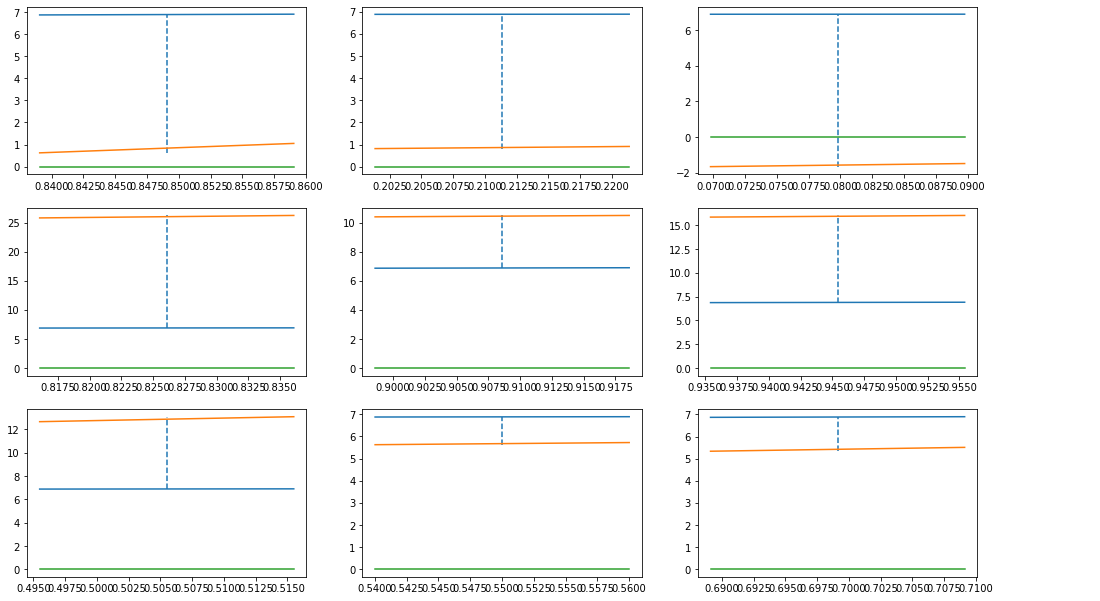

In [315]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# verify gradients


# create figure
fig = plt.figure(1)

for i in range(n):
    for j in range(n):
        A2 = A.copy()
        
        ax = fig.add_subplot(n, n, i*n +j + 1)
        a_list = np.linspace(A[i][j] - 0.01, A[i][j] + 0.01, 500)

        results = [[], []]

        for a in a_list:
            A2[i][j] = a
            results[0].append(expected_cost(A2, P, As = As, Ps = Ps))
            results[1].append(grad_a(A2, P, i, j))

        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([a_list[0], a_list[-1]],[0, 0])
        plt.vlines(A[i][j], np.min(results), np.max(results), linestyle = '--')

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [ ]:
def get_a_opt(A, P, i, j):
    # two points
    x1, x2 = A[i][j] - 0.01, A[i][j] + 0.01

    # save previous
    a_tmp = A[i][j]

    # get first points
    A[i][j] = x1
    y1 = grad_a(A, P, i, j)

    # get second point
    A[i][j] = x2
    y2 = grad_a(A, P, i, j)

    # restore A
    A[i][j] = a_tmp

    # calculate x_opt
    a = (y1 - y2) / (x1 - x2)
    b = y1 - a * x1
    x_opt = -b / a

    return x_opt

def get_A_opt(A, P):
    for i in range(n):
        for j in range(i + 1):
            A[i][j] = get_a_opt(A, P, i, j)
    return A

A = As.copy()
print(A)
A = get_A_opt(A, P)
print(A)

1.0
[0.462788762809474, 0.4641744831088701, 0.465560203407378, 0.4669459237067741, 0.46833164400528204, 0.46971736430467814, 0.47110308460363015, 0.47248880490258216, 0.47387452520153417, 0.47526024550093027, 0.4766459657994382, 0.4780316860992784, 0.4794174063973422, 0.4808031266967383, 0.4821888469961344, 0.4835745672946423, 0.48496028759359433, 0.48634600789299043, 0.48773172819194244, 0.48911744849089445]
[1.4035226030872705, 1.406706326317469, 1.4098900495476672, 1.413073772777865, 1.4162574960080634, 1.4194412192382613, 1.4226249424684598, 1.4258086656986575, 1.4289923889288563, 1.4321761121590542, 1.4353598353892523, 1.4385435586194506, 1.4417272818496487, 1.4449110050798464, 1.448094728310045, 1.4512784515402428, 1.454462174770441, 1.4576458980006395, 1.4608296212308376, 1.464013344461036]


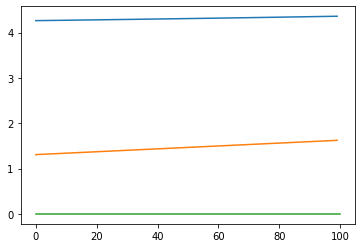

In [267]:
# verify gradients

P2 = P.copy()

i, j = 0, 1
print(P2[i][j])
p_list = np.linspace(P[i][j] - 0.1, P[i][j] + 0.1, 100)

results = [[], []]

for p in p_list:
    P2[i][j] = p
    results[0].append(expected_cost_lagrange(A, P2, As = As, Ps = Ps))
    results[1].append(grad_p(A, P2, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

der = [(j-i) * 100 / 0.2 for i, j in zip(results[0][:-1], results[0][1:])]
print(der[30:50])
print(results[1][30:50])

In [ ]:
# verify gradients
p_list = np.linspace(0, 1, 100)
P2 = Ps.copy()

lambdas = 0.1 * np.ones((2, n))
lambdasineq = 0.5 * np.ones((n, n))

i, j = 0, 1

results = [[], []]

for p in p_list:
    P2[i][j] = p
    results[0].append(expected_cost_lagrange(As, P2, As = As, Ps = Ps))
    results[1].append(grad_p(As, P2, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

To deal with the constraints that $p$ must be non-negative, we project the entries by applying the sigmoid function of each entry. Note that the range of the sigmoid is $(0, 1)$, which is also what we require for our entries $p$ (we did not explicitly constrain $p$ to be smaller than 1, but the equality constraints combined with the non-negativity constraints make sure that is the case.
To deal with the $2n$ equality constraints, we use $\textit{lagrange multipliers}$ $\lambda_{row, i}$, $i = 1, \cdots, n$ and $\lambda_{col, j}$, $j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P_\sigma, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n \lambda_{row, i} \left(\sum_{j = 1}^n p_{ij} - 1\right) - \sum_{j = 1}^n \lambda_{col, j} \left(\sum_{i = 1}^n p_{ij} - 1\right),$$
where $P = \sigma(P_\sigma)$

start
0 0	0 1	0 2	1 0	1 1	1 2	2 0	2 1	

No handles with labels found to put in legend.


2 2	

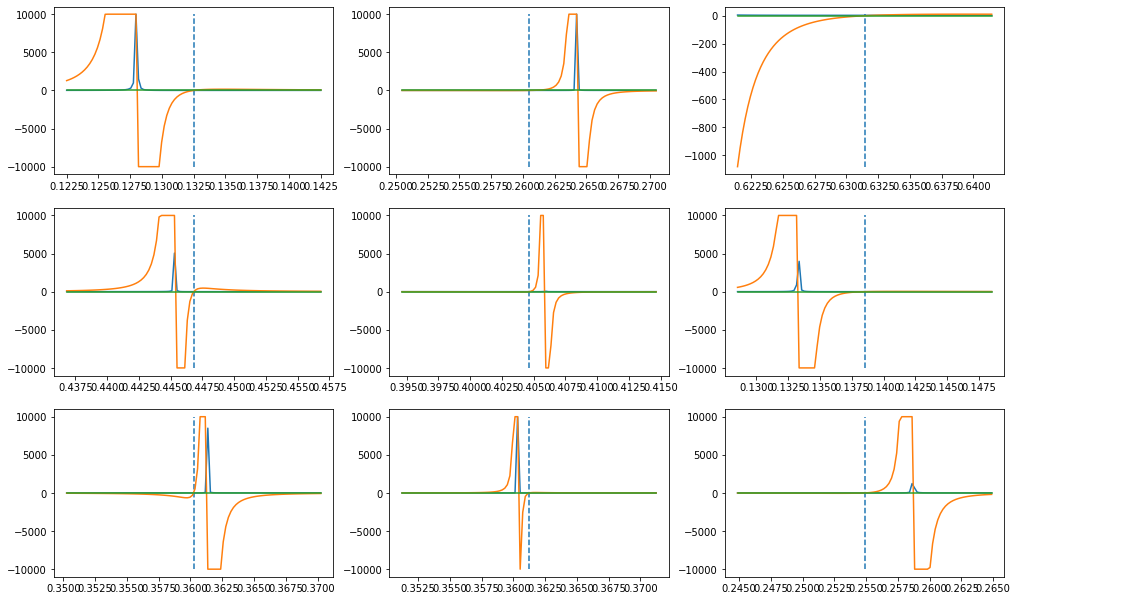

In [26]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# verify gradients


# create figure
fig = plt.figure(1)

print("start")

for i in range(n):
    for j in range(n):
        print(i, j, end = "\t")
        P2 = P.copy()
        
        ax = fig.add_subplot(n, n, i*n +j + 1)
        p_list = np.linspace(P[i][j] - 0.01, P[i][j] + 0.01, 100)

        results = [[], []]

        for p in p_list:
            P2[i][j] = p
            results[0].append(min((expected_cost_lagrange(A, P2, As = As, Ps = Ps), 1e4)))
            results[1].append(max(min(grad_p(A, P2, i, j), 1e4), -1e4))
            
#         plt.yscale('log')
#         plt.locator_params(axis='x', nbins=6)
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([p_list[0], p_list[-1]],[0, 0])
        plt.vlines(P[i][j], np.min(results), np.max(results), linestyle = '--')

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

start
2 0	

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

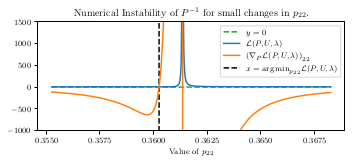

In [51]:
# Create a Position index
# plt.figure(figsize = (3 * n + 3, 3 * n))
# plt.subplots_adjust(bottom = 0.0, left = -0.2)
# position = range(1, n ** 2 + 1)

# verify gradients

import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False

# create figure
fig = plt.figure()
fig = plt.figure(figsize = (5.5, 2.0))
print("start")

for i in range(n):
    for j in range(n):
        if i != 2 or j != 0: continue
        print(i, j, end = "\t")
        P2 = P.copy()
        
#         ax = fig.add_subplot(n, n, i*n +j + 1)
        p_list = np.linspace(P2[i][j] - 0.005, P2[i][j] + 0.008, 1000)

        results = [[], []]

        plt.ylim(-1e3, 1.5e3)
        for p in p_list:
            P2[i][j] = p
            results[0].append(min((expected_cost_lagrange(A, P2, As = As, Ps = Ps), 11e3)))
            results[1].append(max(min(grad_p(A, P2, i, j, As = As, Ps = Ps), 11e3), -11e3))
            
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(r"Value of $p_{22}$")
        plt.plot(p_list, np.zeros(1000), linestyle = '--', color = 'C2', label = r"$y=0$")
        plt.plot(p_list, results[0], label = r"$\mathcal{L}(P, U, \lambda)$")
        plt.plot(p_list, results[1], label = r"$\left(\nabla_P \mathcal{L}(P, U, \lambda)\right)_{22}$")
        
#         plt.plot([p_list[0], p_list[-1]],[0, 0])
        plt.vlines(P[i][j], np.min(results), np.max(results), linestyle = '--', color = 'black', label = r"$x = {\arg \min}_{p_{22}}\mathcal{L}(P, U, \lambda)$")

plt.title(r"Numerical Instability of $P^{-1}$ for small changes in $p_{22}$.")
plt.legend()
plt.savefig('gdlexinst12.pgf', bbox_inches = 'tight')
plt.show()

start
1 1	

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


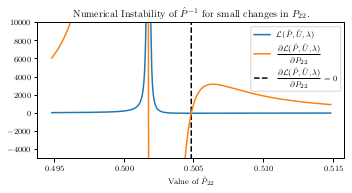

In [669]:
# Create a Position index
# plt.figure(figsize = (3 * n + 3, 3 * n))
# plt.subplots_adjust(bottom = 0.0, left = -0.2)
# position = range(1, n ** 2 + 1)

# verify gradients

import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False

# create figure
# fig = plt.figure()
fig = plt.figure(figsize = (5.5, 2.5))
print("start")

for i in range(n):
    for j in range(n):
        if i != 1 or j != 1: continue
        print(i, j, end = "\t")
        P2 = P.copy()
        
#         ax = fig.add_subplot(n, n, i*n +j + 1)
        p_list = np.linspace(P2[i][j] - 0.01, P2[i][j] + 0.01, 1000)

        results = [[], []]

        plt.ylim(-5e3, 10e3)
        for p in p_list:
            P2[i][j] = p
            results[0].append(min((expected_cost_lagrange(A, P2, As = As, Ps = Ps), 11e3)))
            results[1].append(max(min(grad_p(A, P2, i, j, As = As, Ps = Ps), 11e3), -11e3))
            
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(r"Value of $\hat{P}_{22}$")
        plt.plot(p_list, results[0], label = r"$\mathcal{L}(\hat{P}, \hat{U}, \lambda)$")
        plt.plot(p_list, results[1], label = r"$\frac{\partial \mathcal{L}(\hat{P}, \hat{U}, \lambda)}{\partial P_{22}}$")
#         plt.plot([p_list[0], p_list[-1]],[0, 0])
        plt.vlines(P[i][j], np.min(results), np.max(results), linestyle = '--', color = 'black', label = r"$\frac{\partial \mathcal{L}(\hat{P}, \hat{U}, \lambda)}{\partial P_{22}} = 0$")

plt.title(r"Numerical Instability of $\hat{P}^{-1}$ for small changes in $P_{22}$.")
plt.legend()
plt.savefig('gdlexinst.pgf')
plt.show()

In [545]:
print(P)

[[0.02801232 0.48486653 0.48551027]
 [0.02791889 0.48802938 0.47905437]
 [0.93538434 0.03047884 0.03632637]]


start
0 0	0 1	0 2	0 3	0 4	0 5	1 0	1 1	1 2	1 3	1 4	1 5	2 0	2 1	2 2	2 3	2 4	2 5	3 0	3 1	3 2	3 3	3 4	3 5	4 0	4 1	4 2	4 3	4 4	4 5	5 0	5 1	5 2	5 3	

No handles with labels found to put in legend.


5 4	5 5	

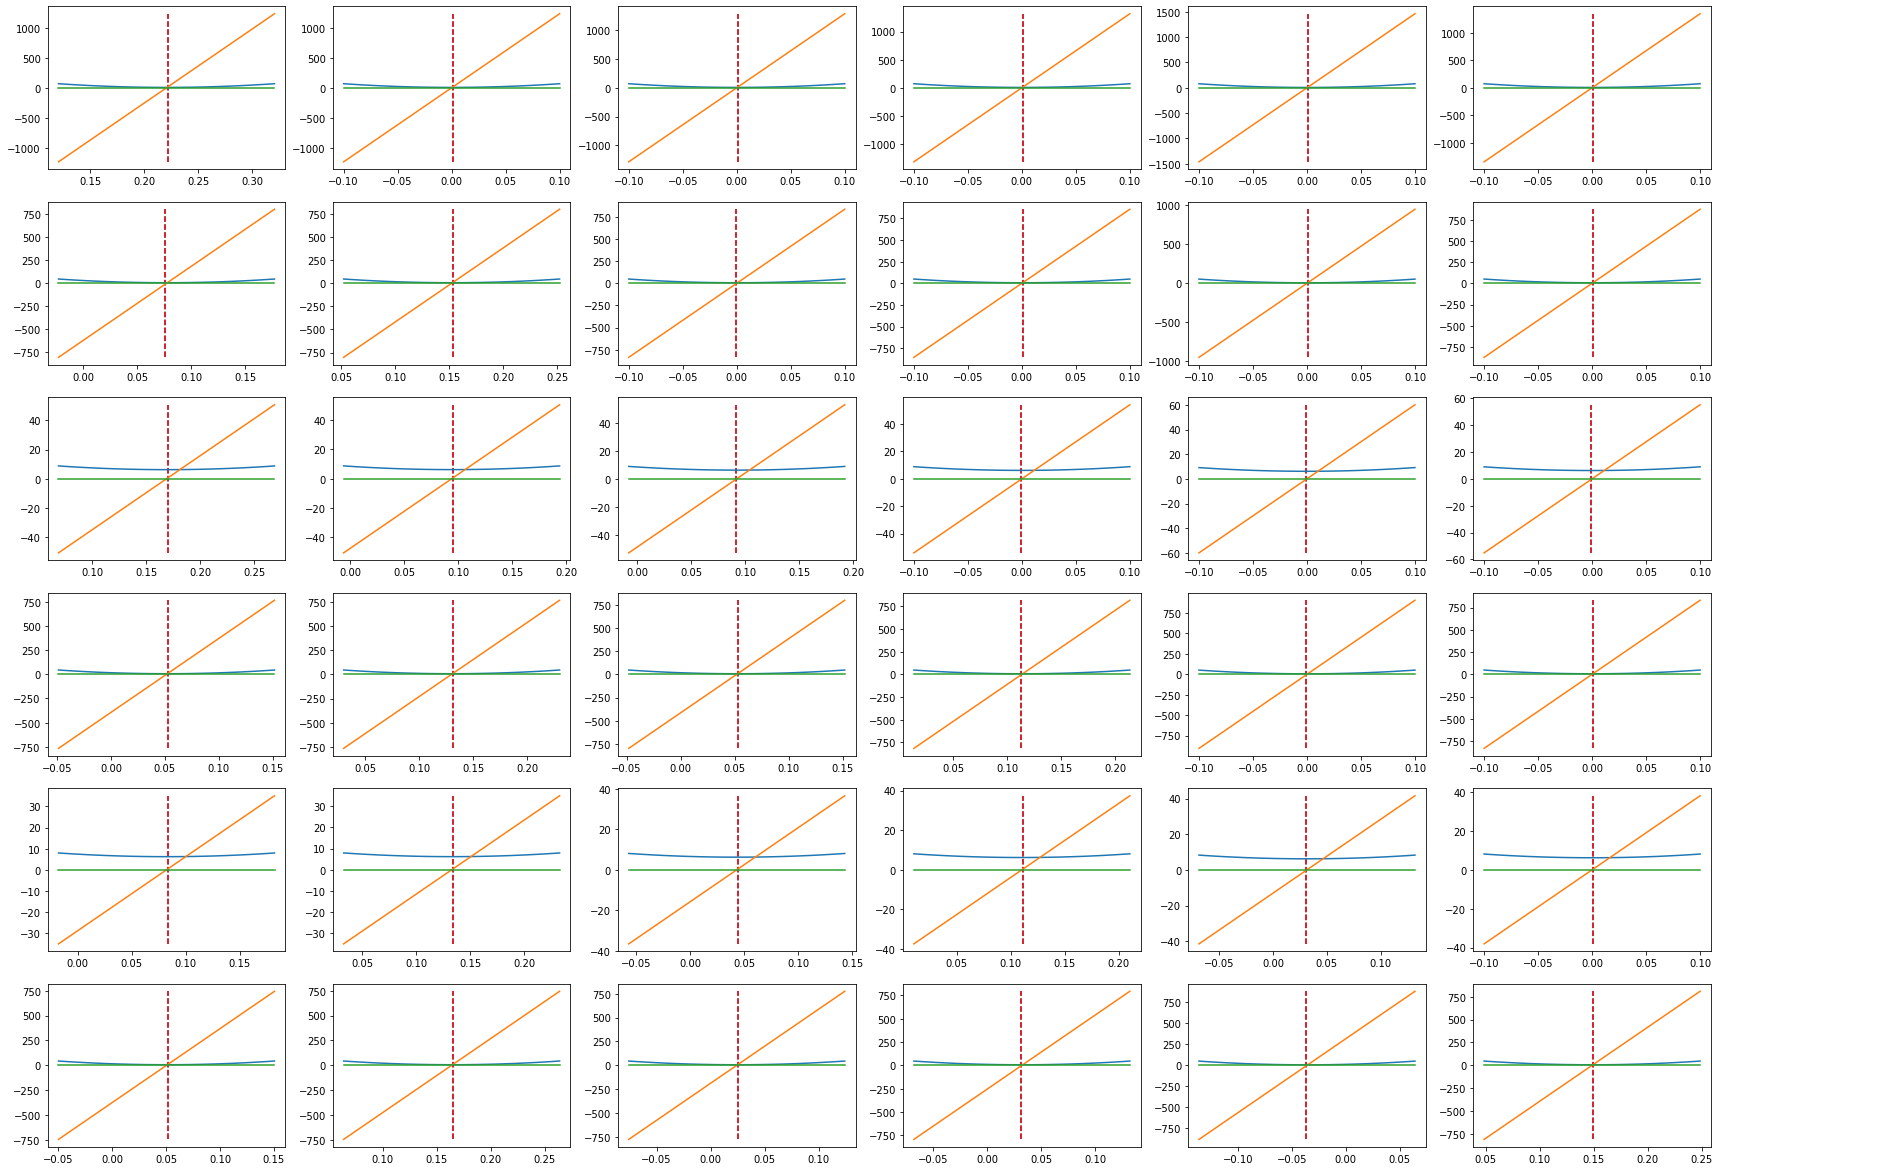

In [78]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# verify gradients
# A = np.tril(np.random.rand(n, n))
# P = Ps.copy()
# create figure
fig = plt.figure(1)

print("start")

for i in range(n):
    for j in range(n):
        
        print(i, j, end = "\t")
        A2 = A.copy()
        
        ax = fig.add_subplot(n, n, i * n + j + 1)
        a_list = np.linspace(A2[i][j] - 0.1, A2[i][j] + 0.1, 100)

        results = [[], []]

        for a in a_list:
            A2[i][j] = a
            results[0].append(min((expected_cost_lagrange(A2, P = P, As = As, Ps = Ps), 1e4)))
            results[1].append(max(min(grad_a(A2, P, i, j, As = As, Ps = Ps), 1e4), -1e4))
            
        plt.locator_params(axis='x', nbins=6)
        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([a_list[0], a_list[-1]],[0, 0])
        # minimizer of gradient
        plt.vlines(a_list[np.argmin(np.abs(results[1]))], np.min(results), np.max(results), linestyle = '--')
        # minimizer of cost, should correspond to minimizer of gradient
        plt.vlines(a_list[np.argmin(results[0])], np.min(results), np.max(results), linestyle = '--', color = 'r')
        # plt.vlines(As[i][j], np.min(results), np.max(results), linestyle = '--')

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [249]:
print(As)

[[0.20462216 0.         0.        ]
 [0.14840792 0.26752171 0.        ]
 [0.13487388 0.23724791 0.07014774]]


0.0
[-3.8356042169532145, -3.757326579872533, -3.679048942791807, -3.60077130571117, -3.522493668630533, -3.444216031549807, -3.3659383944691257, -3.287660757388444, -3.209383120307807, -3.1311054832270813]
[-3.8359956051386064, -3.7585007444287353, -3.6810058837188646, -3.603511023008994, -3.5260161622991233, -3.448521301589252, -3.3710264408793815, -3.2935315801695104, -3.2160367194596393, -3.1385418587497687]


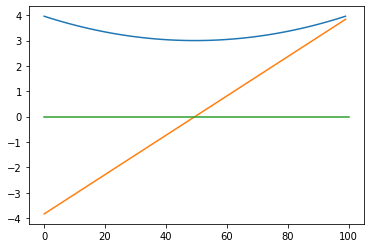

In [602]:
# verify gradients

A2 = As.copy()

i, j = 0, 1
print(A2[i][j])
w, N = 0.5, 100
a_list = np.linspace(A2[i][j] - w, A2[i][j] + w, N)

results = [[], []]

tmp = A2[i][j]
for a in a_list:
    A2[i][j] = a
    results[0].append(expected_cost(A2, Ps, As = As, Ps = Ps))
    results[1].append(grad_a(A2, Ps, i, j, As = As, Ps = Ps))
A2[i][j] = tmp

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, N],[0, 0])

der = [(j-i) / (2 * w / N) for i, j in zip(results[0][:-1], results[0][1:])]
print(der[:10])
print(results[1][:10])

In [327]:
grad_a(As, Ps, 0, 0, As = As, Ps = Ps)

-0.0